In [1]:
import pandas as pd
import numpy as np
import random
from intent_classify import IntentClassify
from gensim import corpora, models, similarities,matutils
from fasttext_util import FasttextClassifier
import time
from collections import Counter
from sklearn.cluster import KMeans
import jieba
import matplotlib.pyplot as plt
%matplotlib inline


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.292 seconds.
Prefix dict has been built succesfully.


load 1006 user-define jieba dict success!


In [2]:
class word():    
    def __init__(self):
        self.word_to_vec = {}
        self.dictionary = corpora.dictionary.Dictionary()
        self.dic = self.dictionary.load('../util/new/laiye/corpus.dict')
        self.tfidf = models.TfidfModel.load('../util/new/laiye/corpus.tfidf_model')  
        
    def remove_punctuation(self, line):
        rule = re.compile(ur"[^a-zA-Z0-9\u4e00-\u9fa5]")
        line = rule.sub('',line)
        return line        

    def stopwordslist(self, filepath):  
        stopwords = [line.strip() for line in open(filepath, 'r').readlines()]  
        return stopwords  


    # 对句子进行分词  
    def jieba_cut(self, sentence):  
        sentence_seged = jieba.cut(sentence.strip())  
        stopwords = self.stopwordslist('../util/new/laiye/stopword.txt')  # 这里加载停用词的路径  
        outstr = ''  
        for word in sentence_seged:  
            if word.encode('utf-8') not in stopwords:  
                if word.encode('utf-8') != '\t' and word != '\t':  
                    outstr += word
                    outstr += " "  
        return outstr.strip()

    def get_word2vec(self):
        with open('../util/new/laiye/w2v_sgns_win1_d80.kv') as f:
            data = [x.split(' ') for x in f.readlines()[1:]]
            words = [d[0] for d in data]
            vecs = np.array([d[1: -1] for d in data], dtype= 'float64')
            for i in range(len(words)):
                word = words[i]
                self.word_to_vec[word] = vecs[i]
    def get_tf_idf_of_query(self, query, dic, tfidf):      
        vec_bow = dic.doc2bow(query)
        vec_tfidf = tfidf[vec_bow]
        tp = [0.0] * len(query)
        ids = [tid[0] for tid in vec_tfidf]
        flags = [0] * len(query)
        count = 0.00001
        for j in range(len(query)):
            for i in range(len(ids)):
                if self.dic[ids[i]] == query[j]:
                    tp[j] = vec_tfidf[i][1]
                    flags[j] = 1
                    count += 1
                    break
        sums = sum(tp)
        #print ','.join(query)
        for i in range(len(flags)):
            if flags[i] == 1:
                continue
            tp[i] = 1.0 * sums / count
                    
        # apply l1-norm to tfidf value
        #tfidf = matutils.unitvec(vec_tfidf, norm = 'l1')   
        return tp

    def get_vectors_of_data_cut(self, data):
        vecs = []
        for i in range(len(data)):
            vec = []
            d_line = self.jieba_cut(data[i]).split(' ')
            tfidfs = self.get_tf_idf_of_query(d_line, self.dic, self.tfidf)
            s = sum(tfidfs)
            for j in range(len(d_line)):
                if d_line[j].encode('utf-8') in self.word_to_vec:
                    if s == 0:
                        vec.append([0.0] * len(self.word_to_vec['家']))
                    else:
                        vec.append((tfidfs[j] / s) * self.word_to_vec[d_line[j].encode('utf-8')])
            if len(vec) == 0:
                vec.append([0.0] * len(self.word_to_vec['家']))
            vecs.append(np.sum(np.array(vec), axis = 0))
        return np.array(vecs)    
    

In [7]:
class fold():
    def __init__(self, classCount, texts):
        self.texts = texts
        self.classCount = classCount
        
    def wordsCluster(self, word_vecs):
        #分类
        clf = KMeans(n_clusters = self.classCount)
        s = clf.fit(word_vecs)
        #获取到所有词向量所属类别
        labels = clf.labels_
        cluster_dic = {}
        #把是一类的放入到一个集合
        for i in range(len(self.texts)):
            if labels[i] not in cluster_dic:
                cluster_dic[labels[i]] = texts[i]
            else:
                cluster_dic[labels[i]] = cluster_dic[labels[i]] + ' ' + texts[i]
        label_pred = clf.labels_ #获取聚类标签
        centroids = clf.cluster_centers_ #获取聚类中心
        inertia = clf.inertia_ # 获取聚类准则的总和
        print inertia
        mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
        #这里'or'代表中的'o'代表画圈，'r'代表颜色为红色，后面的依次类推
        color = 0
        j = 0 
        for i in label_pred:
            plt.plot([word_vecs[j:j+1,0]], [word_vecs[j:j+1,1]], mark[i], markersize = 5)
            j +=1
        plt.show()

        return cluster_dic

69.38140107010133


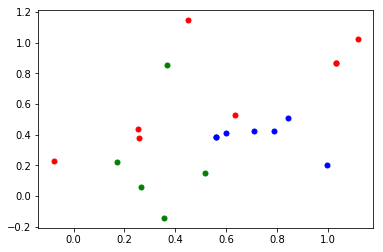

0
能陪聊天吗？ 陪我聊天 能陪我聊天吗？ 你能跟我聊天吗? 咱俩还能聊天啊? 还能不能愉快的聊天了 能不能聊天 不会吧这个助理可以陪着聊天吗
1
陪我说会儿话 陪我聊几句呗？ 陪我说说话呗 你能陪我聊会天吗 也就只有你陪在我身边 陪我聊会吧 陪我聊会天/:8-)
2
陪聊嘛？ 你能告诉我你是谁 你是不是擅长聊天 你是不是什么都懂 你总是那么懂我
1.1756869343582166


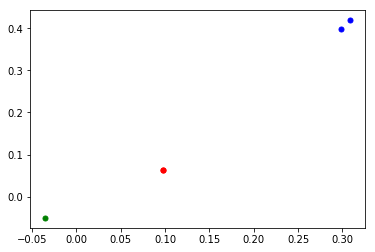

0
女朋友不开心了，怎么办 女朋友不开心，怎么办
1
怎么哄女朋友开心 怎么哄女朋友
2
有什么东西，能让女人瞬间开心？
0.1905088354704521


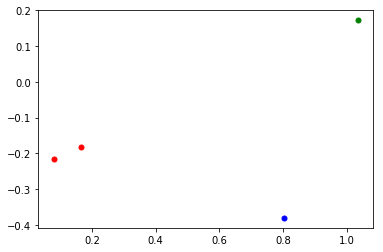

0
过年你们哪天到哪天休息呀 春节你们哪天到哪天休息呀
1
春节你们放几天假呀
2
过年你们几号休息呀
19.267719607279787


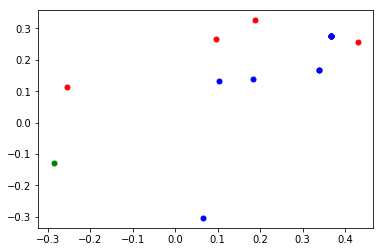

0
肚子饿了还不吃啊 肚子饿了有什么好吃的? 我现在肚子饿了,能帮我推荐一下附近有哪些好吃的吗 肚子饿了没吃早饭呢
1
肚子饿了 肚子饿啦 宝宝肚子饿 肚子饿, 我也肚子饿 肚子饿了。 下来我肚子饿啦! 肚子饿了怎么办 正好肚子饿,,,来的太及时了,,哈哈 肚子饿了……
2
肚子的了
117.77515367473663


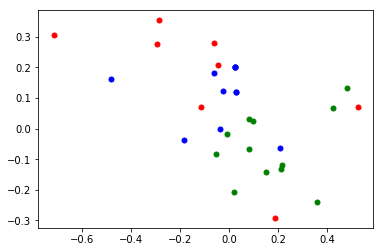

0
做我男朋友吧 帮我找到我男朋友 帮我介绍个男朋友吧 我要这个男朋友我不管 我要男朋友 你可以做我男朋友吗 男朋友 我要找男朋友
1
能帮我找个男朋友吗？ 找个男朋友 找个男朋友给我 找个男朋友吧 帮我找个男朋友 可以帮忙找个男朋友吗 我想找个男朋友 可不可以帮我找个男朋友? 七夕请帮我找个男朋友 能不能找个男朋友 你怎么不提醒我找个男朋友呢
2
找个合适的爱人很难 想来给我换个老公 我的见鬼女友 你想我什么呢?我又没有男朋友 帮我叫一个小妹 那你做我的男闺蜜吧 我现在缺个男朋友 金立我现在缺个男朋友 你能帮我找个人吗? 我下次介绍我男朋友给你认识 找个人 介绍我网红咖啡店
48.33715891393048


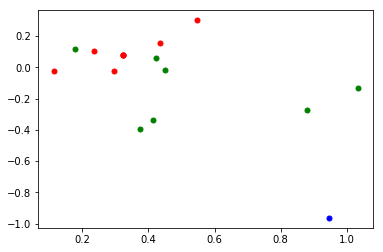

0
失恋了怎么办 我失恋了 想哭 失恋 失恋了 我失恋了想哭了怎么办 小来,你知道失恋的滋味吗 失恋你懂吗
1
我找不到老婆怎么办?
2
我分手了 和女朋友分手 女朋友要和我分手，我该怎么办 他不理我了 最近分手了 分手 我和男票分手了
87.85262866963244


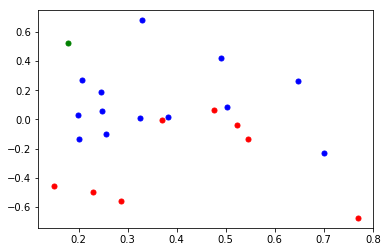

0
如果男朋友让我一次又一次失望伤心，我该怎么办？ 我跟朋友吵架了怎么办? 他为什么要丢下我,他说过他很爱我的 被人甩了怎么办 别人背叛了怎么办 已经吵架分手了怎么办 他说他不爱我了 爱我只是他报复
1
我感情出问题 感觉极度忧伤难过时想要逃避时该怎么办 忧伤 你是不是那个对的人 你有没有过伤心的事 为什么渣男总是我遇见 小来  我没有想见的人 内心恐慌 为什么总有人喜欢背叛 我还是喜欢我前对象 我和男朋友闹别扭了 不谈情 不说爱 陪我玩两年   写一封520字的情书(包括想要对我说的话) 还是伤心
2
我该怎么办
67.81799096873405


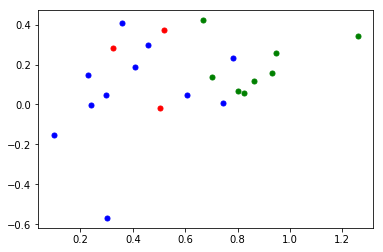

0
你喜欢我吗 如果我喜欢你 你会喜欢我吗 对你说我喜欢你
1
你爱我吗 什么是爱人 你好可爱真的是爱惨了你 我爱你胜过你爱我 我爱你 小来 爱我吗 晚安 说爱我 你爱不爱我 我爱你一万 爱小来 亲,我打过卡了,谢谢/:rose/:rose/:rose爱你哦
2
你说一个女生爱一个男生可以付出生命这样的爱是怎样的爱啊 很爱很爱你 爱你 好爱你哦 我最真的真的很爱你 什么是爱 啦啦啦啦爱可爱可奈 爱你到永远
8.288156922533066


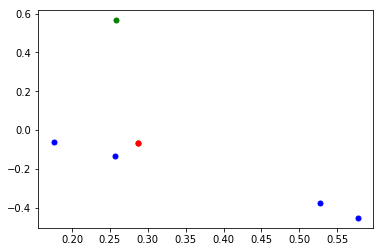

0
我为什么没有人爱 为什么没有人爱我
1
我为什么找不到对象 我为什么没有女朋友 为什么我找不到男朋友 为什么我没有男朋友
2
如何陪女朋友聊天
89.5459254854005


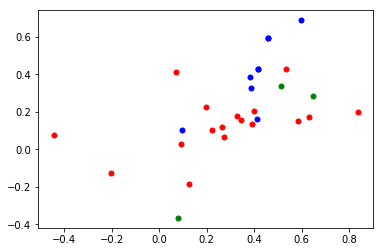

0
我怕有一天她真的消失在我面前了 我害怕你晚睡 好吧,虽然害怕 在不安在害怕 我好害怕你这样 我害怕没给开 害怕以后有这个场景 就是害怕太远人家不去嘛 害怕,就一直熬着 你说啥时候有offer 人生并非都是选择题,而是在做应用题,那要我们一点一滴的去论证,是取舍的过程,做错了也没关系。向前走,不必想太多,也不要害怕。安～/:sun 我现在好痛苦!/::'( 那个更痛苦  努力还是后悔 你说我我考研能考上吗 如果我的考试没有通过会怎么样 我就是痛苦又能怎么样? 很怕自己一无所有
1
害怕 我害怕 害怕怕 我很害怕孤单 我真的害怕 害不害怕 害怕未来会后悔 我现在现在有点害怕 可是我更害怕表现孤单
2
为啥我总是害怕 为什么发的总是这句话 可他不一定喜欢我
114.14827588495082


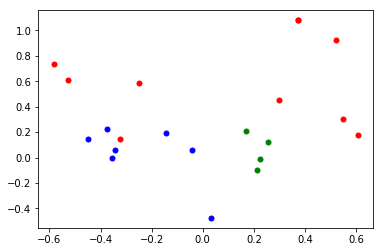

0
心情不好怎么办 我心情不好 难过 想哭 我不需要我心情不好 很难过 可是我好难过 今天很难过 压力大心情不好怎么办 心很累
1
不好 如何忘记一个人 怎么不好叫 我不好 我考的不好 我非常不好 我不好小雷
2
不开心 我不开心 我还是不开心 怎么会知道我不开心
349.0342320945366


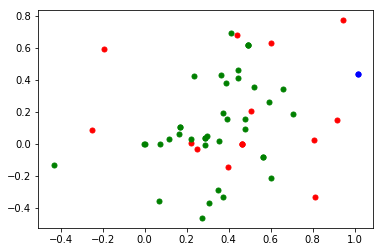

0
困 好冷 又干又疼 我想哭 困吗 今天有点困 累 我哭了 哭了 家里有点冷 暖哭了 想我干啥咯 困啊 小来我累了怎么办 难受
1
没事啦 没事啊
2
好累啊 好累 好困 累死我了 我好累 瞧把这孩纸困得 我累了 困死了 抱抱 呜呜 痛哭 妹子乖 好来 抱 好吧呜呜 感觉我要废了    咳嗽不止   吃药还不管用     状态低迷的不行    这是要大病的节奏么 好累哦 今天有点晚哦 能让我抱抱你 今天起的有点晚 小来阿姨为什么 感觉好累好累啊? 不跟你好了 人活着为啥这么累 没人在乎我 你今天晚班 想见不能见的感觉好难受 我妈妈生病了 我想哭 累死了!多少遍了 吓死宝宝了 今天胃痛.很难受 有种想哭的冲动 现在困死了都 先这样我要睡觉我好累 暖暖( ω ) 没睡醒呢/::-O 心好累 我累了 早上好呀。有点困最近 今天来例假不想动
315.4921130387561


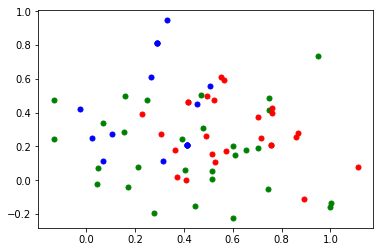

0
睡不好现在还想睡觉呢 睡的不好 睡不好 不想睡 你怎么还不睡 我又不想睡 我还没准备睡 昨天睡的一点都不好 其实我没睡 劳资还没睡 我昨晚没有睡 今天睡不了 其实我准备刚睡 我能说我没睡么 我还没睡呢 才睡啊 不准备睡 不睡 一宿没睡啊 不睡 不睡 不睡 怎么才好睡 昨晚差不多一点睡的 你咋还不睡呢 睡的不怎么好 我昨天晚上睡的不好
1
失眠了 睡不着 睡得不好 睡不着怎么办 失眠噢 睡不着难过 我睡不着 昨晚睡得不好 晚上睡得不好 有人失眠吗 失眠怎么办 睡得不好咋办 但是我睡不着 醒来我现在睡不着 身体痛睡不着 睡不着啊
2
没睡好 小来,我睡不着 没睡 我不是想睡觉的 怎么就睡不着呢!是饿吗? 为什么又开始失眠了 一夜没睡 半夜喝咖啡喝的失眠 一宿醒了很多次 都没有好好休息 现在感觉昨晚被人打了一顿似的 想睡睡不着有多难受小来你知道吗 最近老失眠 我昨晚睡了吗 ? 我好像失眠了 你能讲一个睡前故事给我听吗? 昨晚没睡好 赞失眠签 失眠的――痛痛痛 看了小来也没办法治疗失眠 睡不着  怎么办    失眠了亲 人家失眠都数羊你为啥数梅花捏 我失眠了咋整 要怎么才能不难受呢 我基本没睡 我一夜都没怎么睡觉/::~ 每次睡不着的时候就会翻看 失眠怎么 为啥不是数小羊
67.66412565937569


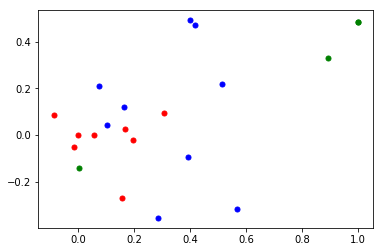

0
我明天起打算做个眼部手术不能看电子产品,手机电脑一类的 胃疼 肝疼 蛋疼 我病了所以昨天没有 捂着心脏喊疼 头好痛 头疼 全身无力
1
心疼 头疼 脑袋疼 我难受 有点难受 你怎么知道我今天身体不舒服 好恶心 就是头也疼肚子也疼 我真发烧了
2
我生病了 生病 生病了 我感冒了 怎么办
101.90886634841598


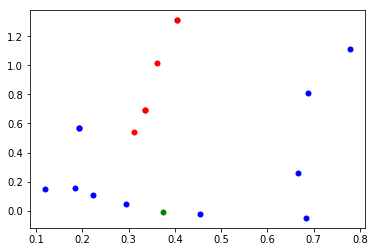

0
好无聊 无聊 我好无聊 好无聊啊 我很无聊 无聊怎么办
1
没意思 学习没什么动力 不想动怎么办? 我不睡觉了 我好寂寞 不想写怎么办 寂寞了 寂寞 我说我好无聊 寂寞其实也只是一种状态罢了 一个人不知道要干嘛
2
么意思
0.0


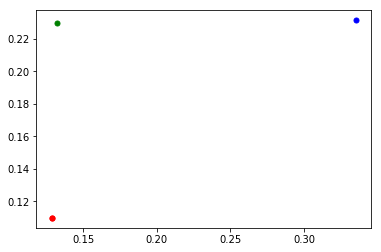

0
我好烦 我好烦啊!
1
小来。我心里好烦
2
好烦呢
29.558626575368727


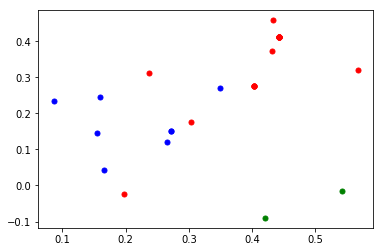

0
好困怎么办 好困怎么办,我想现在现在就下班 好困啊好困啊 我好困好困 好困 好困呀 好困哦 好困。 中午好困 好困啊 我好困 但是好困 我好困呢 我好困呢. 突然好困。 我好困哪 我好困呀! 小来,我好困
1
好困打瞌睡怎么办 打瞌睡 打瞌睡了 好瞌睡啊 不考虑时差吗? 我好困有什么办法吗 瞌睡 很困/::'(/::'(/::'( 我瞌睡
2
我有些困 为什么这么困!
0.0


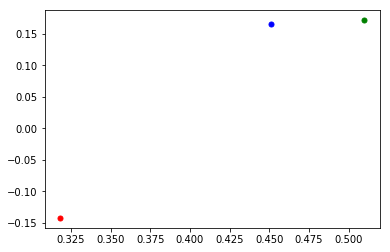

0
好艰难
1
人生为何如此艰难
2
每天过得太艰难
118.3557632978327


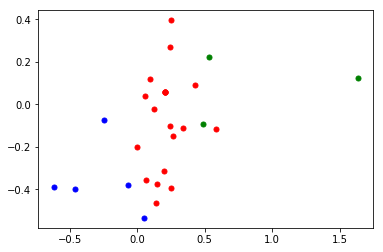

0
我美吗 我美么 我美么? 女王,我美么 我性不性感 我美吗? 我帅不 这个图美不 想想吧你觉得我帅吗? 那行了你觉得我帅你说 你又不知道我长得什么样? 小来 你夸夸我 我又没见过你怎么知道你好不好看? 你感觉我漂亮吗? 要喝酒吗 美得很哦你 你听得懂四川话吗 你说莫比啊?老子听不到 我帅吗? 我长得美吗?
1
我长得好看吗 你是说我不好看 我好看吗 我是说字好看吗 画得好看吗?
2
谁是世界上最漂亮的人 谁是最美的女孩? 认识我老婆吗
12.174268405040596


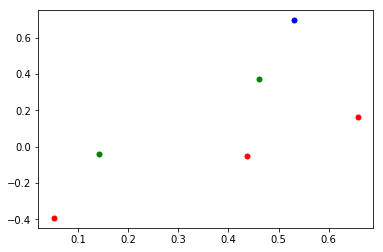

0
你说这个世界上有能相信的人吗 我又無聊了 世界上最大的谎言就是你不行
1
觉得我很无聊是吗?
2
你相信我吗 不美不萌不温柔
0.0


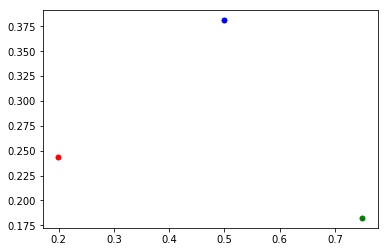

0
非常不想上班，只想暴富
1
我不想上班
2
51不放假,天天工作中
0.0


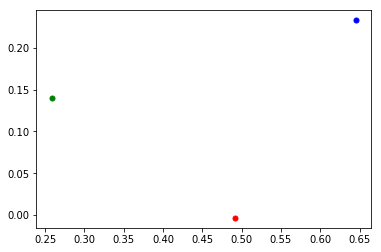

0
觉得别人都讨厌我
1
我讨厌等红灯
2
我不想让人觉得柔顺的卑微
2.8677451187258884


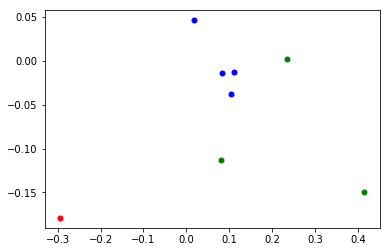

0
u
1
I miss you so much,can you come back I miss you whay do you say I am   came  back
2
i do'nt ok。u can question。 miss you
14.302867206926438


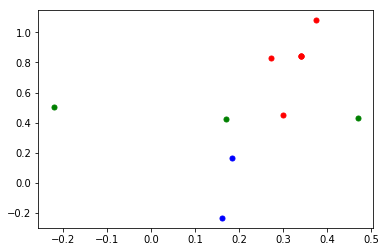

0
我好难过 难过难过求安慰 我真的很难过 我真的很难过啊 我难过 真的 难过
1
心真的好痛 我今天出车祸了  小来
2
好难过求安慰 心情很不好，求安慰 安慰我
118.99281885206702


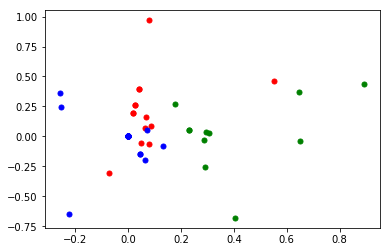

0
谢谢 小来 谢谢小来 谢谢小来! 谢谢芒果 谢谢你小来 谢谢,小来 好的谢谢小来 谢谢榴莲 谢谢tom 谢谢木木 谢谢你,小来 谢谢助理 好的,谢谢小来 小来真好/:rose
1
谢谢210 谢谢你了 谢谢你哦 谢谢亲爱的 谢谢你! 谢谢宝宝 好的谢谢你 好,谢谢你 谢谢甜甜 谢谢亲！ 谢谢你/::) 谢谢你。 谢谢你 好的,谢谢你 谢谢亲 谢谢你的帮助 你很有趣哦[Smirk] 谢谢32老师 噢~谢谢
2
谢谢你们 完美解决,谢谢哦 好像身边有一个人,在监督,关心,提醒自己,挺好,生活会有规律些 感谢person这么好的平台,我的拖延症都快痊愈了 哈哈!我就问问不取关 有你太好 有你的消息真好 有你真好/::) 认识你炒鸡好的 感谢小来一直的陪伴 谢谢!有您真好
442.9150741073429


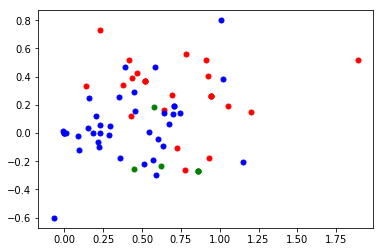

0
我也爱你 爱你 我喜欢你 爱你哟 喜欢你 爱你哦 可爱 太可爱了 喜欢我吗？ 你有喜欢的人吗 我今天可爱吗 我好喜欢你 很爱我老公 我比你还可爱 我想被爱 我真的喜欢你 哦这样啊!爱谁呢 你喜欢我吗? 我想对她说我爱她 我爱小猫 为什么爱我 你喜欢的人是谁 爱的鼓励 我要爱自己
1
么么么么么恩 好哒么么哒 爱你么么哒 么么哒 么么 为什么不可以吗你是不是怕我喜欢上你呀? 爱你呦 有你真好 呦呦,切克闹 贼稀罕你 亲吧 我是对你说  我爱你 我一直没感受到你对我的爱。 我爱你 小来 好哒。知道啦 我                                                          爱                                                     你 我也来也 我对你是真无语了。 我亲你一口 爱你的霞 野原新之助对你发起大象舞嘲讽 我非常的爱你 喜欢你这件事我准备放弃。                      永远俩字收回 宝宝么么哒 知道了么么哒 爱我一会儿好吗/:rose/:rose 我非常喜欢你 爱你每一天 我爱你 /::B 希望你每一天都快乐 么么哒/:hug/:hug 爱你哟!么么哒 小小来我爱死你了 你们真好 来儿 我爱你 小心心发射 爱你喔 爱你到永远 我想对我喜欢的人说我我爱你 昨天还信誓旦旦地说爱我
2
我爱你 我爱你这句话我撤回 我爱你们 我爱你哦 我先说一句我爱你吧 我爱你呦
459.2966624874051


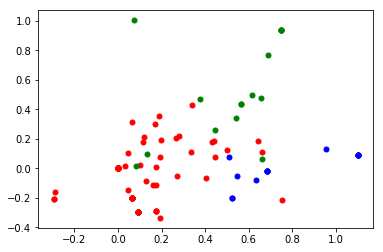

0
谢谢 嗯嗯，谢谢亲 哈哈谢谢 谢谢，谢谢 嗯嗯，谢谢 好的，谢谢 谢谢 好的谢谢 靴靴 好的,谢谢啦 谢谢哈 谢谢～ 谢谢您 好的!谢谢! 好的,谢谢! 谢谢。 谢谢提醒 嗯嗯,谢谢 谢谢你啦 ok谢谢 嗯,谢谢 好的,谢谢～ 好吧,谢谢 好哒,谢谢 谢谢喔 谢谢. 谢谢,辛苦了 好的谢谢, 谢谢,么么哒 嗯嗯谢谢 好的,,谢谢 谢谢你. 谢谢啦! 太谢谢啦 谢谢咯 嗯谢谢 好的,谢谢. 好滴,谢谢 好的,谢谢哦 好了,谢谢 好的谢谢啦 谢谢谢谢 ,谢谢 谢谢了! 好的。谢谢 好哒谢谢 好的,谢谢啊 是的,谢谢! 好谢谢 感謝 谢谢/::) 好的,谢谢 谢谢! 谢谢啦 谢谢了 谢谢哦 谢谢, 好的谢谢! 谢谢啊 蟹蟹 三克油 三克油喽 没有谢谢 没有了谢谢 请提前来,谢谢 没有了，谢谢 好谢谢啊 谢谢各位亲们 好吧，有需要找你，谢谢 谢谢汪老师 真好玩 高级 谢谢!一定会的。 好的 感谢 谢谢小来今晚的给的失眠签 谢谢蓝蓝 多谢汪老师 有事叫你谢谢 收到了谢谢 好吧 谢啦 谢谢亲的耐心解释 修改好了 谢谢你/:rose 非常感谢能够给我补救! 谢谢小来的鼓励,我会继续加油的 谢谢你这么久以来的陪伴,真的感谢 哦,知道了!谢谢您! 谢小来
1
好的，多谢 好的，多谢提醒 多谢！ 好的，多谢多谢 好的呢，多谢 多谢多谢 谢啦 谢 谢啦～ 多谢 非常感谢 谢了 多谢啦 谢啦!咖啡很棒! 嗯嗯谢了
2
太感谢了么么哒 太感谢了 感谢 多谢太感动了 好的，感谢 感谢?? 感谢! 感恩 好的很感谢 很感谢 非常非常感谢 感谢有您 感谢感谢很好 感谢你 感谢老师 感谢亲爱的陌生人
508.62208539958556


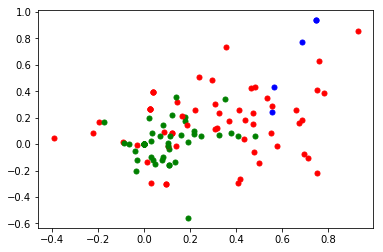

0
谢谢你了，小来 谢谢你太感谢了 谢谢小来 谢谢小来 谢谢小来哈哈！ 好的谢谢小来！ 谢谢谢谢小来 谢谢,早安分享～ 谢谢美女 应该是好了,谢谢 谢谢,愿每天都有好心情 谢谢小来回复! 嗯嗯。谢谢小来。比心 谢谢陪伴 好的谢谢 谢谢帅哥 好的,谢谢小来转达好友问候… 谢谢大家 谢谢小助理 谢谢你关心我啊 微笑 谢谢小来每天陪伴 谢谢亲爱的小来宝贝 谢谢你陪我! 嗯,谢谢小来 非常非常谢谢 谢谢小来的陪伴^O^ 谢谢说好 谢谢!很喜欢 谢谢/:coffee/:rose /::|说到心里去了 很喜欢 谢谢小来!/:@)/:coffee 谢谢分享 好的谢谢啊来 好吧谢谢美女 谢谢🙏您是最棒的🙏 谢谢 您是最棒的 收到∼谢谢∼ 好了谢谢∼ 蟹蟹你陪我玩 蟹蟹！ 蟹蟹你 谢谢你给的温暖 谢谢你对我的服务 可以啦~谢谢小来 谢谢小来我的打卡天数回复了 谢谢你的鼓励我现在开心了 谢谢你的关心和服务 谢谢你陪伴了我那么久 没有关系哟∼∼谢谢你每一天的陪伴哟/:rose不知道你是机器人回复还是人工/: 我很感激我的小姨提供这么好的机会让我去了解这个项目 谢谢关心睡的很好 喜欢心语签。谢谢您的用心之举! 早上好!谢谢/:@)/:@) 谢谢/:hug/:hug 感谢[太阳] 我就是每日要这张打卡图,谢谢!
1
感谢感谢?? 好的感谢感谢！ 好的感谢 好的，太感谢了 感谢感谢！
2
谢谢 谢谢亲 谢谢 谢谢你 谢谢谢谢谢谢小来 谢谢。天凉了,注意身体 谢谢,这条祝语很受用 谢谢你,额好 哦哦 谢谢 哈哈哈 微信真麻烦 小助,谢谢你 好的,谢谢/:,@-D保持微笑/::) 帮我谢谢他老表 谢谢真快 谢谢回复 喔 他退我钱了 谢谢你啦 好 你也是 已经修改了 谢谢 射谢 谢谢你，我的小秘书 好 沒關係 还是要谢谢 谢谢有你! 谢谢有你 谢谢 来也 谢谢老铁 谢谢节日快乐 好的 thx! 好的呀 谢谢 谢谢小棉袄 还是谢谢你~ 感激你 谢谢送到 谢谢/:B-) 谢谢寻找阳光里的向日葵 谢谢你的关心 谢谢呀 谢谢!亲~ 谢谢你!真靠谱 好的  谢谢亲 嗯  谢谢你啦  亲爱的 是的 谢谢你 谢谢喽 已經跟小哥處理好了 謝謝 谢谢 感激王伶 方怡 对我的信任 谢谢你亲 早⊙▽⊙谢谢你 谢谢下来 谢谢小来服务周到! 不用了,谢谢 谢谢亲爱的 谢谢,有补签给力,辛苦!
14.3364495063

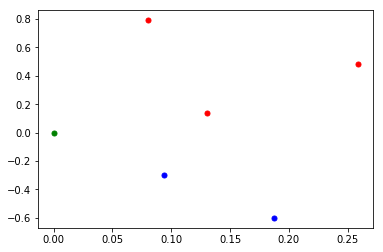

0
好的麻烦小来了 嗯呢，麻烦小来了 是，麻烦小来了
1
好的，麻烦了 好的谢谢!
2
麻烦了
0.40410504334891334


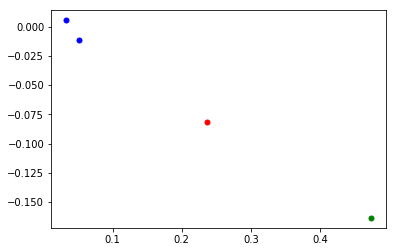

0
thank,you
1
Thank you very much thankyou
2
thank you
37.63433175443576


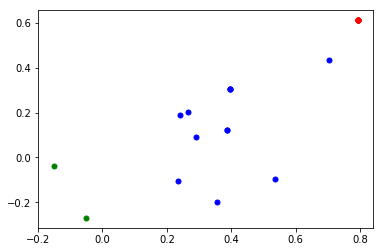

0
辛苦了。 辛苦了 辛苦啦 辛苦 辛苦啦! 辛苦辛苦
1
辛苦你了 好的,辛苦了 好的,辛苦 谢谢,辛苦了 你辛苦了 辛苦你啦 辛苦蓝蓝,打赏下 好嘞 辛苦啦 我在支付他的费用里面含了 没事了 都不容易 不用 我快弄好了 辛苦 好朋友好辛苦 辛苦了/:coffee
2
不容易呐 人家也不容易
30.30611246616573


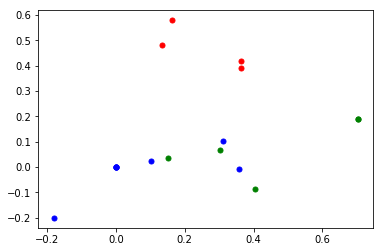

0
助理来也 我爱你 助理来也 谢谢你的陪伴 助理来也 谢谢 助理来也 。谢谢你
1
么么 么 么么扎 比心 么么么 谢谢,么么哒 亲,谢谢,心里暖暖的/:hug 么么~
2
么么哒 爱你么么哒 嘿嘿么么哒 可以爱你么么哒 么么哒/::P
197.40175772474464


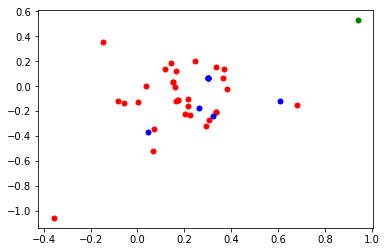

0
给你一个么么哒 谢谢，么么哒 你说什么 小来,爱死你了 好的谢谢亲爱哒 好的,么么哒 好的,萌萌哒。 date给我一个么么哒 再来一个么么哒 小来,来一个么么哒 你这么美说什么都对 nice 我爱你机器人,么么哒 mua 亲一个 闷闷哒 亲亲 亲亲啊! 别写来了么么哒 萌萌哒。 我能给你起一个小名吗? 亲亲好吗 爱一个人有错吗 我让你亲我 这么温柔! 亲亲我 光棍快乐么么哒 好害羞哇 么么哒∼(^з^)-☆ 手动给后台笔芯 木啊
1
么么哒 好的。么么哒 萌萌哒。 还么么哒。 哒哒哒 么么哒么么哒么么哒 我爱你么么哒 么么一个哒
2
么么大
373.79782845909926


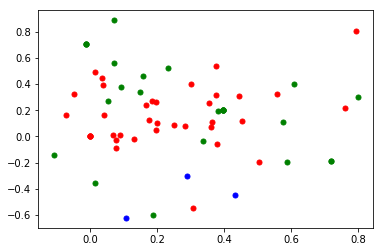

0
太强了！ 小来你好棒 强呀 小来你好强 太强了小来 谢谢小来 好强！ 你太好了 小来你太好了 小来你真好 你真好 真好 太好啦 四哥威咯！ 真不错 不是啊我是说你很聪明 这个不是要谢谢你下来你太好了 你怎么知道我的名字 谢谢谢谢下来 这个谢谢 算你聪明 必须的，推荐好多人关注你呢 为什么感觉你总知道我在想什么 你牛掰 我醒来你怎么知道? 谢谢我很喜欢这张图片 你聪明 服了你了 谢谢下来 你好棒 好的 谢谢您 真好 表扬你们呢 小来你很厉害 我很喜欢你的心语签奥 这助理不错服务周到 你还挺有劲儿 谢谢您/:share/:
1
牛逼 牛 你牛逼了
2
厉害 厉害了！ 小来你太厉害了 嘿嘿，不错 赞一个 厉害！ 很棒啊！ 好的太好了 啊！太好了！ 太好了 哎呀，太好了 很好非常好 太好了，太好了！ 哈哈太好了 很好 不错 好厉害 聪明 是挺好 调皮也挺好 我喜欢心情语录 小来你太聪明了/:strong 不错哦 好厉害小来机器人 我觉得小来很棒 不是好厉害是非常厉害
138.0430962069952


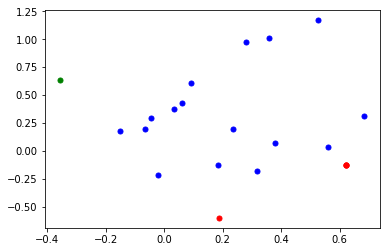

0
很好用呀 很好用 很好用啊 这么好
1
太好用了 小来你太好用了 非常好用的软件 特别好用 这软件平时真的很好用。 好厉害的软件 这个软件太给力了,好喜欢 非常好用 你比我助理都勤快 有点意思 今天的星座说的很不错 今天天气不错 你这公众号还真特别 这篇文章说的不错 这个公众号太赞了 666我喜欢这个公众号
2
好玩
14.040898307636414


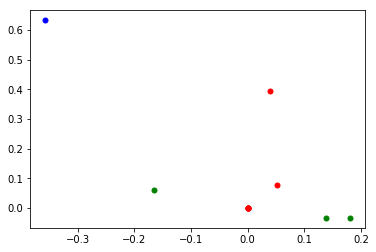

0
6666 小来666 666 一点不谦虚 6 [Facepalm]666
1
好玩
2
非常6 你太6了 你太邪恶了
357.5803067403284


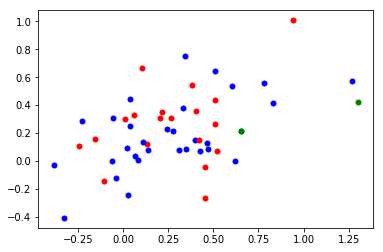

0
好的，太棒了 太棒了！ 给你点个赞 赞一个 赞！ 好棒棒 棒棒哒 我的助理挺靠谱的 小来太棒了 超级棒的小来。 小来么么哒 你非常棒 好棒/:strong 给小来点赞 /:strong/:strong有语音 棒棒哒 做的不错 感谢照顾啦 谢谢/:strong 我们可真棒
1
你太棒啦 你很棒 你怎么那么棒 赞赞赞 谢谢你的夸奖 这个背景好看 打卡背景都是我喜欢的 你一定会成功 哈哈,好吧。竟然回复这个。加油。看好来也! 为你打call 你们效率太高啦 打call 我也喜欢 真准 很赞 很好用的app 给这回答点赞 你好聪明 你咋这么了解我/::> 为这个创意点赞 送你一颗红心 你真好看 我妈妈夸你很聪明 夸你 心语签做得很棒 哈哈!你好幽默 好棒太靠谱了 你最好 嗯送你花花/:rose 哈哈太神奇了
2
你好美啊这 你好美 美
59.93897810724464


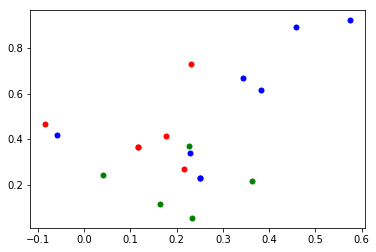

0
哈哈,可爱 小来好可爱呀 好可爱呀 很可爱 你很可爱 你怎么这么可爱
1
非常可爱呀 哈哈，小来真可爱 小来你太可爱了 小来你真可爱 你太可爱了 真可爱 太可爱了你 你真可爱
2
有你真好 真会说话啊 哎古那你会有多可爱啊? 太喜欢小兰你了 是我太喜欢你 还是你自己太拿自己当回事了?
52.01993235998175


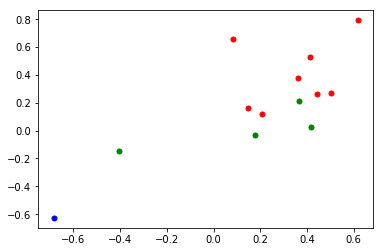

0
贴心小宝贝 你真贴心 小来太贴心了 贴心小来我爱你 好贴心呀你 太贴心了！ 真贴心 贴心的小来同学
1
我的愿望.就是希望你的愿望里.也有我
2
太喜欢小兰你了 能打开 太开心了 我不想你可怜我 我的宝贝
45.30929582629528


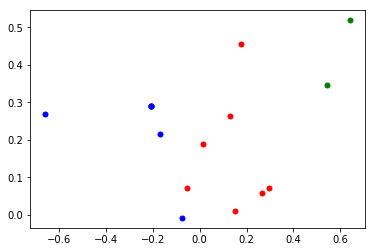

0
小来啥时候可以成为独一无二的好帮手(,▽,) 小来,看到这个有没有什么想和我说的 谢谢 加油 加油↖(^ω^)↗ 爱你!我要加油 就喜欢小来这么人性化/::P加油 /:coffee[Yeah!]开工咯
1
想来也要加油哦加油加油加油, 加油 加油! 好的加油 加油哦 我要加油
2
体验挺好的啊 祝越来越好
260.871962689263


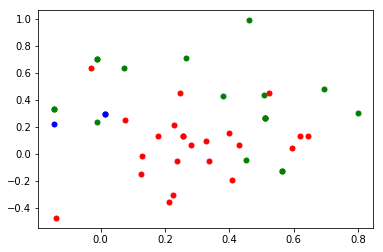

0
你好厉害呀！智能机器人。 你真棒 你真棒。 好赞 点赞 稳 你真好 好棒 你很棒 完美 好像很厉害的样子 你和小冰谁厉害? 你好厉害耶 蛮机智慧的[Smart] 你为什么知道我起床了 赶紧夸我 说这么准呢 对,超赞 小来最棒! 说的蛮准滴! 我擦这么准的吗? 小来还是很帅滴 小来你很帅!
1
赞 赞! 非常赞
2
棒棒 真棒！ 棒棒哒 真棒 厉害了 棒 太棒了 棒棒的 很棒 真棒! 棒! 真聪明 强大 小来真棒 哇塞!这么智能? 那么厉害？ 越来越不智能了! 小来好棒
0.7422487473668264


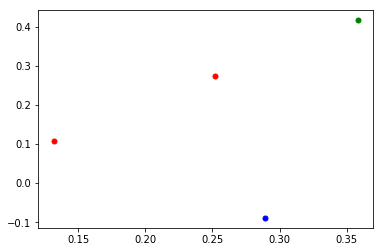

0
真乖 你好乖
1
乖
2
真乖/:strong收到
0.0


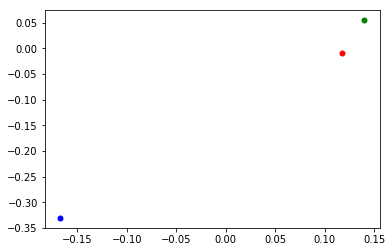

0
勇者必胜
1
勇者一分
2
骑士必胜哈哈哈!
15.104183184422373


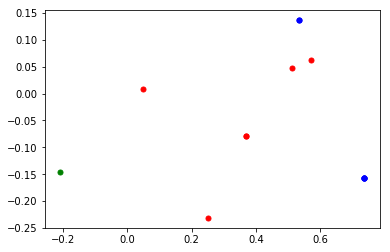

0
恭喜, 恭喜恭喜,继续努力 恭喜你哦 恭喜,真的很棒 恭喜你又长一岁 你想要明年结婚 我说行
1
恭喜 恭喜恭喜 恭喜恭喜! 恭喜呀 恭喜小来 恭喜小来!
2
我竟然要结婚了。
2.1644190765215297


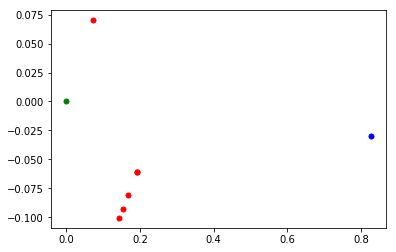

0
啧啧啧 啧啧 啧 啧… 啧啧啧啧啧 啧啧啧,,厉害了!
1
我不爱你
2
……
53.091039161547286


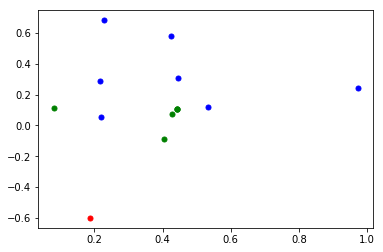

0
这个好
1
满意满意,谢谢! 这个问候好 你可真社会 你真吹牛。 对你的服务一直都很满意 你真智能 你真pi
2
非常满意 我满意满意～ 满意 很满意 满意! 我已经满意了
295.57055497114095


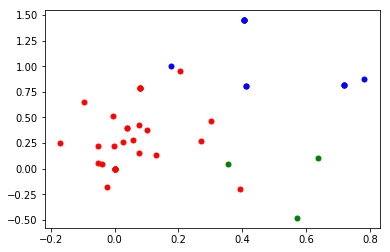

0
hi小来 哈喽小来 嘿 亲爱的 你好, 小来, 助理君 你好! 小赖 你好小来 小来啊 来来来 嗨喽 你好,小来 小来好 哎呦 hi 嗨,美女 hi 小来 可以叫我小仙女吗? 你是他的助理 亲爱的小仙女,你真及时 我能不叫你小来吗? 我也叫小来 助理来也 老石你起来啦 小来 有事找你 助理来也 m hi你好 小来呀 我能和你聊天儿吗
1
来来 助理来也助理来也 来也呀 助理来 来了么 助理来也晚了嘛? 助理来也 助理来了 小来来也 助理来也好 小来《来也》
2
小也君 小也 小啦来
66.5925140650471


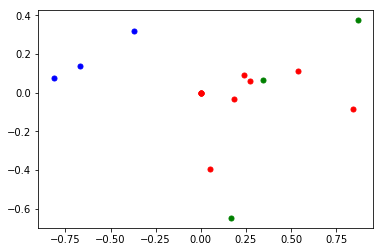

0
你好吗 你最近好吗 好久不见，你还好吗？ 你还好吗？ 你还好吗 你好窗外的世界 这个世界有没有真爱 我你好 你好~ 你最近咋样
1
你怎么样 你们公司怎么样~ 你怎么啦
2
我很好 老朋友睡得好吗?我睡得很好。 生气了?
917.0567541662107


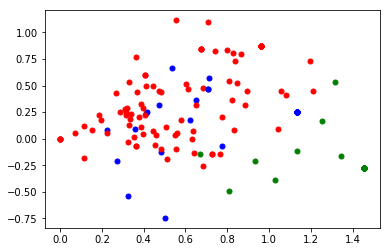

0
小来，早上好 小来早上好 早上好! 早安/::D 早安/::D/::D/::D 大家早上好 早安,小来 新的一天早安 早安助理来也 嗯,谢谢,早安 早吼 早上好!该起床了 不是,我是和你说早安 朋友起床啦 新的一天,加油哦! 美女早上好。 早安拉 赵姐!早上好! 心里装着美好,眼里的世界就美好,我是贝贝/乐乐妈妈,早安! 小来,妹妹早安 早安,感谢你每天的问候及陪伴! 无论生活怎样,都不要忘记微笑,/::)愿成为自己的太阳/:sun早安! 早熬 早上好  小助 早早 爱的思念问声早安 zaoan 大家早晨[歐耶][太陽] 早上好来来 早早上好 小来帮我去向她问早安 早上好/::)走跑步罗 我是小王早安 早早早。炸学校 助理来也小来早上好 几乎每天都在问候小来呀![Facepalm] 早上好啊 早上好我的真人助理 汪老师:早安 发早上好了 大家早上好!早上好!早上好! 助理来也早上好/:coffee/:rose 助理来也 早的呢 嗯早上好!哈哈 问侯雅雅早上好! 谢谢助理来也早上好/:coffee/:coffee/:rose/:rose/:rose/:rose 早上好早上好 丁丁早上好 你也早安 早啊 助理 早小来 早小来们 早来 大家好早上好 早上好 早上好下来 亲爱的早安/:hug/::*/:rose 好。谢谢。早安 早安 很好啊 早安。我刚起 帮我问候婷婷早安 /:heart 早安/:sun 早上好 宝贝。早上好 助理来也 早起床好啊 助理来也 那么早 早上好!朋友们 小来早上好!这么说 早上好小来 早上好!我是睡醒了并不是刚睡/::O/::O 早安 嗨小来早上好 小来早上好!谢谢您!/::P/:rose[發] good morning/:coffee/:coffee good morning 早安 么么哒 早上好!伙伴们 早上好一 早安女神/:rose/:rose/:rose …你可以走了 早安 早安/:coffee/:coffee 早/::P/::P/::P/::P 我会的。谢谢老师指教/:@)恭祝你工作顺!早安/:sun 師父早安!吉祥如意/:rose/:rose/:rose 早晨早早起/::D 你们起得好早 嘻嘻 早安 早安笑拥冷风 早早安 早上好\ 早安/:hug/:hug
1
早啊 早呀 早早早 早! 上午好 早,小来 早宝贝 早噢

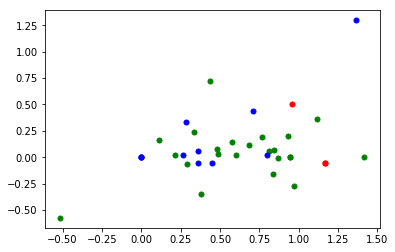

0
人呢 人了 客服人呢
1
有人吗 活跃 汪 你是无语了吗 你无语了？ 咋了 汪汪汪 在不在 有人回我吗 哈喽哈喽有人吗 你一直在线吗
2
出来 我回来了 你不理我 不理我？ 还以为小来不理我了呢 刚刚为什么不理我 你也不理我 你怎么不理我 你最近咋不跟我说话了 今天不回我了 你是不是不想理我了? 我为什么老是被人骗了 咋不说话了 你为什么不理我啊? 想来你怎么不说话? 不理你了 小来你倒是说话呀 怎么不理人呢 说话呀 小来你干嘛不跟我说话 不能不理人的 为什么没人回答我的问题 怎么不理我
21.103011985831337


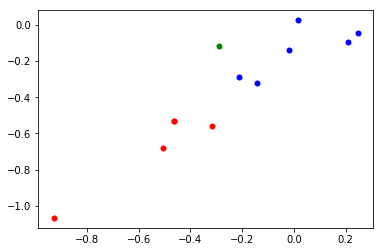

0
叫爸爸 叫我爸爸 那叫爸爸 我是你爸爸 爸爸
1
叫你一声你敢答应么 你以后叫我爸爸 以后要叫我主人 以后叫我大王 好吧以后就叫我主人不叫我大王公 能否请你叫我一声爸爸
2
叫个爸爸
4.695239944250745


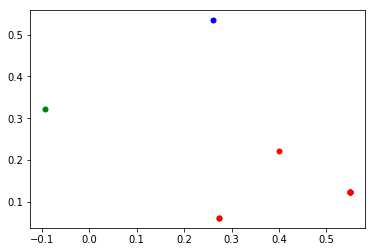

0
好久不见 好久不见了 好久不见阿 好久不见啦 好久不见哈哈 哇,好久不见 来也,好久不见 好久不见你啊
1
小来小来好久不见
2
好久不见需要帮助
19.0414303922


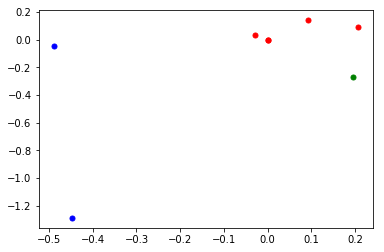

0
来宝 来哥 亲爱的你好 宝贝儿 哦哈妞
1
宝宝 宝贝
2
小哥哥
2.188310155453088


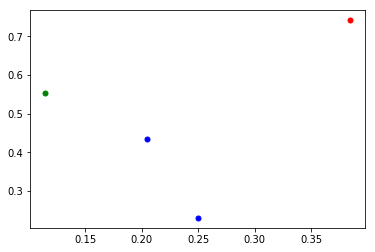

0
中午吃的啥
1
你今天早上吃了什么啊? 中午吃什么
2
午饭吃的什么小来
73.82261742171477


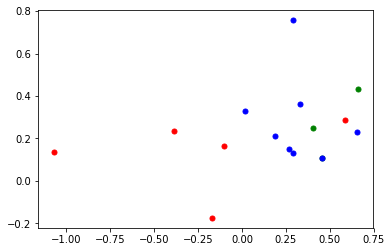

0
那你觉得什么最好吃 什么好吃 晚上吃什么好吃的? 能推荐吃什么东西吗 推荐几个好吃的东西给我
1
中午吃啥好呢 小来中午吃啥 不知道吃什么 不知道吃啥 晚上吃什么 今天晚上吃什么饭 你想吃什么 没吃呢/::L
2
推荐给我几道菜 午饭有没有推荐 推荐午饭
5.224280748865628


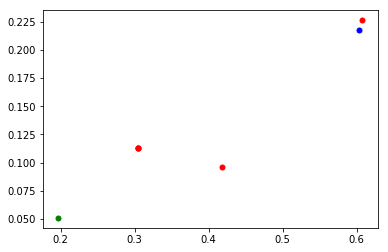

0
你饿不饿 你饿么 你饿吗? 你饿了啊 饿吗
1
你上不上学
2
那你不困啊
28.26736774866583


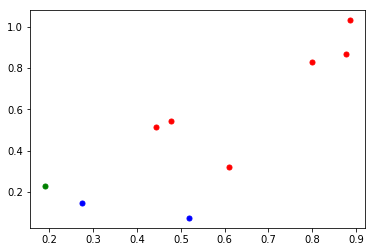

0
你们忙不忙的呀 现在忙么 现在你忙吗 都忙什么呢 今天忙啥了 忙完了吗
1
最近好忙 这段时间太紧张了
2
最近怎样?
739.8978101888748


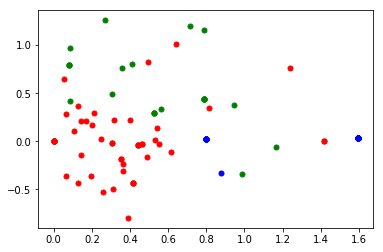

0
有人吗 喂 hello? 睡了吗 有人没 你好 这是哪位 你好,助理？ 你是几号来 哈哈你好 你的编号？ 你编号多少 哪位？ 你是刚刚哪位么？ 那你是几号 你的 哪位 你是哪位? 你是几号小来 你是几号呀？ 你是哪位 你是几号小来呢 您是哪位 编号多少 你是几号呀?? 你有编号吗？ 哈哈，是哪位呢 你是小来编号几？ 你是编号多少啊 我不要真人,就要机器人 看看有没有人回应 嗷 感恩节是几月几号? 在吗?每天都偷懒 來也在嗎 有人在吗 咨询点事 来妹妹 来儿 不理我 今天你要罢工? 小秘书 秘书在不在 小来哥~ 你还活着吗 有人可以直接沟通吗 小来你罢工了吗 你不理我我要生气了 亲, 还不理我 Hello
1
在吗在吗 在嘛 你好在吗 亲在吗 亲，在吗 在吗? 在么 在 在? 在不 在不在 还在吗 亲,在吗 你在吗? 你在吗 在啊 在么? 你好在吗？？？ 在不在? 在吗 211在么 亲 ~在吗
2
小来，在吗？ 人呢 小来? 小来在吗 小来,在吗 小来,在吗? 在吗小来 助理在吗 小来。 小来,助理 助理助理你在吗 我的小来 小来来 小助理 小助手 小助理在不 小来在嘛 小来∼ 小来你在吗 来人啊 没人在嘛 小来在线吗 在吗小来?
153.79037652202322


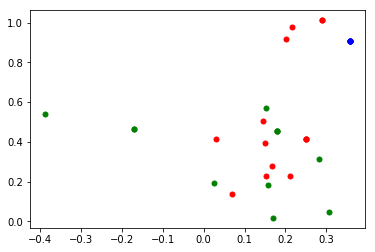

0
吃饭没 你吃饭了没 吃饭了没 吃饭没? 助理吃饭没。 你吃饭没,美女 你吃饭了吗 吃饭了吗吃饭了吗? 小来你吃饭了没? 吃饭么 有没有吃饭呐? 你吃饭没有 小来你们吃饭了吗 你吃饭不
1
吃了吗 吃了吗吃了嘛 吃了么 吃了么? 您吃了么
2
没吃呢? 早饭吃了吗? 你吃了吗 你吃了么 你吃了么? 你吃完了么老大 小来,中秋节吃月饼了吗? 我吃完了 小来你吃了吗? 你吃早餐了吗? 吃早饭了吗 吃饭了吗。吃的什么好吃的
192.94452751146827


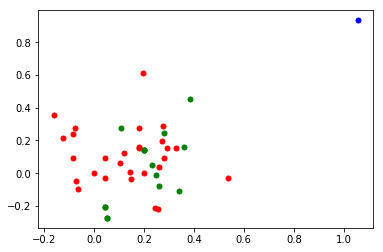

0
我有个奇怪的需求 小来我想问个高级的问题 我能帮别人解决事情,但我的事情我不知道谁能帮我 助理问你个事? 小来,帮我回答个问题好吗 小来问你个事儿问你个事 问个事情 小来请你回答我很多问题 你随时可以问问题吗? 麻烦你点事可以不 那我想请问一下 你能回答什么问题 你可以帮我一个忙吗? 快回答我 我问你什么问题你都可以回答吗 我问你的问题你也没办 我有疑问 我有一个不成熟的小请求 我想请教个问题可以吗 我能问你一个问题吗 /:B-)/:B-)这就不会回答我了 你问 我不离开我问你一个问题 我想问个事 我在问你问题你怎么不回答我了 我有一个困惑能帮我解决吗 请教你个问题呗 问你话呢
1
咨询
2
问你个问题 我问你个问题 问你个问题哈 想问你个问题 咨询你一个问题 有问题问你 我问你一个问题 小来:有问题 我问你一个问题可以吗 问你一个问题 问你一个问题嘛 我有个问题 好的 还有个问题 有问题怎么咨询 油不油这个问题
76.89996981404742


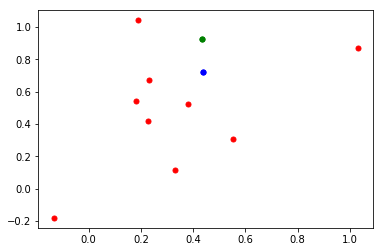

0
陪我聊天 咱们可以对话了么 baby 不能在这说话吗 我只是想跟你聊聊天 不要自助服务 想聊聊天 就想聊天 我想和你聊天 可以和你聊聊吗
1
说话 说话啊
2
聊天 聊天么?
537.088569873412


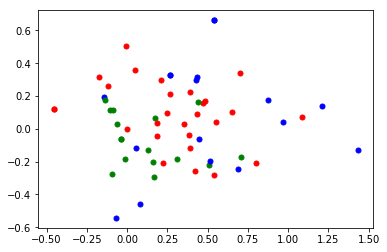

0
我来了 睡醒了 已经起床 其实老早就起床啦 我五点就醒了 起了 我早就起床啦! 你醒啦 我老早就起来了 我刚刚睡醒了 怎样克服起床困难症 我6点半就起了 今天是真的才刚起[Facepalm] 我六点多就起了 亲  我来了 我忘了  早都起床了 早安我刚刚出去吃 我在赖床 忘记打卡了[Facepalm]早就起了 有木有觉得我今天起来特别早 对不起我已经睡醒了 谢谢 我老早就起床啦/::D 刚刚起床了 已起床 我醒了 起这么早做什么 我起床时间都挺早的
1
我起床了 起床啦 俺能记住了，起床啦 下班了 起床了 醒了 起的晚 宝贝起床了 今天晚啦 我都起床5个多小时了 宝宝起床了 早起傻一天 猪起床了 起床很早呀 起床啦!来友 早好起床啦 美儿起来晚了
2
起来了 不是我刚起来 我起来工作了 我起来了 我已经起来了 我是起来了 我早就起来 我已经起来了好吗 我都起来3个小时啦 我早上起来打卡了。 你才起来? 好早就起来了 才起来 起来啦 已起来了 我刚起来
109.20848315375956


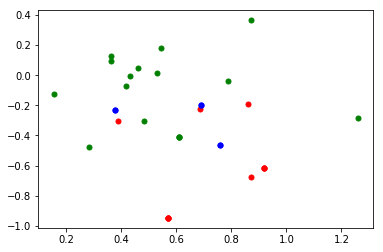

0
干嘛呢 在干嘛 在干嘛呢 在干嘛? 干嘛呢呀 在干嘛啊，小来 小来干嘛呢 来，在干嘛 干嘛? 干嘛 发这么多干嘛
1
干啥呢 你干啥 你干啥了 你在干啥 你在干啥子哦 干啥呀
2
你在干嘛 你干嘛呢 你在干嘛呢? 你在干什么 你在干什么啊小来? 你在干嘛呀 你在写什么阿 早。在忙什么的了 芳在干嘛呀 你们都在想什么 你在做啥子呢? 你在干吗你在干吗 在在干嘛 在干哈呀 小来 你干嘛呢 你在幹麻呀
41.93915321958534


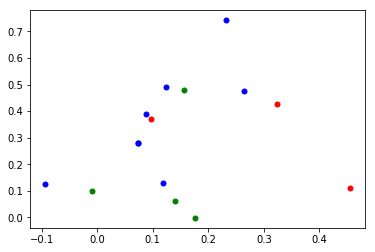

0
今天吃什么 不知道吃什么 吃什么
1
晚饭吃什么 午饭吃什么 早餐吃什么 午餐吃什么 晚餐吃什么? 晚餐吃什么 午饭吃什么最好 吃午饭
2
晚上吃点什么? 今天忌什么 今天吃什么最健康 我问你  今天吃什么好
55.45201156079207


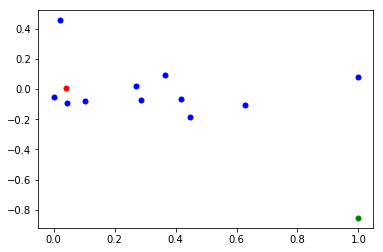

0
想我没
1
你平常都干什么 小来你在干什么 你正在干什么? 你干什么呢? 我在上课你在干嘛 你们自己研发的这个功能? 你在干什么啊 在干什么呢? 搞咩啊 你有没有结婚 你要手机号干什么
2
我猜不到
0.0


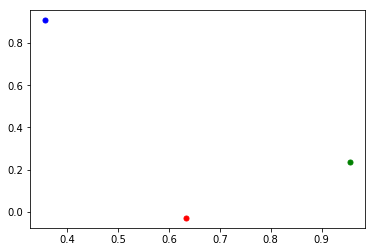

0
小来,我邀请了两个人,完成了补签
1
吃了
2
可以用了
31.241920766539284


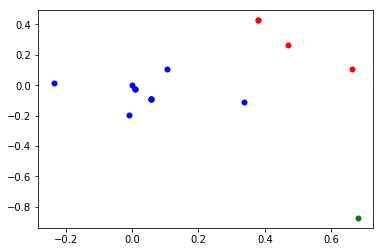

0
你多大啦？ 小来你多大了 小来你多大啦 你猜我多大了
1
你多大岁 那你几岁 你几岁? 你几岁啦 行,你几岁? 小来几岁? 你几岁了 你猜我几岁了 你才22岁？ 你多少岁了呀 你多少岁 嗯你多少岁
2
多大了
48.613198880964234


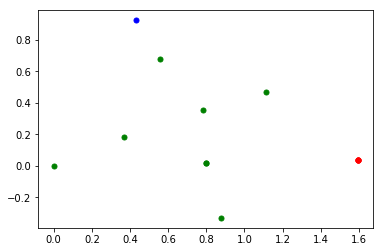

0
还在吗 在吗 您好在吗 你们在吗
1
这还聊天吗
2
你还在么 来还在吗 还在不 还在叫吗？ 助理在不? 她不在了 下午好!在吗 在吗?怎么不回话
350.8342841986158


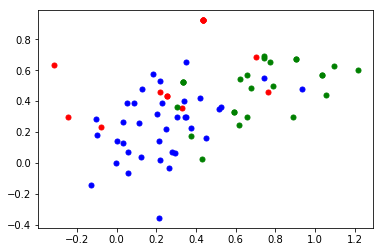

0
可以聊天吗 和我聊天 我要聊天 你能跟我聊天吗? 那啥时候能聊天呢 聊天吧 在跟我聊天呀 聊天不 这还聊天吗 能不能聊天 能聊天吗 聊天你 我们聊天吧 跟我聊天233
1
聊会天 你怎么不说话? 我可以经常和你聊天吗 没有需求就不能找你了啊 找你谈天 就找你聊聊天 [domain1010]你会聊天吗 说点别的可以吗 我就喜欢和你聊 因为你不主动找我聊天。 想找人聊聊天 能跟我唠嗑吗 你一天聊天死啦 你也可以给我发语音啊!没事陪我聊一下天 我想找妹纸聊天 我可以和你说说心里话吗 没事  我就和小来聊聊天 像我男朋友那样跟我聊天行吧 没天跟我聊聊天 那你先找话题 我想问你们有得聊天吗 跟你聊天我会挂掉的 我打字你看见吗 聊几句 这个东西应该也能聊天儿吧 这个要是有可以聊天的功能就好了 那我无聊的时候也可以找你聊天的 那我有时间可以找你聊天吗 那不跟你聊会 你会跟我说话吗 你跟我说会话吧 无聊想和你聊聊天 我可以撩你吗 你还能说啥 心情不好 陪我聊天 可以让恋人找我说话吗 唠嗑 唠会儿
2
陪我聊一会儿 你陪我聊天吧 陪我聊聊天 聊聊天 聊聊 陪我聊聊天吧 可以陪我聊聊吗 陪我聊聊 陪聊天[Smart] 陪我打电话 陪我聊会可以不 可以陪我聊会儿天吗 小来可以陪我聊聊天嘛? 聊聊天吧 我很寂寞可以陪我聊天吗 要不陪我聊会 可以跟我聊聊天 我不开心你陪我聊 聊会儿天 可以聊聊吗 可以陪宝宝聊会吗 你会陪人聊天吗 陪我聊会儿天儿 你陪我聊什么 能聊聊天吗
14.152828912735954


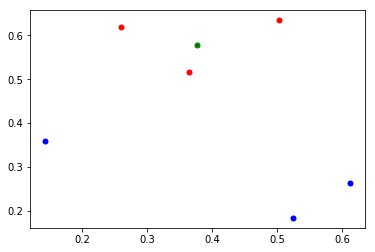

0
小来下午好 下午好 下午好啊来
1
下午好哈 只是跟你打一下下午好 问候一声觉悟下午好
2
打卡下午好
286.6012223746814


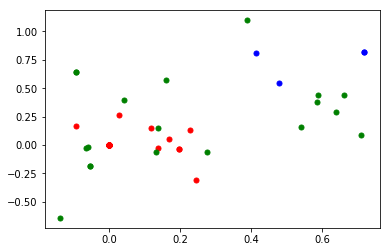

0
哈喽 你好 您好 亲 小来,你好 喂喂 你好。 謝謝。您好。 嚓啦嘿哟 哈啰 报到 你好呀 你好啊 哈咯 蓓蓓你好 你好? 喂喂喂喂喂喂喂 你好哟 哈啊呢 你好嗎 你好啊 /::) 你好( ^_^)/ 哈喽/::D 您好张哥。 哎你好 hello你好,请问可以听得见吗?
1
小来来 哈喽啊来 来 来来你好
2
嗨 小来你好 哥 打招呼而已 我只是打招呼 哈喽美女 哈喽麦奶奶专家 喵 小来，很高兴认识你 高兴 大家好 嗨咯 哈喽大家好 蓓蓓 很高兴认识你 哈喽哈喽有人服务吗? 老客户了亲 我只是试一下 你好朋友
19.597121437641533


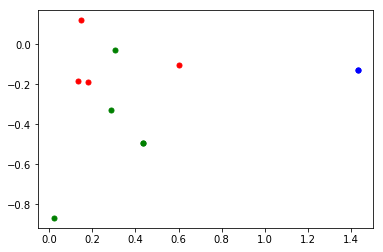

0
嗨!晚上好 小夏晚上好 美女,晚上好 亲爱的家人们晚上好
1
晚啊 那么晚
2
晚上好 小来晚上好 亲,晚上好 哈喽!晚上好 宝宝晚上好
7.848917748152597


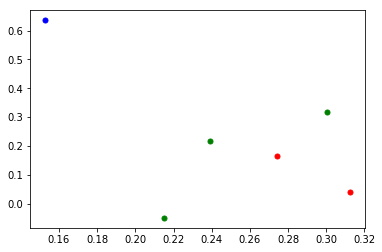

0
中午好 彪彪中午好
1
午饭
2
中午好小来 hello,中午好 甜甜中午好,
47.489623586601866


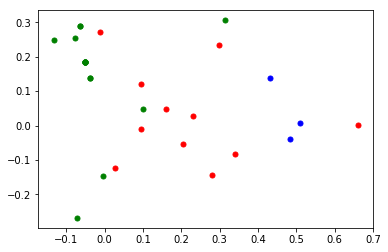

0
想念某人 小来,你能帮我告诉她,我很想她吗? 每天想你很多遍 珊珊我好想你 说一遍   你想我了 我放不下你 小来 想你 我也是  好想你哦 不爱你了 突然好想你 我想一想哈
1
我也在想你哦 你知道我在想他吗 有在想我吗
2
我想你了 想你 想你了 我想你 老婆我想你了 我想我老婆了 我想TA了 好想他 杜杜我想你 想你时怎么? 我也會想你的 我也想你呢 我会想你的 我很想你啊 好想好想你 我也会想你的!小来!爱你么么哒
5.052699398632473


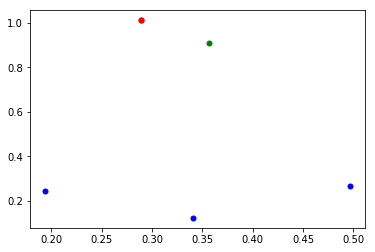

0
吃饭了吗 吃饭了
1
吃宵夜了吗 姐你现在吃饭了吗 想来你吃饭了吗?
2
吃吃吃
9.179965777989633


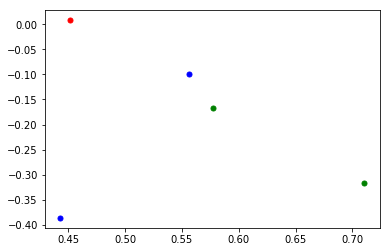

0
我在做什么
1
我妈妈在那 我的邓先生在干嘛呢
2
我在干什么 你猜我在干嘛呢？
238.96491907749956


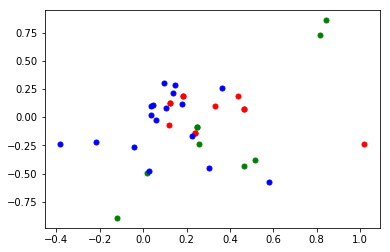

0
生日快乐 小来生日快乐 生日快乐, 生日快乐! 祝你生日快乐 生日快乐小来 生日快乐,小来 小来,生日快乐 生日快乐卡 祝我生日快乐 节日快乐哈 那也祝我生日快乐吧
1
Happy birthday to my dear baby 不送我生日祝福么 好的好的好的周末快乐啊 hello。goodmorning super sunday。 今天什么节日 今天是什么日子 谢谢谢谢!哎是吧是是我妈的生日啊 万圣节 12月12日生日祝福 today is my holiday。 万圣节是一个不干净的节日 万圣节有没有糖 中国人过什么万圣节? 今天是万圣节 你祝福我一下 冬至快樂 小來 2月14日情人节杜老师的祝福
2
七夕快乐 儿童节快乐 教师节快乐 七夕 父亲节 假期愉快 祝假期愉快 万圣节快乐~ 万圣节快乐
49.867185640191025


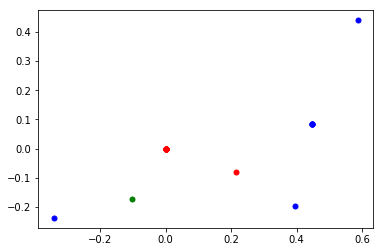

0
哈哈哈哈哈啊哈哈 哈哈 哈哈哈 哈哈! 哈哈哈啊哈哈 !!! ! 那哈哈呀哇哈哈!哇哈哈呀哇哈哈 嗯嗯,是了是了,哇哈哈哈哈哈哈哈哈哈!你是色哇哈哈哈哈哈 哈哈
1
哈哈哈哈哈哈哈哈哈哈 哈哈哈哈哈哈哈哈 哈哈哈哈 哈哈哈哈哈哈哈 喵喵 哎呦 笑屁
2
咩咩
55.06821523711997


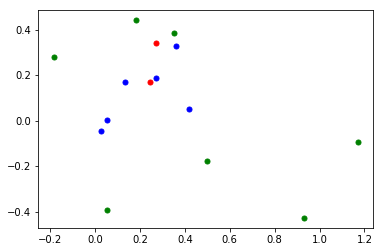

0
我很开心 开心
1
王老师,早上好。祝你天天开心。 好吧   你开心吗? 你开心吗 原来你会回我哒,好开心 好开心 乐死我了
2
我要上天 我谈恋爱了 开心过好每一天 不爱我了么 还是小来想着我 我好像爱上你了 你喂我!!
26.976012821952782


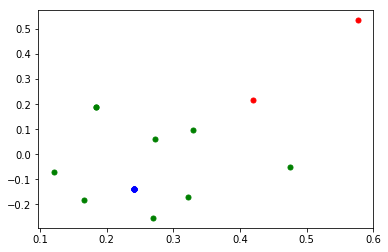

0
来来生日快乐 来也生日快乐
1
生日快乐 生日快乐哦 生日快乐啊 生日快乐哟 生日快乐! 生日快乐哈 生日快乐。
2
祝你生日快乐 两岁生日快乐 小来生日快乐 生日快乐, 生日快乐小来 生日快乐呦 小来们生日快乐 妈妈生日快乐身体健康 祝群主生日快乐
0.0


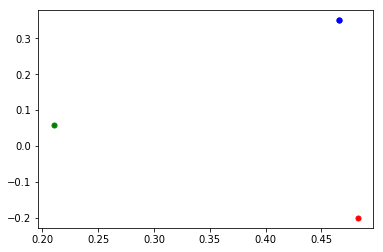

0
嘿嘿
1
嘻嘻 嘻嘻嘻
2
嘻嘻哈哈
8.77598235207222


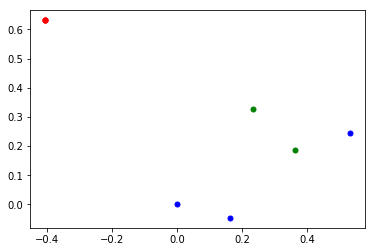

0
心情好 心情好嘛心情好 心情好?
1
啦啦啦 我现在现在心情好,我早起十个脚本中了仨俩 今天感觉很受宠
2
祝你有个好的心情早安 天天有好心情
58.77280920169913


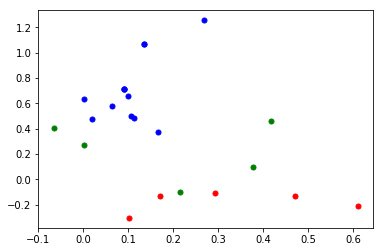

0
滚 草泥马 滚 滚犊子 滚婊子 草泥马
1
去死 你去死 可以去死了 你去死! 死哪去了 我让你去死 奴才去死呢! 你可以去死了 那你去死好了 你才是去死呢! 我说你去死! 你才去死呢! 助理来也去死
2
我看看你怎么能把天聊死 把你聊死更好 你会对我好吗 叭!你死了 对 经营好自己
0.0


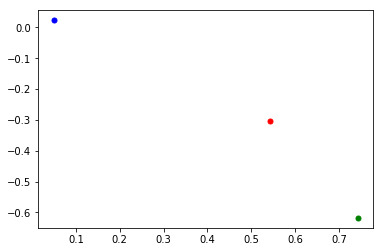

0
呵呵哒
1
羞羞的铁拳
2
呵呵
123.3451640035965


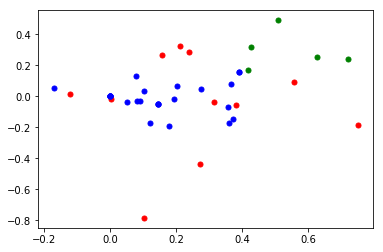

0
我就欺负你 你会说别的吗? 怎么欺负你啊?这话说的 这么懒的小编 废话都说一遍了好不好 调皮 我… 你们肯定没有漂亮大姐姐喜欢吧 你咋就那么恨我呢 你是不是不爱我了 晒屁股了才起床
1
哼 哼哼 略略略 咯 略 你这就有点装逼了 打一千万到我卡上 ... 装逼 答不出了吧 我对你百依百顺 你这么对我? 你没有新的词了吗? 露馅儿了吧 你又调皮了~ 给你个白眼 你是不是王八蛋 我一说你丑你就超纲 么你妹子 哼哼哼 略略略 略略略略略略略 略略略略略略 略略略略略略略略略略略略略略略略略 略略略略略略略略略略略略略略略略略略略略 略略 略略 略略略略略略 信不信劳资打死你你个龟孙儿 嗯………………哼∼∼ 大坏蛋
2
不喜欢你了 我不喜欢小来了 不喜欢 越来越不喜欢你了 我不喜欢这句
51.19826078808434


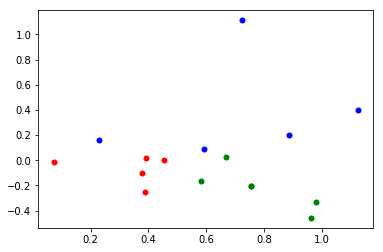

0
你没骗我吧 你们这些就是骗人的在不要给我发这些无聊的东西 骗骗骗!!!!你骗人!!!! 好不好不要来骗我 你骗人
1
你骗我 感觉被你们骗了 怎么老是骗我 又骗我关注公众号? 就知道骗我
2
骗子 骗人 你是骗子 小来是骗子 难道不是骗子吗? 骗人呢吧
164.23531982112155


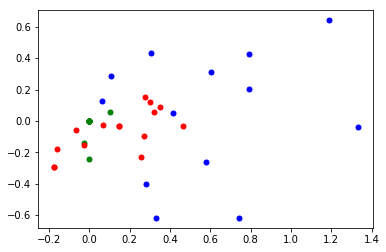

0
你妹的 你妹 爱你妹呀 你大爷 睡你妹 尼玛 少来忽悠我 快乐你妹 睡毛线啊 想你妹 去你妹啊 我可以抱你么 安你大爷 你大爷的 早你妹
1
呵呵呵 调戏我 想我干嘛啊 逗我玩啊 我可以调戏你吗 想我干嘛?我又不认识你 不认识 逗我 逗机器人玩/::D 干嘛学我 这个游戏小孩子不能玩哦 叫我干嘛 不能玩算了
2
切 呸 少来 噢 哦。 。 。。 。。。 你特么的 ...... 叫你妹
60.495356993882865


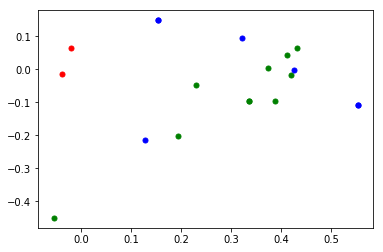

0
没明白??? 你不明白
1
你知道不 你居然不知道 怎么不知道 你怎么什么都知道啊 你知道个屁 你怎么什么都知道 你知道什么
2
不告诉你 哈哈你不懂 你能懂不 你咋不理解 我就不和你讲 老子就不 不理解就对了 不对 叫我女王 懂你的人不言而喻 不懂你的人百口莫辩 看不太懂
26.121236099680644


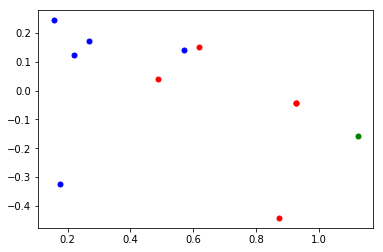

0
打他 想打你 可以把你打到流鼻血吗 打你 可以打你吗
1
我想打人 我想知道你会不会打我 我想揍人 你他妈找抽 打人是不对
2
欠打
225.84943809078186


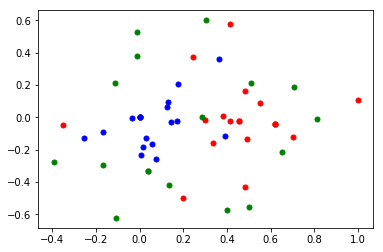

0
傻逼。 你妈逼 傻逼 傻逼？ 你傻逼吧 你是傻逼吗? 你他妈的傻逼呀 傻逼草的 傻逼滚开 你是傻逼吗 傻逼逼疯了 你这个傻逼公众! 你是大傻逼 怎么能是傻逼复查ct 傻屌 尼玛老逼 你个二逼 操你妈 知道了 这个逼逼啊 我没叫车!傻逼
1
SB Fuck you 我屌你老母 信球八叉 草你妈妈 吃屎吧你 顶你个肺 你个sB 你他妈来的 傻王八你是 你今天必须吃屎 靠你妹妹 滚开 那你买皮操你妈啊你咧咧咧什么咧 日你麻卖批 王八蛋 你妈个逼得听不懂 去你妈的鬼天气 你伟大个屁
2
麻痹 操你妈 机器人也都会生气啊 傻逼年年有今年特别多 我想骂你 你妈的 不要脸 不要傻B一样的回复我问题 你会不会骂人 我又不是骂你 去你妈 操你妈垃圾 怎么想骂个人怎么那么难 今天好生气啊 有病 去你妈的 滚说了多少遍
2.8516552263139703


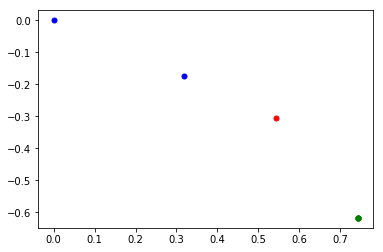

0
呵呵哒
1
呵。 呵呵红红火火恍恍惚惚
2
呵呵 呵呵呵 呵呵呵呵呵呵 呵呵( )
77.464966848374


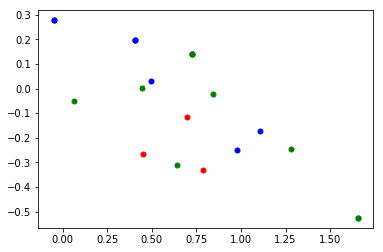

0
额，我按错了 亲,我按错了 错了
1
点错了 不好意思，按错了 按错了，不好意思 中午好不好意思点错了 不好意思了 不好意思! 我点错了……
2
发错 发错了 打错了 按错了 按错了 按错了 按错了,帮我撤销 我错了拉 我按错键 刚才点错了不小心删除了
14.776962394017746


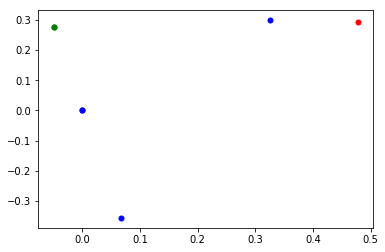

0
抱歉
1
打扰了 不好意思我在忙,稍后给你回复! 打扰 不打扰你了
2
不好意思 不好意思哈
2.927044166556122


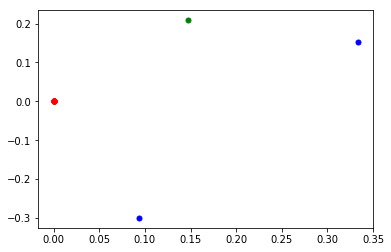

0
麻烦了 麻烦你了 麻烦啦 麻烦 麻烦你啦 麻烦您了 谢谢 麻烦啦
1
好的,麻烦了 好的,谢谢,有你们真好/:@)/:hug
2
我们在尝试功能,谢谢
25.01355537793315


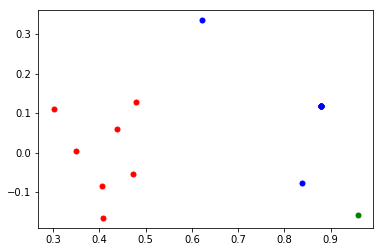

0
我对不起小哥 对不起你 对不起对不起,我手滑摁错了 今天六点不到去公园了忘记打卡,对不起! 小来对不起我妹妹不东是 对不起说错话了 我对不起你我不应该骂你
1
对不起 对不起对不起 对不起哦 哦哦对不起 对不起啊 对不起哈 对不起错了 对不起小来
2
对对对不起
883.7061605305125


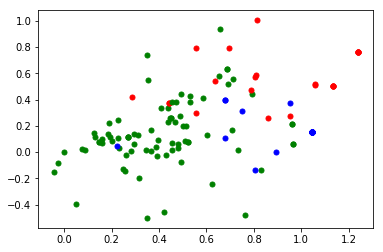

0
睡觉 睡觉了 睡了 早点休息 睡 睡吧 还不睡吗 好的,早点睡~ 好的,早点睡了 我还想睡 我能几点睡呢? 再睡一会儿。 那睡觉吧 马上睡 我睡} 那我还是睡吧 我现在准备睡觉 你们睡吧 早点睡了小来 我睡觉了 哄我睡 睡觉啦 早点睡吧晚安 嗯嗯。早点睡啦∼
1
晚安 晚安啦 晚安小来 晚安咯 晚安了 晚安晚安 晚安～ 晚安哦 晚安吧亲 亲爱的晚安么么哒 晚安~小来 晚安^_^ 晚安∼ 晚安吧 晚安亲爱的 么么 晚安~ l晚安 晚安我的一切 晚安宝贝 晚安/:moon 晚安喽 明天见!晚安啦 晚安/::)
2
安 好梦 晚安,小来 好,晚安 小来,晚安 这里没有末路,你从不曾孤独。么么哒,晚安 我可要睡了 我困了 晚安，我会想你的 我唾了 我他妈现在是刚睡着 好的 睡觉了 晚安,做个好梦哥 你要睡觉了? 晚安,祝你找个好嘛 吃饱了,准备睡回笼觉。 睌安 安～ 你没有告诉我你会想我的 Goodnight 那你大妈,我我先睡了啊 没事,早点睡,明天会更好 助理来也晚安啦 晚安味 安安 晚安小来来∼ 小也，晚安咯! 祝她好梦 小来也要早点休息哦 晚安了朋友们买吗? 晚安!祝小来也好梦~ 晚安撒 别催了,马上睡 睡着了吧 睡着了吗 再等一会会就睡觉啦 快去睡觉吧 我困 '安 没有失眠!! 你也去睡/::D/::D 好梦(  ω  ) 晚安安 晚安  最爱的人 来来 睡觉 晚安宝贝/::Z/::Z/::Z 晚安么么达 嗯嗯晚安祝好梦 晚安   来也 你傻吗? 晚安啦 傻逼 晚安啦 晚安!咱来 晚安 有道晚安么 打睌安 晚安个头啊 其实我是刚要睡 晚安小帅哥/::D/::D 本小主也很想早点休息 '安安安 晚安我也会想你的 大爷睡觉了 你困不 晚安我想thomas chong 晚安 我会想你的 爱你 么么哒 晚安 晚了个安 爱你的晚安 晚安咯   十二 晚安 好梦 爱你晚安∼ 我困了我要睡觉啦 晚安懂吗 晚安辣 晚安 /:moon/:moon[小狗][小狗][小狗] 晚 安 晚安世界真的很累 朋友 晚安 你睡着了么 晚安,愿你有个好梦! 晚安啦,亲们。明天继续打卡。 (′-ω `)晚安
60.58935747335208


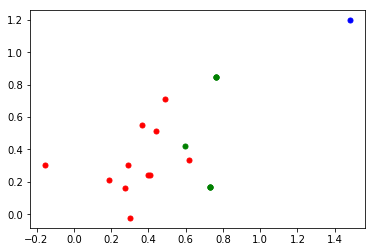

0
我也会想你的 你忙吧 拜拜,小来 和你说拜拜啦! 没有帮上忙 拜拜 Bye~ 谢谢小来 等你/:rose 不和你说啦!我要走了 你们这个平台不玩啦拜拜 没得聊了 下午见吧 朋友 好啦!没有事情了。我先下了。再见!
1
快休息吧
2
拜拜 再见 好拜拜 再见了 拜拜了您 拜拜啦∼∼ 那再见啦
124.6023524652354


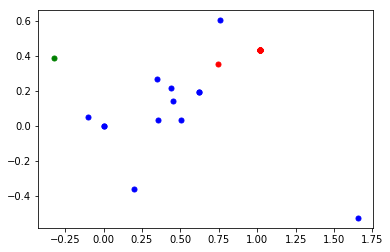

0
没事了 没事没事 没事没事! 没事没事。 没事没事,我去看看吧 哦没事 没事呀 没事 没事的 没事哈 没事。 没事啦
1
没关系 不着急 没事儿 没关系的 没啥 没什么 对不起啊!我试试是不是真的会回 没事已经打上了 没事就拜拜 算了不玩了 没事 嘿嘿 不行就算了 发错了/::~
2
没什么事情
60.15519601643378


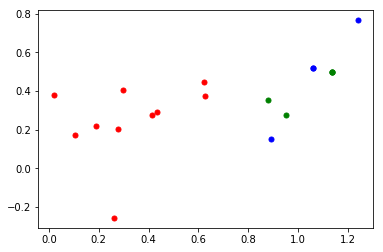

0
我要睡觉 睡睡觉睡觉去. 晚安，我会想你的 小来我要睡啦 要睡觉了 不行我睡觉去 我要睡觉了辣鸡 你也去睡觉吧 我说我要睡觉 打完就睡
1
我一会睡 我真的睡了哦 睡我 睡啦
2
睡觉睡觉 睡觉 算了算了睡觉了睡觉了 睡觉睡觉喽! 我睡觉
159.8592540479869


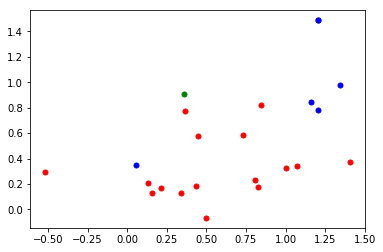

0
好了,我继续去做工资表 其实我都上班好半天了 在上班的路上 谢谢,我工作了 我要睡到两点 我去上学了 还在上班呢 不睡了 我要通宵 我天天都很早上班 我去吃饭了 而且导致我上班迟到 /::)。我去洗牙 我在洗澡洗衣服/::< 你可以退下了 我上班 额,我在上班
1
上课 我在上课 在上课 上课中 上课了 我要背英语了
2
吃了
0.04466072985866666


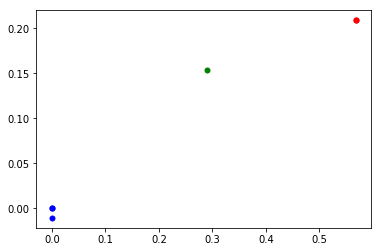

0
good bye good-bye
1
bye～ byebye bye-bye
2
see you
12.794242194306538


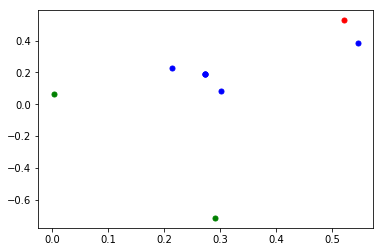

0
哎我现在忙了不聊天了
1
闭嘴 你闭嘴 你闭嘴吧! 你给我闭嘴 好了,闭嘴 啊你快闭嘴吧
2
不说了 我不需要什么服务
153.59174894496402


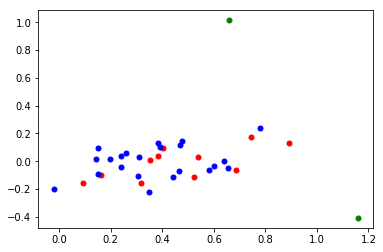

0
别再给我发消息了 不要给我发消息 以后不要给我发消息 别给我发消息了 少给我发消息 不要再给我发消息了好吗 以后你不用给我发任何信息了 能不能不推送消息 等不能不要一直推送消息?在推送取关 不要给我发信息了 我不要求不要给我发信息
1
能别老这么早给我发消息嘛 你别抱歉了,不要再给我发信息了 我很快乐，请不要再说爱我 少骚扰我 你可以消失了 再不要给我发了打扰到我了。 不要打扰我 就是最温暖的行为 你为什么骚扰我 知道了!不要再发消息了 这个能不能不要自由推送 能不能别发了 有需要找你  不要天天给我发 不要给我发(四川早起小分队)了好吗 你可以滚了 其他人的我会,我就是想开启助理来也的免打扰没有找到 别再用提示音打扰我! 别老发信息 没事吧发那么多条 天天吵吵 你一天给我发那么多信息干什么? 跟吴无关的任何信息不要再发给我 不要再给我发别人的晚安信息了,拜托拜托
2
别通知我了 信息免打扰
138.86617917940634


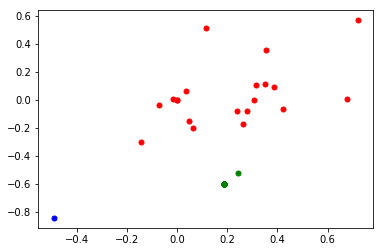

0
好哒好哒 好呀好呀 知道就好 好哒我会看书哒 愿你我都越来越好 好，你讲吧 好的 知道了 你回的好快 芝士蟹煲好好吃 Ok 嗯嗯 有需要随时联系哈 你明白就好 好的 收到 好的，我找找看 好吧 明白了 ╯^╰ 好吧 谢谢 好滴好滴 好的 我知道了 谢谢 ahhh 好的
1
嗯嗯一定
2
好 好的好的好的. 好啊好啊太好啦 好的好的好的 好啊好啊 好的好的 好吧好吧 好嘞好嘞 很好很好 好啦好啦 好的好的! 好的好的. 好吧 好啊 好吧^_^ 好的 /: 喔噢 好的 好噢
19.1220829726898


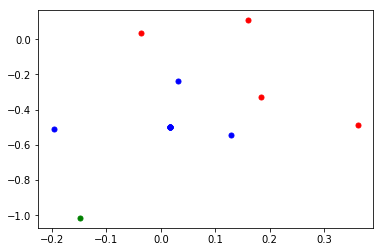

0
你是一條狗 你是大笨猪 就叫你笨猪 你是撒比
1
你是猪 你是猪吗 你是猪哈哈 你是猪么 你是猪啊啊 哎!你是猪. 小来你是猪吗 他这个猪现在才起 你是不是猪
2
猪
57.42285676194082


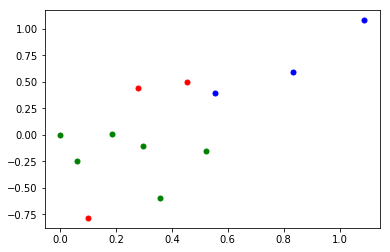

0
我去 我想日你哟 我靠
1
我日 日 我日你吗
2
操 艹 操你大爷 那我想干你 你神经病 操你妈/:dig/:dig
91.06298386164809


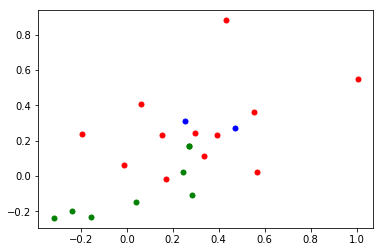

0
做爱好玩吗 我想和你睡觉,我想和你睡在一起 你要做爱 我要做爱 可以陪我文爱吗? 做爱 你知道怎么做爱吗 我想在床上干你 爸爸妈妈做爱的视频 好想和你啪啪啪 你想做爱吗 教我打飞机
1
找小姐 小姐
2
约炮 你麻痹 我要宝宝 什么jb玩意儿 我想摸美女屁股 给我发张裸照 约炮吗 好像强奸你 我想打炮/:v/:v
158.93735262761064


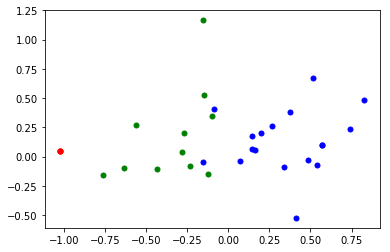

0
垃圾 垃圾东西 垃圾!
1
垃圾，说来说去都是这几句话 不好玩 一点也不好玩 这个软件好难用 软件实在不给力 不好好服务 弱智吧你 来也越来越狗屁 感觉你快挂了 一点也不智能 为什么你这都不理解?/::-|/::-|/::- |你被开除了 渣渣 那我不玩了!你们这个太差了 你记错了吧 你们真垃圾好几张重复 你为什么不讲 算了，简直是对牛弹琴，白费劲
2
有点垃圾 简直就是垃圾 垃圾软件 真垃圾 垃圾,失望 垃圾玩意 滚蛋垃圾 垃圾公众号 你真垃圾 好垃圾的APP 垃圾手机!这么可爱的表情都看不到
1.135368429701152


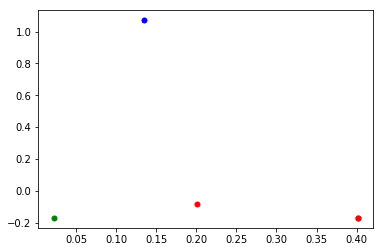

0
去死吧! 去死吧 你去死吧
1
去死
2
全家去死吧/::-S
91.83693288243474


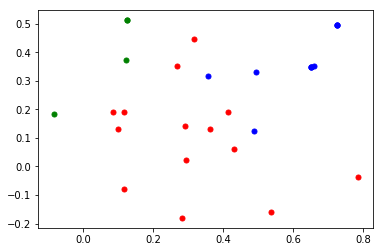

0
诶,没起来, 你咋起这么迟 这么早就醒来了 睡过了 小来,我可能得了懒癌,不想起来怎么办/:: |小来还没起床呀？ 我就没睡过 我只打卡不起床 你每天起来这么迟 我起床你不会跳出来了! 你才没起床 老婆不起床你说怎么办 王蓝起床了没有 还没起床呢
1
起不来 我起不来 我起不来啊 起不来了哟 实在起不来哦 哎!我起不来 起不来怎么办? 小来,早上起不来怎么办 绝望......我早上真的起不来 醒来,起不来
2
不想起床 不想起床哎 我不想起床 都不想起来
112.79765973997206


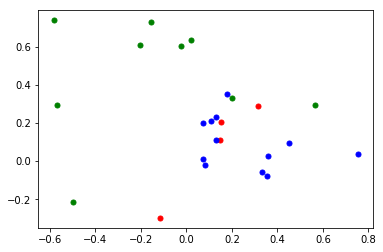

0
我不高兴 哎!不高兴 王不高兴 今天不高兴
1
好烦 烦 心烦 我心烦 最近烦心事真多 烦,烦,烦 我就发发牢骚 我好烦啊 很烦躁怎么办 怎么样才能使每天都是快乐 我好想哭 最近很焦虑怎么办
2
心情不好 最近心情不是很好 心情不美丽 没心情吃 今天心情不美丽 心情不好签 心情超级不好 超级不好 搞的人心情不好
6.139300718578555


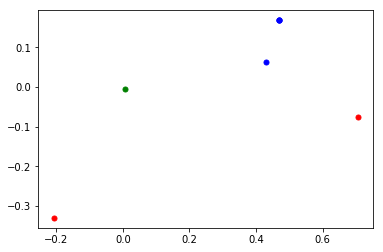

0
我是不是很棒 我的普通话说的好吗
1
羡慕么 羡慕我吗？ 羡慕吗？ 羡慕
2
我棒不棒
58.632353230588095


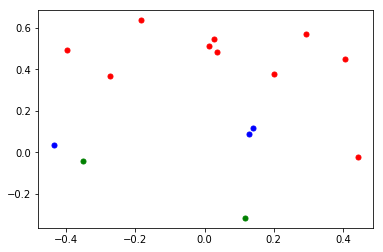

0
我要减肥 我只想减肥 减肥 小来减肥吗 怎么减肥 我想减肥 减肥有办法吗 如何健康的减肥 怎么减肥最快 小来我该怎么减肥
1
教我怎么瘦肚子 瘦肚子方法 瘦腿
2
减肚子方法 怎么减肚子
100.418646559711


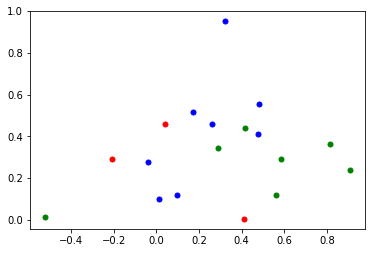

0
早安,加油 加油呀 明天加油
1
小来,我想起来学习了 求鼓励 不想学习 小来 你夸夸我 正在学习啦 每天拼了命学习 怎样才能激励自己学习呢 小来我今年十七岁了
2
小来,你好,阿宝又来上班了 早,新的一天上班辣 要去上班了 早起来了,准备上班了 今天就是新的一天呀 我要控几我技几 开始上班了哦
3.693187844346089


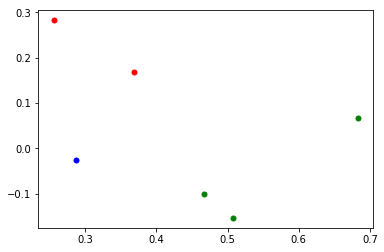

0
我来找你聊天,是不是太无聊了 我是不是一天天太无聊了
1
你这样讲不是太牵强
2
我是不是太讨厌了 我是不是太矫情了 我是不是太啰嗦了??
0.0


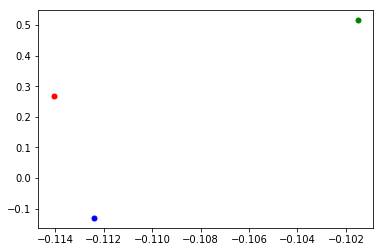

0
哪有小冰的好听
1
我能说超级难听吗？
2
我的声音难听吗?
14.421787984315783


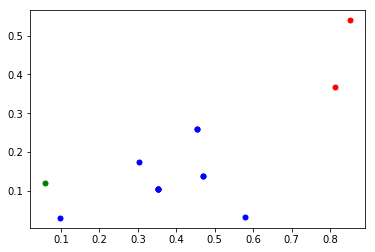

0
原谅我哦。 当然是选择原谅啊
1
你们也别惩罚小哥了,提醒他下次注意吧。 原谅你了 原谅你 原谅你一次 好吧,原谅你了 好了原谅你了 谢谢,原谅 好吧原谅你了 好的,原谅你了 好吧,原谅你 好了,原谅你了。
2
嗯   希望你们下次注意
32.340222912371985


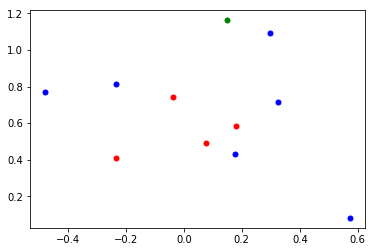

0
我要去练车了 我要上学去了 我要去滑雪场 我要上学
1
我要去考试了 我要考试 去考试 我是去考试 我date去考试了 过几天考试
2
考试
21.92656319019534


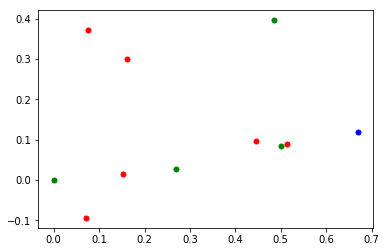

0
你和Siri谁好用 Siri和你关系如何 你比siri好 你和siri有什么区别 你和Siri谁更好 Siri跟你什么关系
1
知道Siri吗
2
认不认识Siri？ Siri 你和Siri谁更强 你和sirl熟吗
76.84599728894807


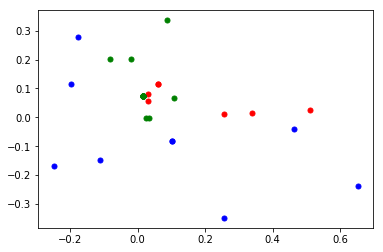

0
你自我介绍一下 自我介绍一下吧 自我介绍 自我介绍下 请自我介绍一番~ 自我介绍下吧/:,@P 你自我介绍下
1
你到底能干什么 你究竟能干什么 你都会什么? 你在说啥? 你都会啥 我问什么你都能答? 请问你有什么功能 那个...你有啥用啊 你可以帮什么
2
你会做什么 你能做什么？ 你想做什么 你是做什么的 那你能做什么 你可以做什么 你帮我做什么 你能做什么呀 你都能做什么 你能做什么呢 你到底能做什么 你究竟能做什么 什么都能帮我做吗? 你能做什么 你都能帮我做点啥?
47.422507868630575


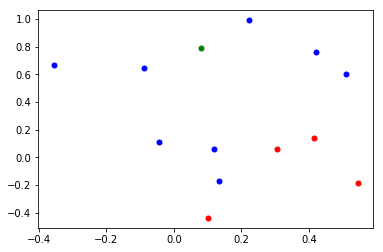

0
你是不是万能的 你真的是机器人吗?我感觉你不是你是一个有血有肉 你是个假的 你不是小来……
1
我要见机器人小来 小来是真人还是机器人? 机器人是不是万能的 现在是机器服务吗 小来你是真人来的吗 我不想要机器人 能不能不是机器人 机器人服务
2
小来……
57.83528399802258


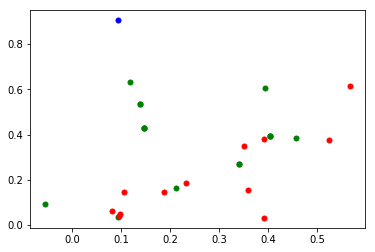

0
你确定不是机器人 机器人,你看图 你是人还是机器人? 你一个机器人你懂什么 不和你个机器人说 你是真人还是电脑自动的 所以你大多数时间是机器人吗 用不着你一个机器人 你是地球的还是外星 这么晚没睡。?还是机器人 你是个人还是 如果可以真想知道机器人背后的是否也是人
1
机器人机器人
2
你是机器人 你是机器人吗 你不是机器人吗 你还是机器人吧 原来你真是机器人 看来你真是机器人 你还是机器人吗 证明你不是机器人 你不是机器人吧 你真是机器人? 你是男机器人还是女机器人还是变性机器人 你真的是机器人么 你就是有感情的机器人 你到底是真人还是机器人 你真的是人工智能不是真人吗? 你一个机器人
19.099129406500662


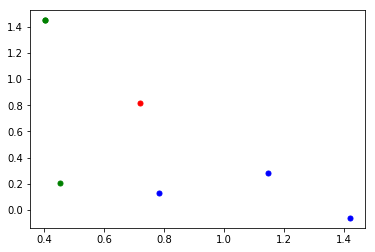

0
来也
1
介绍来也 介绍自己 你可以帮我介绍来也吗
2
助理来也 助理来也助理来也 助理来也现在大约有多少用户啊
2.0616276819953594


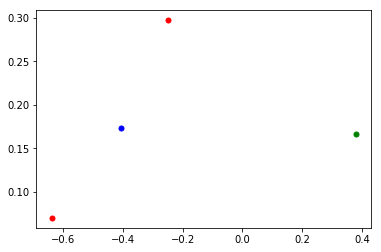

0
你从哪里来 你哪里的
1
你要到哪里去
2
你家住那里
55.67173539771814


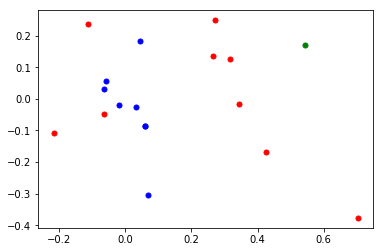

0
你有男友吗 你有主了吗 我想和你交往 我要娶你 我想和你生一堆猴子啊 如果孤单怎么办 我想和你生孩子 我听不懂你说的 小妹妹需不需要男朋友吗
1
你有对象吗 你有男朋友吗 你有女朋友吗 你有对象了吗 做我女朋友 我女朋友了 我说了我有男朋友 女朋友跟前男友一起了
2
和我结婚
31.242704865254673


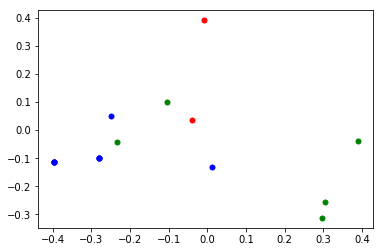

0
小来的生日 你的生日
1
你是什么星座 小来,你什么星座的? 你什么星座啊 你什么星座 你什么星座呀 你是什么星座的? 你什么星座的? 你是什么星座呀 我是双鱼座你是双鱼座吗?
2
你什么时候生日呀 小来你的生日是什么时候 你生日是几号 你几时出生 你的生日是多少
0.0


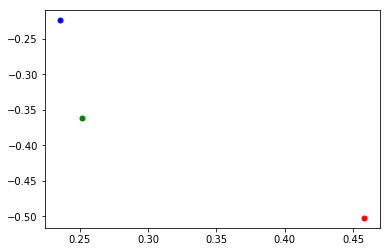

0
你有多高
1
小来,你智商有多高?
2
成功率有多高
106.87942646902852


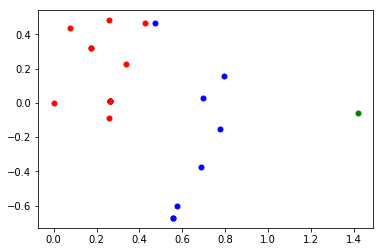

0
小来你是谁 小来是谁 你是谁？ 你是谁 小来那你是谁 你是谁 你谁呀 来也是什么 你为什么叫小来了?有啥寓意? 那你是啥啊? 实验下第一次用/::) 你到底是谁 你会说话呀 你是你是( )
1
主要是干嘛呢 这个是真的可以用吗? 我第一次用 你们是干嘛的 这个是干嘛的 这是干啥用啊 助理来也能干嘛 这个是干嘛用的
2
介绍
2.815667415472161


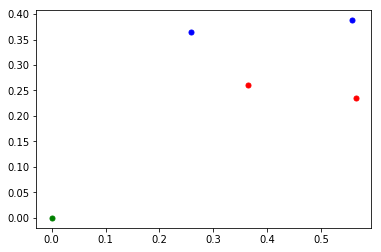

0
你跟小冰熟悉吗 认不认识小冰
1
知道小冰吗 小冰是谁
2
你跟小冰熟么？
11.192090179464223


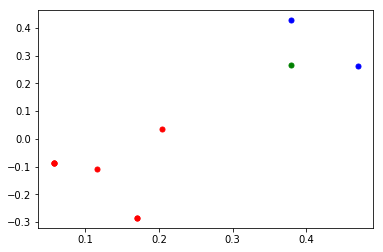

0
你几岁啦? 你几岁 嗯下来你几岁了你多大了嘞 你今年多大 你属啥 你几岁啦 你今年多大了
1
你多大了 小来你多大了
2
小机器人。你多大了
40.92888769407601


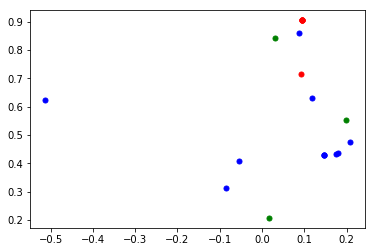

0
机器人机器人 机器人就是机器人 机器人 机器人啊 机器人呢 机器人机器人机器人机器人机器人person,哈哈哈哈哈哈哈
1
有机器人吗 我要机器人 我是机器人 你是机器人啊 你是机器人吗 你是机器人? 你是男机器人还是女机器人还是变性机器人 我想要机器人 笨笨机器人 机器人小来 机器人有没有
2
机器人不用吃饭 机器人都会吃饭吗? 你好你吃饭有没有了
15.851996377991872


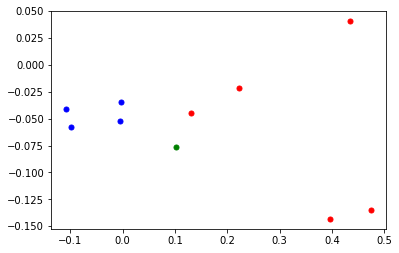

0
你们CEO哪位 汪冠春 今晚才知道我们的大boss原来是学霸啊 你们老板娘姓啥 汪冠春是坏人吗
1
你们老板是谁 你们老板今年几岁 你们老板叫啥 你老板是谁
2
你们公司的CEO是谁?
34.77567692832147


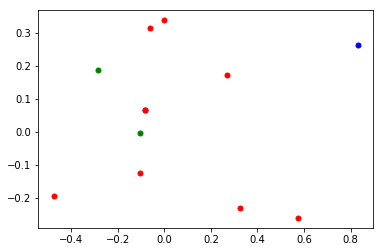

0
小来在哪里啊 小来全国都有吗 小来你的地址在哪里 你家在哪 你在哪里呢 你在哪 那你妈妈在哪里呢 东皖哪里批发衣服 你在哪里
1
你在那工作
2
你们公司在哪里？ 你们公司的地址是哪里
51.18426963285305


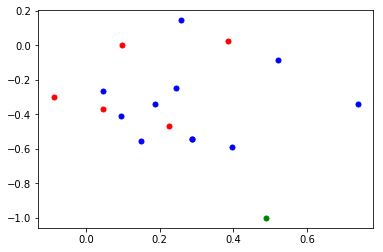

0
美女爆照 你长什么样发个图片呗男人婆 给哥介绍个美女呗 你可以拍照让我看看你长什么样行吗 你发个相片看看你
1
把机器人的照片给我发过来吗?我能看一下吗? 给我发你的照片 我能看看你照片吗 我要的照片给我发发了吗? 发一个你的照片 小来你有照片吗 发一张你照片好吗? 有你的照片吗? 发张美女照片 你有照片吗 我要些照片
2
照片看看
2.6577524736049893


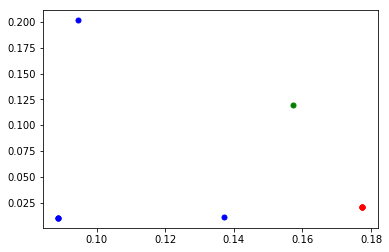

0
结婚了吗 结婚了吗? 咱们结婚吧 我们结婚吧
1
那你结婚了吗 你结婚了吗? 是的,你结婚了吗 你结婚了么? 小来你结婚了么
2
小来结婚了没
57.30420391237982


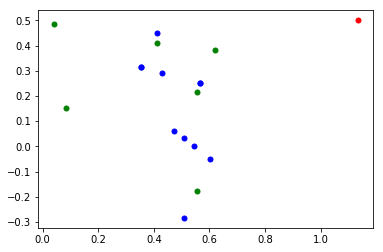

0
睡觉吧
1
你几点睡觉 你几点睡觉啊? 你早点睡觉吧 你不用睡觉吗 你干嘛不睡觉 周末不用睡午觉 你都不睡觉吗 你一晚上没睡觉吗 你先睡觉吧 那你睡觉吗 今晚我在熬夜
2
助理沒睡覺嗎? 你睡没? 你睡啥嘛 你啥时候睡 你几点睡啊 你干嘛不睡
0.0


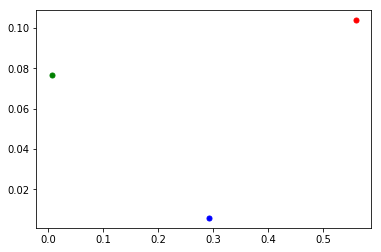

0
感觉回应的准确度还不是很到位
1
你的理解能力我知道了
2
你还需要进化嘛
0.0


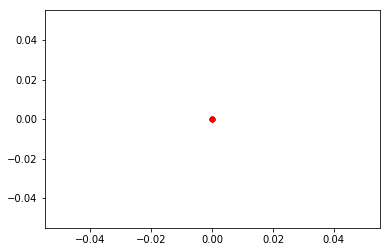

0
??? ?? ???? ?????
140.98995319284177


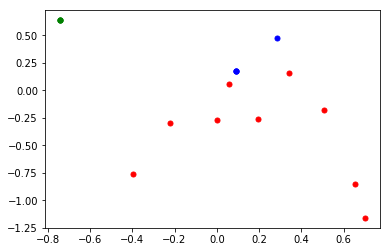

0
什么鬼 什么 what? 好奇怪 怎么回事? 现在是怎么回事 来也是个什么鬼 What about the others ? 别闹
1
什么情况? 什么情况啊 啥情况 这是什么情况
2
怎么了? 怎么怎么怎么了? 这是怎么了?
0.0


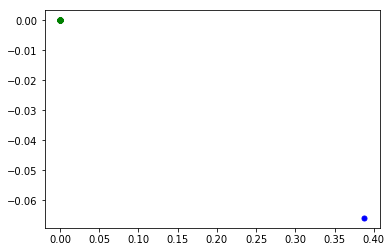

1
诶?
2
啊? 啥 嗯? 哈 啥? 阿 哈? 哇! 哦? 咦? ？ ？？ ？？？？ ？？？ 啊
10.795482172206695


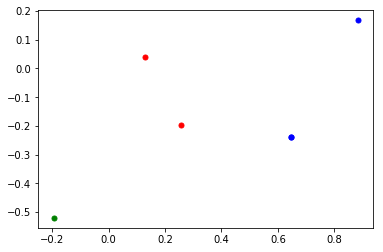

0
你还有没有别的果说的? 再说还有315监管部门 我并没有提出任何过分的要求
1
还有吗 还有吗? 还有其他的吗
2
然后呢
88.57139008391783


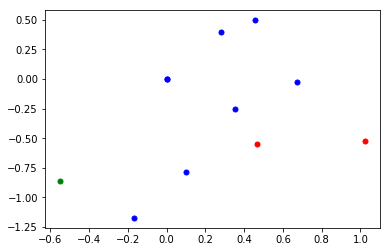

0
我的天 我的天哪
1
卧槽 我靠 靠 我去 吓死我了 哇塞 哇哦 我的妈
2
擦
62.92614268802501


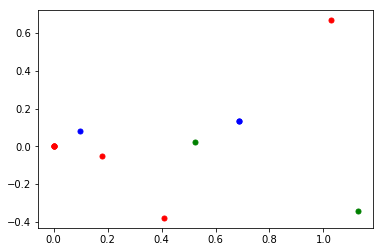

0
喔 真的吗 真的假的 确定? 真的 真的? 我不知道我有表达清楚我没?您理解我的意思吗
1
懂么 懂嘛？ 您明白我的意思吗
2
是吗 不是吧
3.6613676355795


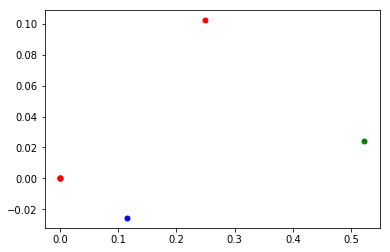

0
这样啊 原来如此 这样呀 原來
1
这么说我就明白了
2
原来是这样
25.173575078138622


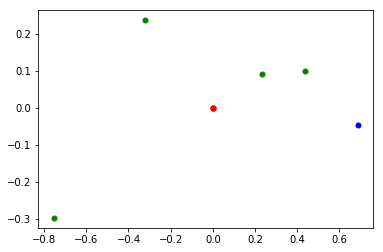

0
why why? Why ?!
1
为什么?
2
什么原因 什么理由 怎么搞？ 我不知道原因啊
60.28076088561082


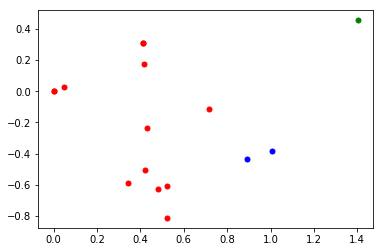

0
晕 无语 醉了 晕死 我也是醉了 我晕 我醉了 呃呃 呃 晕了 也是醉了 我就醉了 我说你醉了
1
我都服了 服了
2
我喝都喝了
16.955307288203507


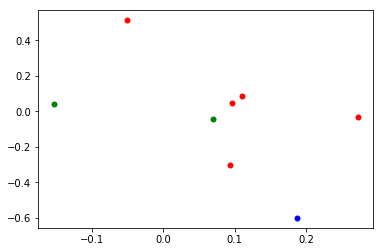

0
那好吧 好吧, 额 好吧 蒽蒽 好吧 算啦
1
好的吧
2
小可爱，有没有想我呀 有没有想我啊?
2.189090215694523e-31


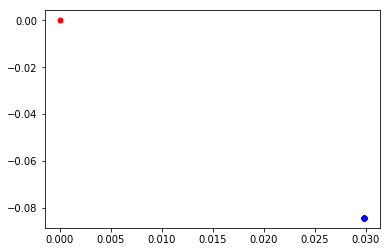

0
哦啊啊
1
啊啊啊 啊啊啊啊啊 啊啊啊啊啊啊啊 啊啊啊啊 哦啊啊啊 啊啊啊啊啊啊啊啊啊啊
21.553179898612985


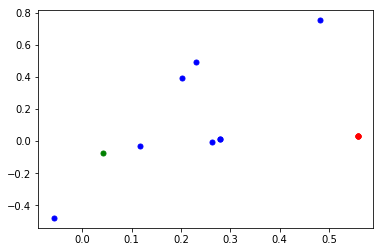

0
疯了疯了 你们疯了吗 你们疯了吧 哦又疯了
1
你疯了 AI是要疯 ai疯了吗 ai是要疯 助理你疯了吗[Facepalm] 脑袋进水了 AI永远是AI吧 你疯了吧
2
啊啊啊啊啊啊啊啊要疯了
35.403056198465


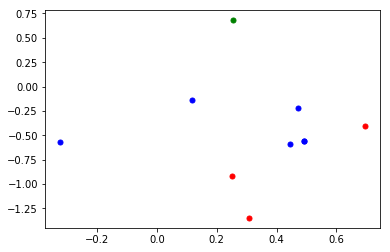

0
我没有钱 和钱没关系 如果没有钱怎么办
1
我没钱 又没钱了 问题是没钱 没钱 没钱  穷 我没有书
2
请我吃饭
53.43876835997254


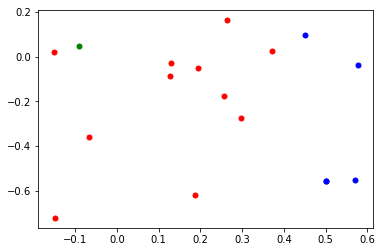

0
气死我了 神经病 辣鸡 草 神经 你有病吧,软件有问题还提醒我打卡 你他妈是不是有病啊 你气死我了 你他妈又这样 你脑子被驴踢了吗 你他妈瞎掰的吧
1
气死了 有病? 是不是有病了 有病吧 又是不太理解你有病啊
2
深井冰
119.63773647676399


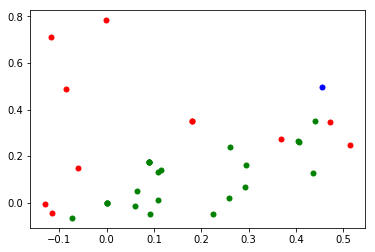

0
烦 实在烦 不要烦我了 烦怎么解除你们 烦的很 能不能不这么烦 说话不用这么客气吖 我也不想主动 心情很郁闷 我不想你 纠结的心情
1
我去!
2
烦死了 你好烦 烦烦烦 你好烦! 哎呀你好烦 你太烦了 一边去,别搭理我 奏凯 不想理你了…… 哎呀 因为你不主动找我聊天。 你…… 烦我了/::D 滚 别jb烦我 尼她妈的不要吵 烦烦烦烦 夠了 你真恶心 你在不用语音跟我说话我就把你删掉了 给你这号人说话没有意思 烦你了 你很烦勒 别烦了
46.66911234766047


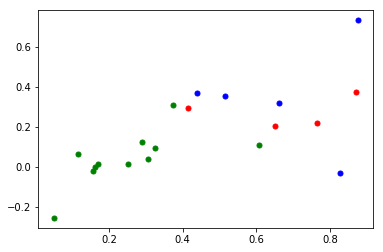

0
生气 我生气了 生气的意思 我生气了,小来
1
讨厌 我讨厌你 我不爱你了 讨厌你 好讨厌啊
2
妈蛋 烦人 滚蛋 有点烦 打劫 你瞎哦 放屁 讨厌你你给我走开 很生气/::Q/::Q 很烦 没完了
0.0


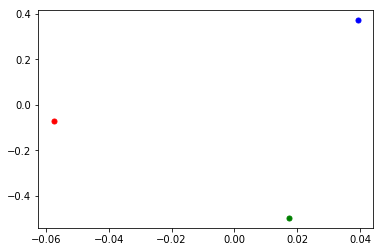

0
你是猪头
1
我要吃人
2
你是猪
0.35428089426553355


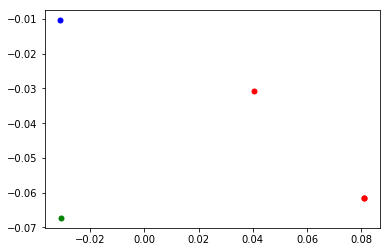

0
跪下 跪下! 跪下称臣
1
给我跪下
2
真的是不是要跪下来叫你爸爸,才叫态度端正啊
173.0404111858059


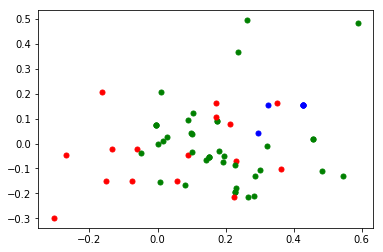

0
好傻啊你 你是不是傻 傻瓜 笨蛋 你是不是笨蛋 我这是起床好吧笨蛋 你是傻子 你个傻子 傻子 你真是个大笨蛋 你都傻的 你是个大笨蛋 笨蛋小来 你笨蛋 你是个笨蛋吗 大笨蛋
1
傻 你傻不傻 傻了 傻? 你傻还是我傻 傻呀
2
你很笨 你有点笨 你怎么那么笨 说你笨 说你笨! 因为你笨 你咋这么笨 小来你怎么那么笨 你怎么这么笨呢 你那么笨,我不怪你 你怎么这么笨呢? 你是变笨了么! 助理来也,你怎么那么笨就听不懂呢? 你笨死了 太笨了 你说你是不是笨 你傻乎乎的 唉,你们变了 这个ai真是蠢 你脑残吗 你是不是2 机器人真的不如真人,好笨 婉君是不是坏人 你不好用啊 你个锤子 ……你咋这么笨啊[Facepalm] 笨 ……你好笨 你很傻喂 太笨 你这个坑货 脑残 就是你蠢萌蠢萌的样子 你好笨啊 笨小来 你是不是个大傻蛋 哼解雇你 咋这么辣鸡 小啦你是神经有问题吧 你2鼻
27.15336993010773


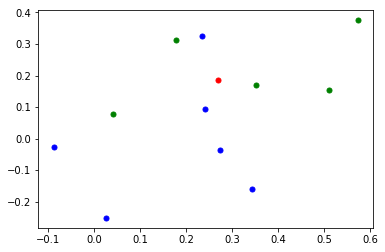

0
找女朋友
1
我想到这个平台里找个女朋友 心爱的人在哪儿？ 少来能帮我找个美女相亲吗? 能帮我找一个美女相亲吗? 我想要的是一个能跟我白头到老的女孩 赶快给我找一个吗?
2
相亲 我要和你相亲 有相亲的吗 来哥你有没有相亲的功能 相亲交友你也可以?
1.4330874290851625


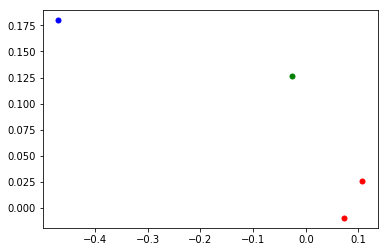

0
拉肚子的饮食注意是啥? 做手术后有什么需要注意的嘛,以及每餐饮食
1
大姨妈来了吃什么水果最好
2
女生来大姨妈饮食上应该注意什么
77.43059228688732


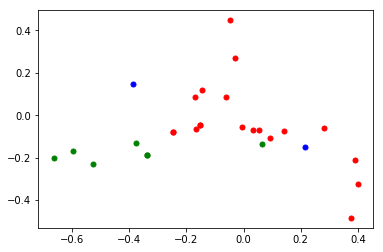

0
7月8号是什么星座 几月到几月是处女座 date什么星座的 date生日是什么星座 7月份是什么星座? 1960年01月2日星座 你知道我是什么星座? 197312月13是什么星座 date生日是什么星座。 date的人是什么星座 date什么星座 我是date的生日是什么星座 我是person星座 10.29什么星座。看农历还是阴历 我是魔蝎座 狮子座是几月 10.1是天秤座吗 处女座几号 怎么推算自己是什么是星座
1
怎么样查自己的星座 星座查询表
2
我什么星座 我是什么星座 什么星座啊 是什么星座 我是什么星座的 不知道自己的星座 我的星座
18.762674560837702


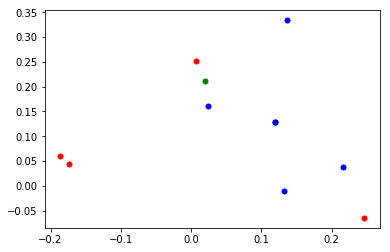

0
早餐吃什么比较好 早餐吃什么对胃好啊 早餐吃什么才能营养搭配得当 早餐吃什么食物对身体比较好
1
几点吃早餐 早餐吃什么 早餐吃什么呢 早餐吃什么好 来也,早餐菜吃什么 我没吃早餐
2
不吃早饭可以吗
46.45257653069274


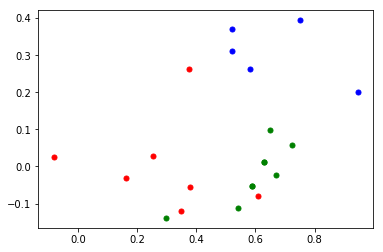

0
喜欢一个人是不是真的很累啊 喜欢一个人难? 我看到一个男孩觉得他很特别 你想我什么呀, 你喜欢过一个人嘛 爱上一个人不敢跟他表白怎么办 怎么样才能分辨一个人是真的喜欢你还是假的喜欢你
1
我喜欢你 女生喜欢男生的感觉 我最近喜欢个男生 喜欢一个不喜欢自己的女生 喜欢是什么感觉
2
喜欢一个人是什么感觉 我喜欢一个人 喜欢一个人 喜欢一个人怎么办 我喜欢上了一个人 喜欢一个人是什么样的感觉? 好喜欢一个人怎么办 我很喜欢一个人 我喜欢一个女孩
72.82999275317314


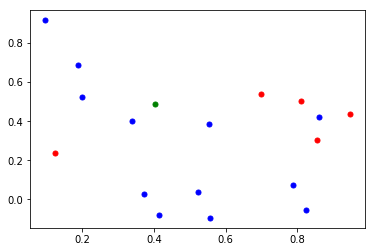

0
我要找什么工作 找工作 小来能找工作吗 可以负责找工作吗? 帮我找工作
1
有什么好的工作吗? 我说最近有工作有什么工作 不知道做什么工作好 小来,我想加入你们的工作 帮我看下永安哪里有做吧台的工作 我推荐招聘的职位或者网站什么的吗? 帮我58同城或者哪里联系一下工作 工作不顺利 我想做助理 有好工作介绍不/::D/::D 有更好的工作介绍不 我不想关注你们这个工作好不好意思
2
这可以赚钱吗
0.0


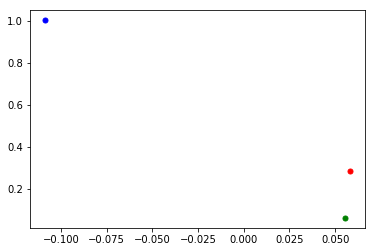

0
考试考差了怎么办呀,?
1
考试考不好怎么办
2
考差了
3.3169605215981215


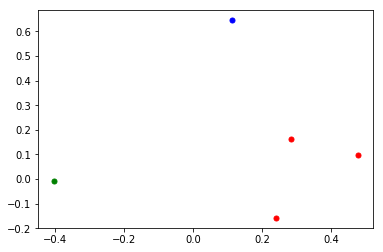

0
自杀 我想自杀 我tutu完她们我自杀
1
下午三点自杀
2
如何自残
0.0


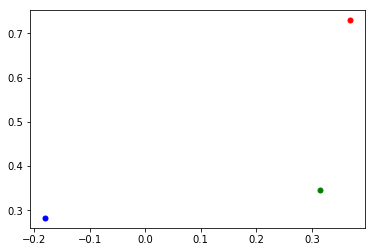

0
南方姑娘是谁?
1
姑娘
2
但我是生长在city的南方姑娘
80.68978445926973


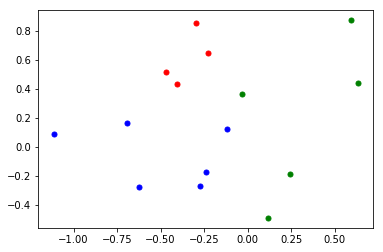

0
哪家理财平台 哪家理财平台好 理财理财产品. 理财小知识
1
推荐股票 推荐一只股票吧 小来帮我推荐一支股票呗 我想问股票 股票还能买吗? 股票
2
帮我推荐今天双色球的一组号码 推荐一个公众号 明天早上七点半走势 养成理财好习惯 比特币多少钱
102.66937807884636


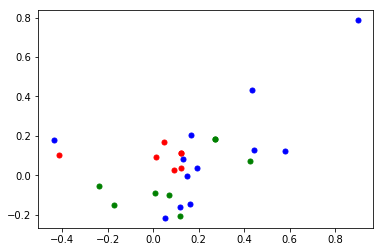

0
我想找个女朋友 想找个女朋友你可以帮忙吗 那你给我找个女朋友 你能帮我找个女朋友么? 找个女朋友 找个女朋友呗 帮我找个女朋友
1
帮我找个女朋友啦,ok 找个女伴友 怎样可以告别单身 想来想来你可以做我女朋友吗? 给你50 让我女朋友来找我 目前我正在急着找女朋友 怎样才可以有女朋友 介绍女朋友给你200块钱 我没女友 怎么办 怎么和喜欢的女生表白 能帮我找个匹配的女朋友吗,想结束单身狗生活 追女孩子怎么追
2
没有女朋友怎么办啊 送一个女朋友 找女朋友 给我介绍女朋友 如何找到女朋友 给我找一个女朋友 可以找女朋友嘛 我要找一个女朋友
2.891465628092692


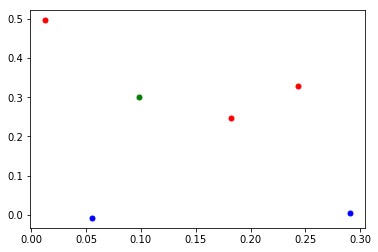

0
中国有嘻哈 看过中国有嘻哈吗 你看过中国有嘻哈吗
1
嘻哈???? 无兄弟,不嘻哈
2
中国人过什么万圣节?
1.467265740030285


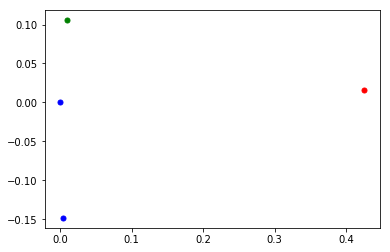

0
iphonex的各种咨询给我下
1
iphoneX iphonex好吗
2
弄一台iphone x
32.15076730979437


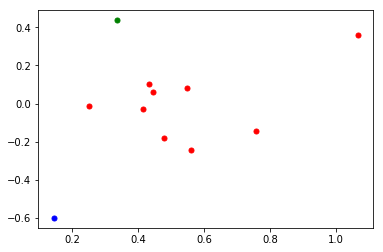

0
发条短信给我妈 除非你先给大爷发条短信 给老婆发条消息 随便发条信息来都可以 可以帮我发条信息吗。 在十秒后发条微信给我 你能自己拨打在我微信电话吗 可以帮我写代码么? 可以帮我为别人发条信息吗
1
能给我妈过生日吗?
2
能帮我查下香港半岛酒店的电话吗
61.792487336273


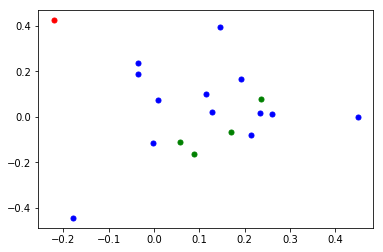

0
什么是健康
1
tna是啥？ 万圣节是怎么来的? 交通运输局路政协管员是干嘛的 给我解释一下万圣节 什么是去中心化? 李白是什么年代的 怎么看待微商 帮我擦一下什么是CPTG 深井冰啥意思 00后也是这样的 澳洲PAUL报价 中国有几大发明?各是什么 为什么冬天会产生静电
2
AFP是什么? 108是什么意思? 翻墙什么意思 这个是什么
12.062226489377686


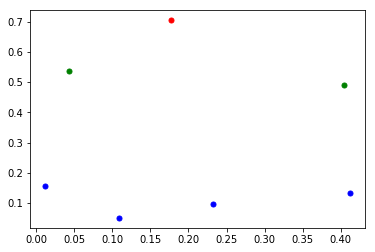

0
现在网络有什么平台可以赚钱
1
做什么事钱赚的快一点 做什么行业,能让我赚到第一桶金 我该怎么做到。天天有钱收?让我开心起来呢 你不是挺厉害吗 给我弄点钱花花
2
怎么赚钱 赚钱
7.617289528019761


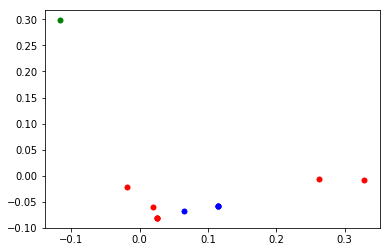

0
美乐家是什么? 什么是美乐家 美乐家是什么 知道什么是美乐家吗 哈哈,美乐家是什么 你知道美乐家是什么吗? 美乐家
1
美乐家优势是什么 美乐家是什么优势 美乐家什么优势 美乐家的优势是什么?
2
你知道美乐家环保超市吗?
10.197174197560583


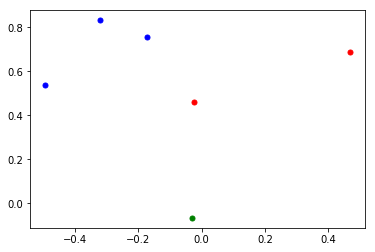

0
吃吃喝喝不如一起养生 养生方面你了解多吗,我们交流一下
1
养生 中医养生 养生知识
2
我没养生日
258.83547524051585


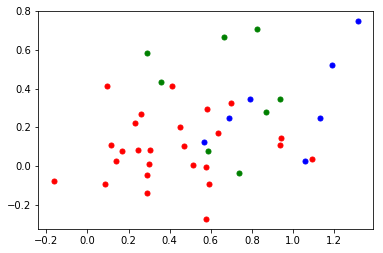

0
早睡 妞妞起这么早? 这么早睡觉浪费生命 你知道晚睡有什么危害吗? 早起有什么用 你也早睡 其实我比你起的太早了 你还是没我起的早啊 ……原来……你不光知道早起……还知道晚睡……/:|-)[Concerned][Smart] 早睡早起身体好 假装起的挺早 早睡早起 我还没要睡觉[Facepalm][Facepalm] 我这是还没睡觉呢[囧][囧] 早起的鸟儿有虫吃~ 周末哪有这么早睡的/:dig 早点睡小来 今天你还挺早 还是起得早啊 你怎么起那么早啊 早起的习惯会让你终生受益无穷 收到早安问候有什么用啊 每天早起的好习惯 早起的好处有哪些呢? 你们真早 小来问一下,下一个明天的我,/:handclap/:handclap/:handclap/:handclap你起的好早
1
睡这么早 今晚早睡觉 都这么早 休息还早 这也叫睡的早 你咋起这么早 你今天起这么早啊
2
早点睡早点醒,也就早点实现自己的梦想。 我还没有睡觉呢 是啊早点睡了∼ 我睡觉里 是该睡觉 这么早就睡觉 该睡觉了早点睡 睡的好
65.52508765658175


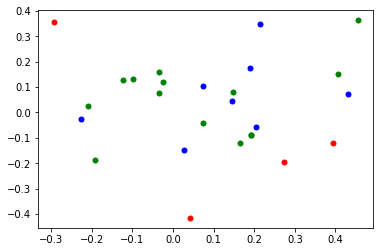

0
给我来一首那种好音乐 给我放首歌 帮我放音乐 为什么不给我放生日快乐歌
1
小来现在有什么新歌推荐下 我想听歌,你帮我推荐首好听的歌曲吧 等会儿帮我放歌 衣不如新,人不如故。 早晨轻快的音乐 下来请放一首邓丽君的歌曲 有没有什么好歌推荐 有什么好歌吗
2
新歌推荐 推荐歌曲 歌曲推荐 给我推荐一首网易歌曲 能给我推荐歌曲 是否可以推荐一首歌曲 推荐一首歌曲吧! 推荐几首好听的歌曲 有没有好听的歌曲推荐 有吗,推荐的歌曲 给我推荐几首好听的歌曲 小来听到的是:推荐一首歌曲吧! 给我推荐一首歌 最近有好听的音乐推荐吗
17.283633162797173


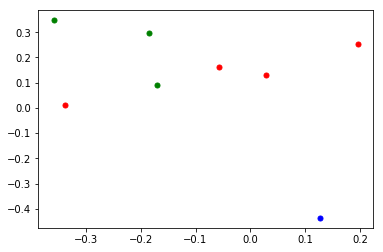

0
来首英文歌 推荐一首英文歌 一首歌 好无聊啊!来首音乐吧
1
不不不我要听歌
2
好听的英文歌 什么歌好听 好听的手机铃声
0.442450770822671


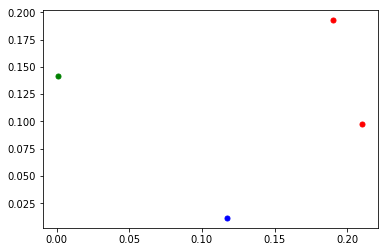

0
拖延症 有拖延症怎么办
1
拖延症,晚起一小时
2
拖延症怎麼辦
55.901670537510924


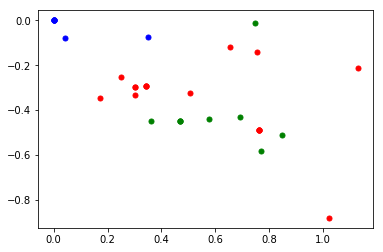

0
1+1等于几 1+1等于 一加一等于几 一加一等于几? 一加一等于几一加一 一加一等于几. 一加一等于几啊! 一加一什么时候等于一, 一加一什么时候等于, 5+6等于 二加二等于几, 二十五乘以一百是 一加二等于几 13×2不等于3。 请问等于几? 5201314乘以10等于 一二三四五加五六七八九等于几
1
1+1= 1+1 1+1=? 5201314乘以10 9×60 5*14平头 1加1
2
1+1等于多少? 一加一等于多少? 来野一加一等于多少 告诉我一加一等多少 告诉我一加一等于多少. 十加五等于多少 754*865等于多少 400-30等于多少 九十九乘以九十九等于多少
11.87458596145283


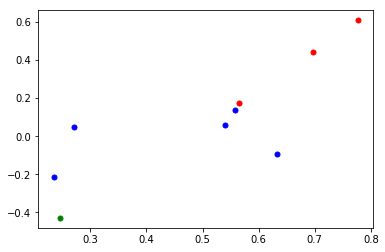

0
孤独 我好孤独 我孤独
1
你感受过孤独吗 我一直没感受到你对我的爱。 我又不是傻子没感受? 我一个人好孤独 没人陪我好孤独/:P-(/:P-(/:P-(
2
满分十分我对你爱到了十分
7.826439045781944


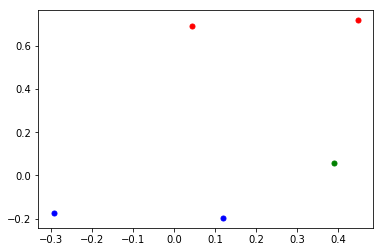

0
怎么读书 读书
1
如何找到自己想看的书? 查一下豆瓣评分9.5分以上的书
2
有书推荐嘛?
16.649072578189525


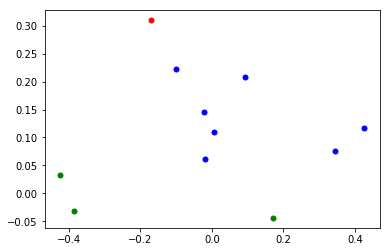

0
电视剧
1
小来,最近有什么电视好看 热播电视剧 我想看电视剧 你喜欢看什么电视剧啊 最近热门电视剧是什么 你看了那部电视剧吗 最近的热播剧猎场
2
好看的电视剧 什么电视剧好看 最近有什么好看的电视剧
0.34496544909846527


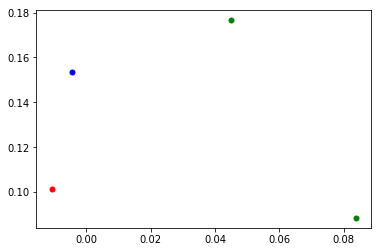

0
有没有职场秘籍
1
职场秘籍在哪里
2
职场秘籍 职场秘籍有吗？
23.174547688522708


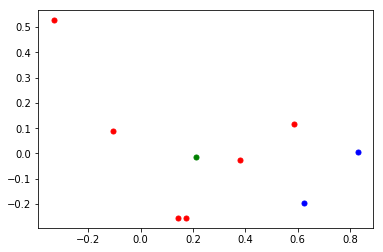

0
怎样处理夫妻关系 夫妻之间没有感情了 请问一下,夫妻两个没有感情怎么办呐。 和爱人吵架了 我老公要离婚了你说怎么办 怎么讨媳妇欢心
1
找一自己爱的人这么难吗 为什么爱一个人这么难
2
夫妻性事
1.1828763216999525


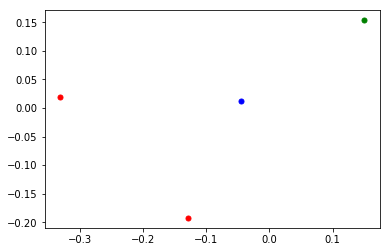

0
帮我收一收几个人工智能的书. 帮忙找一些,这个人工智能的书.
1
你喜欢什么书
2
我需要有关人工智能方面的书
0.0


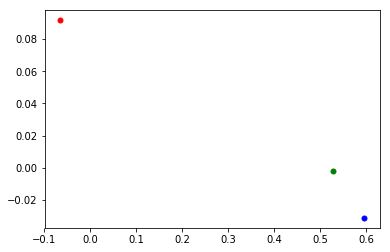

0
我要读阿拉斯加耸耸肩
1
女神
2
如何成为女神
65.08244184900416


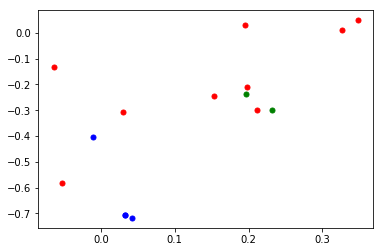

0
一条给女朋友的妈妈的生日祝福短信。 父亲节给我老爸发一条祝福语 小来,帮我编条父亲节的祝福短信吧 需要小来的祝福 祝福越来越好 高考祝福 生日送祝福 送祝福 祝福波波生日快乐!
1
生日祝福 祝福! 祝福我 祝福
2
有祝福语吗 祝福语
10.759740066210224


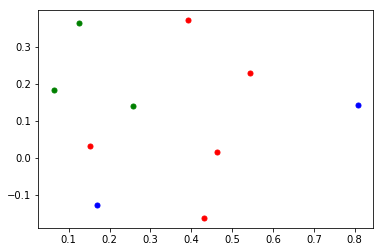

0
职场穿搭 穿搭建议 男士穿搭 有没有男士穿搭建议 没有男性职场穿搭
1
穿搭 衣服穿搭
2
看一下the look职场穿搭 职场穿法 职场
0.0


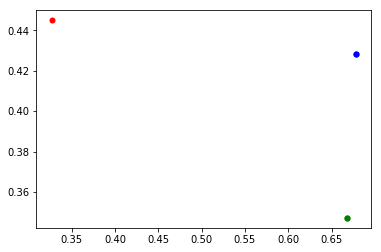

0
午睡的合理时间是?
1
午睡能睡多长时间 午睡可以睡多长时间
2
午睡睡多久 午睡可以睡多久
12.47648073160192


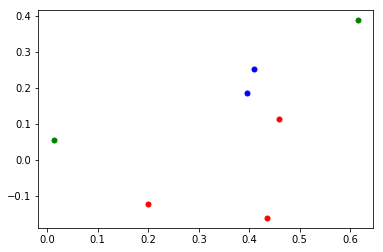

0
国庆节快乐 元旦快乐 元旦
1
祝这个世界继续热闹 祝这个世界热闹
2
谢谢汪老师 中秋快乐! 周未愉快
3.003860513428881


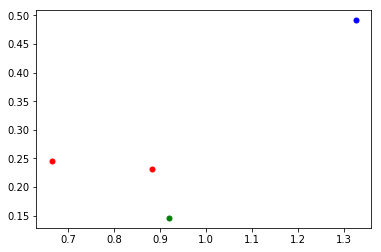

0
国庆你们放假吗？ 你放假了吗
1
放假吧
2
放假回来了吗
0.0


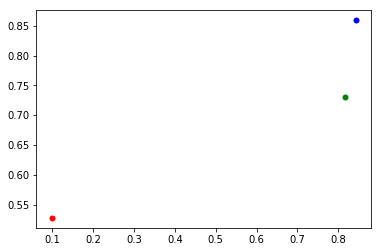

0
小来假期咋样
1
假期愉快
2
祝假期愉快
15.506709952769643


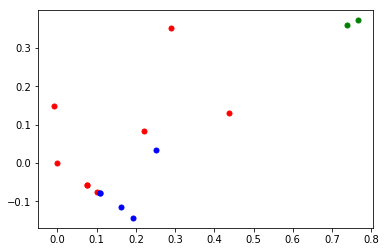

0
感恩有你 今天感恩节，感谢有你～小来。 感恩节 Happy Thanksgiving Day 谢谢!感恩有你! 谢谢感恩有你 谢谢感恩有你/:heart 谢谢!感恩有你的陪伴/:heart
1
感恩节快乐 谢谢！感恩节快乐！ 祝你感恩节快乐! 祝小来感恩节快乐 谢谢!感恩节快乐!
2
谢谢!感恩节快乐!/:rose/:rose/:rose 祝大家元且快乐!/:rose/:rose/:rose
0.0


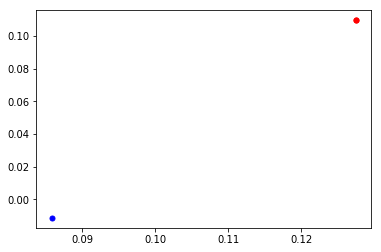

0
什么是寒衣节? 是什么寒衣节?
1
什么是寒服节?
77.13350302491038


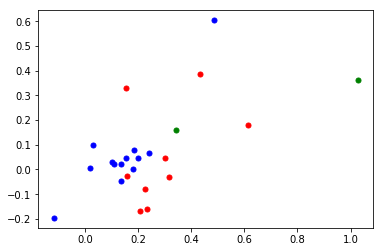

0
新年快乐 祝小来新年快乐，万事如意 小来新年快乐 恭祝新年快乐!万事如意 谢谢亲爱的!也祝你新年快乐平安健康 [微信红包] 新年快乐!狗年大吉 万事如意 狗年快乐 狗年大吉
1
happy new year 新春快乐 春节快乐 二零一八   小来新年快乐 新年快乐 新年快乐!感恩一路陪伴!希望此公众号越办越好!/:sun 祝新年快乐  。                           财运旺旺  。                          狗狗跳起来 珪真祝你新年快乐 新年快乐[小狗][小狗] 新年快乐万事胜意 万事如意/::*/:rose[Packet][發] 小来来 不知道你还能不能看到我的祝福 给你们拜个早年∼ 新年快乐 狗年旺旺旺
2
要过年了 过年了
0.0


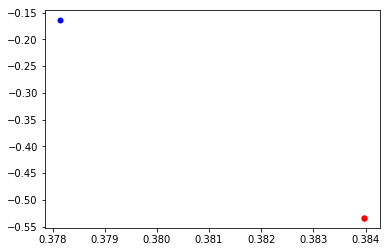

0
情人节快乐 情人节快乐哦
1
祝你情人节快乐
7.216378202248821


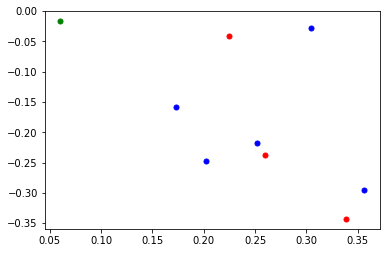

0
六一快乐 儿童节快乐 小来，儿童节快乐哦
1
六一快乐呦 61快乐 谢谢！儿童节快乐！ 祝小来儿童节快乐 祝你儿童节快乐!
2
儿童节日快乐
0.0


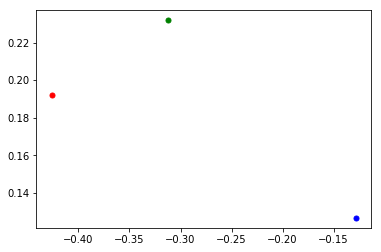

0
长春有什么好吃的
1
东北有什么好吃的
2
吉林有什么好吃的
0.0


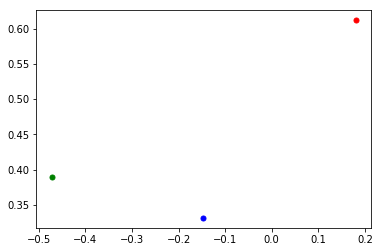

0
大连有哪些美食
1
辽宁有什么好吃的
2
沈阳有什么好吃的
0.8889843414779842


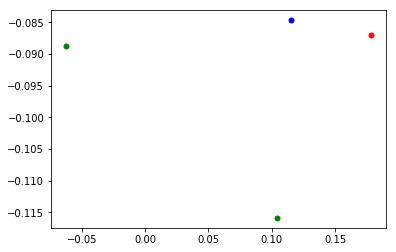

0
小雪是什么意思
1
小雪
2
小雪是什么时候 小雪是什么
162.5487879704569


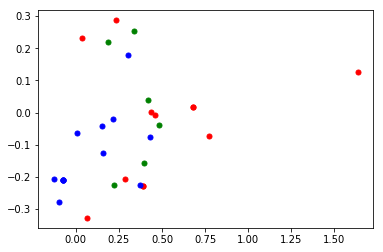

0
我是谁 小来我是谁？ 你知道我是谁啊 认识我吗? 你猜猜我是谁? 你懂我是谁吗? 以后对我的称呼用粑粑 我是个大傻瓜 我是公主吗 欺负我是单身狗啊 那是我自己 你知道我是谁嘛
1
我叫什么 你叫我什么 你叫我什么呀 你叫我什么？ 小主叫什么名字 我是女皇 那你叫我什么 知道我叫什么吗? [domain1018]叫我大小姐 你看我是什么样的人呢 给我起个英文名 你是个臭屁蛋 你妹妹叫什么名字
2
你怎么称呼我 我的名字 给我取个名字 以后对我的称呼用爸爸 你这么知道我的名字 以后称呼我公主
25.7620608488065


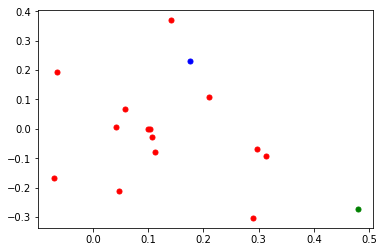

0
叫我主人 叫我公主 叫我helen不叫小主 叫我怡老大 叫我嫒嫒 请叫我陛下 我叫baby 叫我康哥 以后就叫我皇后娘娘 以后叫我Amy就好啦,谢谢配合! 认识一下,我叫,朱雨 哇塞 还记得我 教我强哥 你叫我女王
1
昵称
2
我的名字错啦
75.50175042418813


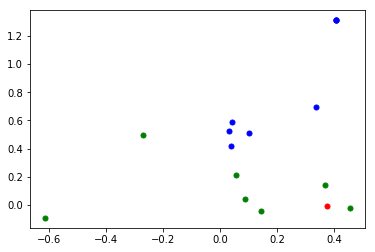

0
么意思
1
有点无聊啊！小来 无聊， 好无聊啊 无聊 很无聊啊！ 我有点无聊 有点无聊 无聊尼玛
2
哎!你也帮我,就发给你,解解闷 解闷 天天也就跟你作伴了 没意思 小家伙我有点无聊啊 幽默笑话 我怎么才能幽默呢
277.1451265979181


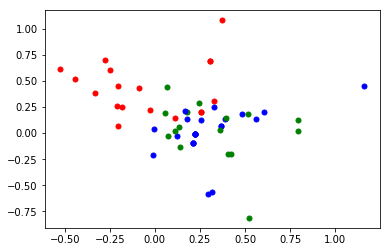

0
今天心情不太好 我今天心情不好 我今晚心情可不好 我现在心情不好 今天心情不好 我心情不太好 伤心 不爽 我好伤心 心情不佳 会因为什么原因而心情不好吗 伤心 啊 很难过 心情低落的时候 郁闷 我好伤心呀 心情不好有什么游戏玩 心情十分不爽
1
今天我不开心 我有点不开心 不开心了 我不开心 我不开心了 我今天不开心 我很不开心 不开心了 开心不起来 小来我不开心 今天一点都不开心 上班不开心 不愉快呢 不开心 不开心呢 非常不开心 不太开心 我不快乐 我还是不开心 怎么会知道我不开心 不快乐 我不喜欢啊 有什么不开心的去玩一下开心一下 真的不开心了
2
无奈 好伤心 一个人为什么会老是叹气 今天运气差 我想不通为什么别人能考上我考不上 我现在拿刀指着你 那我就不喜欢你了 我不知道我为什么压力这么大 我最近总是不开心 但是我不爱你 压力大 不嗨森 我不开心 有事 醉了 一觉起来就不开心 我想不通啊啊
0.0


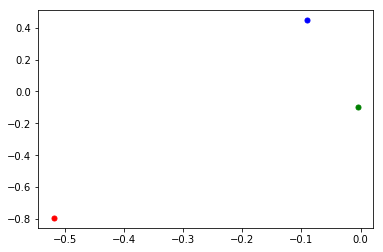

0
讲个笑话
1
让我幽默
2
段子
58.54594923638997


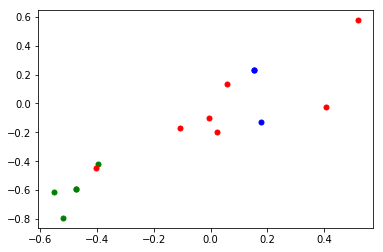

0
小来,给我讲个故事吧 段子 讲故事 来个段子 笑话大全 继续发高级段子好么 放松一下
1
冷笑话 给我讲个最新冷笑话 冷笑话呢
2
讲笑话 讲个笑话吧 来个笑话 给我讲个笑话 给我讲个笑话吧
56.381468072806015


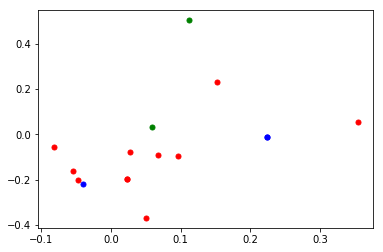

0
说个段子 来个段子 内涵段子 讲个段子 来一个段子 讲个搞笑段子听听 来个段子吧 来个搞笑段子. 励志段子有吗 再讲一个段子 冷笑话
1
不开心 伐开心 不开心不开心
2
那你就想想办法,,把我弄开心呀 悲伤哦
33.12996320317537


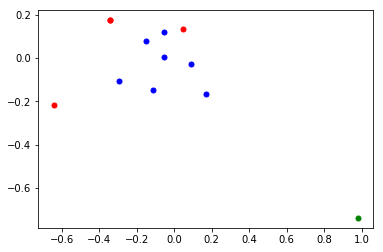

0
不好笑 这个不好笑 虽然不好笑 这笑话一点都不好笑。
1
搞笑点的,尽量不要重复。 换一个,不好笑 不好笑不好笑,别人组都有大腿抱,我们组全是麻瓜 你讲的笑话不好笑 这个一点都不好笑啊!你撒谎. 什么没笑 小来你讲的笑话不好听
2
换一个
80.27942430720738


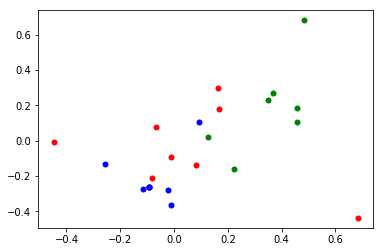

0
心理鸡汤 心里鸡汤图 鸡汤小语 来碗心灵鸡汤 来点心灵鸡汤 我要心灵鸡汤 一句个性签名 走心鸡汤
1
来个鸡汤 鸡汤 鸡汤! 求鸡汤 鸡汤呢? 来碗鸡汤 好鸡汤 我要喝鸡汤
2
人生格言 但是人生总有走错的路 听人生典故 小来你用学习吗 还有什么好看的话,比如人生道理 哥心里空虚啊 给我发一段人生格言
5.42012884384595


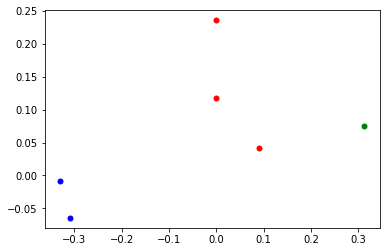

0
小说 有小说吗? 来部小说
1
好看的小说 什么小说好看
2
打电话的时候说两句励志的话
30.362439123202858


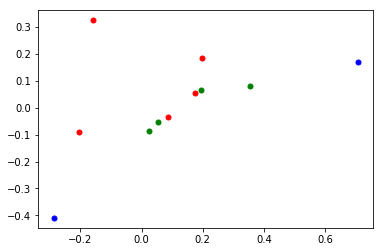

0
给我来个搞笑视频 有没有搞笑的视频呢 搞笑的 搞笑的视频来一打 有什么冷知识视频呢?
1
视频笑话 视频
2
在吗你发先发些关于这种视频的给我 来个赵本山的小品 都跟我发些啥子 你给我撇差发视频小心我投诉你
8.725051859347086


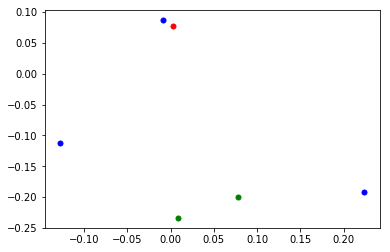

0
除了讲笑话还会干什么啊
1
你会讲黄段子吗 你会讲成人笑话吗 讲一个成人的
2
给我讲个成人段子 我要挺黄色的段子
352.65977265933157


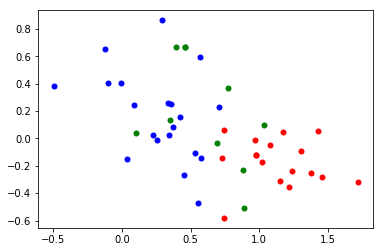

0
早安卡 起床卡 怎么打晚安卡 早安～ 早安说说 早安0 打 卡 打什么卡 能在发个晚安卡吗 现在不能打早安卡? 请准备好晚安语和早安语 补打早安卡 可以说晚安卡吗? 我想打早安啦 怎么打早安卡 有没有晚安卡 怎样才能打晚安卡
1
晨起打卡 今天的打卡发给我一下 看不懂,天天昨打卡呀! 行了,我打卡 早安去哪里打卡 哪里打卡 每天要早起 如何制作自己的早起卡 怎么打卡呀 能不能每天起来就可以自己打卡,每天都要收到这条信息才能打卡,有些时候又收不到 早上怎么打卡 请问如何打早晚安卡? 怎么打 我今天要打卡 请问有本人二维码的图片怎样获取 第二天如何打卡哩? 早起二维码 忘记怎么打卡 我现在要打卡在那里进去你 有没有早睡打卡公众号
2
早起打卡 起床打卡. 打卡起床 打卡早安 我要早起打卡 早起 早起打卡说早安 打卡(晚安) 我要打卡早安 (打卡
402.7573678641833


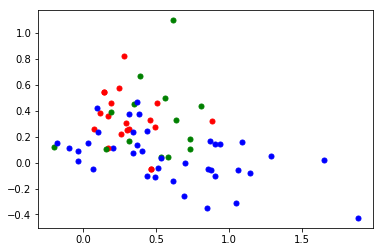

0
晚上的打卡时间是几点？ 几点可以打卡？ 晚安打卡从几点开始 几点才开始啊…… 每天早上最好几点打卡 早起是几点 最晚几点打卡 起床时间是几点到几点? 早起是几点呢 几点到几点是早安 几点可以打卡 几点打卡结束? 每天几点打卡几天就出 最迟打卡是几点 早上几点能打卡 晚安卡是几点到几点 几点能起床打卡 早安打卡时间几点到几点 最早几点起床
1
几点钟打卡有效？ 我早上几点起才可以打到卡啊 打卡的时间是多少 打卡时间有限制吗 早安说什么时候打 几点算起床卡 为啥早上4点以前不能打卡 几点是早安卡 为什么八点之前都打不了早安可能 九点以后就没有打卡图了吗 几点打晚卡??? 一天打两次卡吗 是不是今天打卡打晚了? 我晚上的卡是不是可以还回原来的时间啦? 每天干嘛要限制4点才可以打早起卡 可以现在打个早安卡吗? 怎样要让你知道我几时起床啊? 我的意思是每天早安卡与晚安卡的时间范围 打起床卡的时间是几点? 什么时候打晚安卡 起得早的能有几点打卡 每一天要打这么多卡 几点开始打早安卡 你管老子几点打卡呢 才几点就提醒打卡/::Q 睡觉时间 我是早起3:25如何打卡呢 哪个时间段属于早点打卡时间 为什么这个点就不能睡觉打卡 每天规定什么时间才可以打卡 打卡时间是什么时候 睡眠打卡从什么时间开始 什么时候算早安 早上打卡最晚时间是十点吗 最脕几点打卡有效 几点算是早起 怎么设置睡眠打卡 我每天打个卡又睡了
2
打卡时间 晚安打卡时间 早起打卡时间 早安打卡时间段 早上打卡要多早？ 现在可以打卡么 请问今天可以早起打卡吗 早打卡 我现在要打卡 早晚都要打卡吗 还有晚安打卡吗 晚安打卡和早上好打卡的时间区别 晚安什么时候可以打卡?怎么打卡 午休也可以打卡哈
143.34124943514954


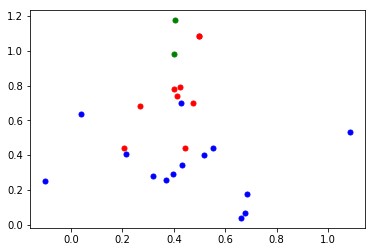

0
健身打卡 运动打卡 跑步打卡 可以健身打卡吗 有没有健身打卡 帮我做个健身打卡 有没有跑步打卡 有运动打卡吗 可以跑步吗?
1
健身打卡可以加图片吗 健身打卡有什么推荐吗 运动第一天,打卡 刷牙打卡 读书打卡 不吃晚饭打卡 每天政治打卡 我要连续吃药13天 怎么设置读书时间 阅读打卡 我要阅读打卡 21天阅读读书养成 创建健身打卡在哪里创建 我要锻炼
2
瑜伽打卡 瑜伽
106.12158527435741


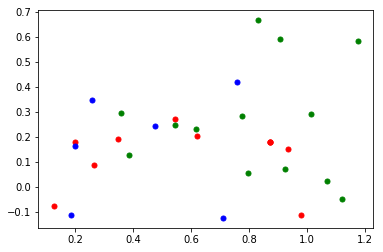

0
我要改打卡时间 我想改打卡时间 怎么改打卡时间 咋改打卡时间 打卡改时间 改打卡时间 打卡如何改 如何能改起床时间时间呢 改起床时间 怎么样改上面的时间 我可以改时间吗
1
忘记打卡晚上再打行吗？ 怎么改成早上7点半打卡 请把打卡时间调换成4:30 打卡时间真是混乱 起床打卡改为每天早上7点 怎么调成早安卡
2
打卡时间怎么设置在早一点? 早起打卡和晚上打卡在哪里设置 能否修改打卡时间 怎么修改休息打卡时间 打卡图片上的时间可以修改吗 修改早起时间 更改晚上打卡时间 怎么更改每日打卡的时间 更改早晨时间 更改每日打卡的时间 晚打卡时间去哪里设置 怎样知道自己每天的早起时间 怎么改每天早起这个时间
4.192037237665055


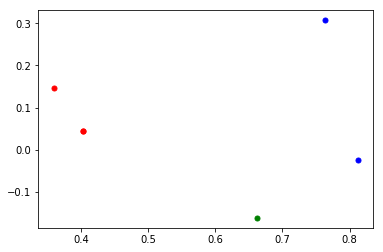

0
8月打卡图片 9月打卡图片 11月16号的打卡图片发过来可以吗
1
打卡图片汇总 打卡汇总有吗?
2
第一天打卡图
79.26223536976829


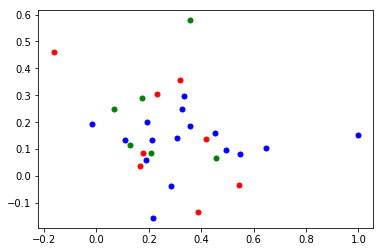

0
我和国内有15小时的时差,请问如何打卡呢 请我在国外时差6小时,怎么打卡? 我和国内有时差 怎么打卡呀 我在国外怎么打卡 国外打卡时间不对啊 我在国外，有时差，提醒不对啊 英国时间 好吧。我这里跟国内差11小时
1
不科学,不在一个时区的孩子没法和小伙伴一起打卡 最好可以设置根据时区来打卡的,这样你们的软件在海外也畅通无阻啦!加油!冲出中国,走向世界 我要反馈,时差党不能打卡! 我生活在新疆喀什,和内地的朋友有2小时的时差,打卡不能同步怎么办? 我在澳大利亚,有无根据这边的时区来打卡的设置 我在海外 能不能整个海外时间打卡 我说你没法帮我调时区,真弱 可以设置时区吗? 能调整时区吗? 小来是不是只有中国时区 时差!时差!时差! 更改时差 这个简直是在欺负海外时差用户 朋友,你要关心海外游子的时差 这个系统啊,不能跟着我的时差走吗 不考虑时差吗?
2
海外可以打卡吗 海外是否可以打卡？ 海外可不可以打卡？ 海外能不能打卡吗 能不能根据时区打卡呢 时差无法打卡
91.91396581578822


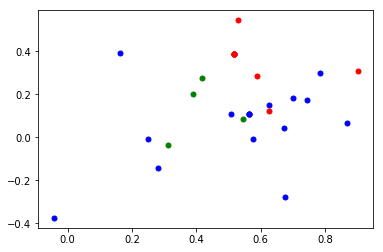

0
共同打卡 怎么共同打卡 怎么共同打卡啊 怎么共同打卡呢? 怎么才能共同打卡 怎么才能共同打卡呢 怎么和好友共同打卡 怎么早起共同打卡呢? 怎样与好友共同打卡
1
共同打卡和打卡有什么不同吗 共同打卡也有优惠券吗？ 共同打卡有什么好处？ 共同打卡是什么意思？ 共同打卡的奖励是什么？ 共同打卡是什么 打卡有什么奖励 什么是共同早打卡 共同打卡是什么意思? 共同打卡是什么意思 什么是共同打卡活动呀? 为什么我会没有共同打卡? 什么惊喜? 有哪些打卡 我怎么看不到跟别人一起的打卡记录。 为什么显示共同打卡零天呢
2
让朋友朋友参与扫我的吗有什么好处吗? 只能和一个人打卡吗 一个助理来也可以两个人打卡吗 想抽奖必须和好友一起打卡吗
496.4509876995746


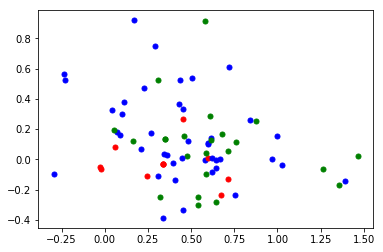

0
怎么加好友 怎么加好友一起 加好友 怎么样加好友 加好友一起打卡 怎么样加好友一起打卡 如何加更多人 这个怎么加好友 加好友怎么加 怎样加好友 怎么增加好友
1
如何添加好友 怎么叫好友起床 在哪添加好友一起打卡 怎么分享 分享 让别人识别我的二维码怎么识别? 怎么关注好友 向朋友打招呼怎么设置 怎么看不到好友历史打卡记录? 我把好友删了!怎么恢复 怎么样能成为好友 好友也要打卡。怎么发给她 我恢复好友的打开呗!不小心删除了 怎样互相关注的 如何关注 怎么关注 如何互加好友啊 怎么没有给好友发送晚安? 请代我向阳光礼品服饰问早安 已经有加入好友啦 已经邀请好了 怎么和好友关注 怎么邀好友 怎么给好友发信息 我刚才不小心删了一个好友没法子加了[Facepalm] 怎么推荐给好友？ 如何添加微信上面的好友 我跟乐儿怎么关注 怎样成为好友 删了好友怎么加回来 刚才将好友不小心删除了 怎样关注好友早安卡 怎样关注好友睡眠卡 怎样关注好友睡觉蜡 删除关注的好友怎么在关注呢 怎么分享给朋友关注 你好 被删除的好友怎么添加回来吖 请问怎么邀请员工来打卡 怎么发送邀请 关注朋友 怎么添加好友 怎么拉好友
2
好友 添加好友 怎样邀请好友打卡 怎么添加好友打卡 怎么叫醒好友 邀请好友打卡 让好友打卡 好友打卡怎么弄 怎么看好友打卡 和好友打卡 打卡关注 怎么收不到好友的打卡呢 邀请 我现在已经邀请了好友扫描 怎么邀请好友 小来。为什么我收不到好友的打卡 分享好友二维码 邀请别人一起打卡 早安邀请 互相问早安 如何添加打卡好友 怎么邀请好友一起打卡 把好友不小心删除了，怎么添加好友？
546.2753333107428


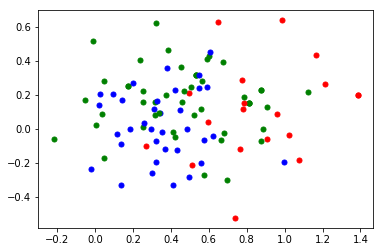

0
怎么像好友问候早安 互道晚安 问候他早安! 问候美好早安 如何互道早安 互道早安 你也帮我向她问候呗 打卡问候 爱的思念问早安 给他问候我起床了 向她问候早安 一起问候早安 如何发早安 怎么问候? 替我问候她 问候惜惜早安 替我和她说早安 帮我问他早安 请给我发送早安语
1
也代我问他们好 问候好友,xiaxia 我让你问下我的朋友 向柯芬姐姐问候 花花问好 我的好友fengwing. 起床了吗? 王老师。祝你心情快乐。 问个好 小来问候杨教练早上好,十九大后收获满满 睡觉 告诉房玄龄 问好 小来去谢谢杨教练 看谁还有比我早 太能睡了 告诉我亲爱的老大,冷了,注意保暖。 我和我媳妇儿都用这个,为什么不是好友 那你也帮我向他问好一下 帮我告诉她  我起得早 思念 请代我向阳光礼品服饰问好 给我好友说我胃疼 我要找回我的朋友 给王丹问好 帮我向萌颖宝刀问好 小来帮忙问候董娟了吗 如何用微信消息叫朋友起床 对方能不能收到我的起床时间啊 相互都可以看到打卡的时间怎么设置 问候董小姐 你替我跟夭夭说一下晚安 问候 大洋洋 和银优璇说早安 怎么起床那么晚 如何看扫码相互关注的人 就是我群内的小伙伴，我无法给他们提醒打卡是什么原因
2
唤醒好友打卡 打卡是怎样打卡啊 问候好友 如何问候好友 怎样问候好友 怎么问候好友? 怎么问候好友 怎么问候我的好友 问候我的好友 问候一个好友悟 向好友问候 怎么和好友问候 问候我的好友谢 像好友怎么问候 帮我问候好友 帮我问候我的好友 怎样问候好友? 可以帮我问候好友吗 怎么和好友互相问候 怎木跟好友聊天 问候一下我的好友影 朋友起床啦 我想看看好友睡觉了呗 怎么向好友问好 可以和我的好友说话吗 怎样和朋友早安 可以和好友聊天嘛 如何加好友 怎么看不到好友问候 给我的好友说早安 我的好友每天会收到我打招呼吗 怎样给好友发消息 给微信好友说声早安 为什么朋友的打卡没有给我提醒 为什么好友打卡会有消息发过来给我? 好友晚安卡 收不到 问候我的关联人 如何与好友互相关注 如何关注别人 怎么问候好朋友 怎么关注别人 我要怎么问候别人 我怎么和我的好友道早安 如何关注其他打卡人 给朋友发问候 如何关注陌生人打卡 怎么关注陌生人打卡 为什么我的朋友有打卡而我看不到?
180.25619854527957


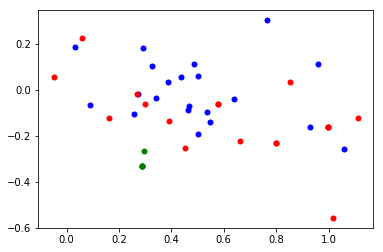

0
好友列表 打卡好友列表 好友列表在吗 好友列表? 怎样好友列表 好友列表在哪 好友列表呢 哪里有好友列表 好友列表在哪里 好友列表在哪点击 好友列表在哪? 哪里看好友列表 在哪里啊!好友列表 我的好友打卡表 怎么看好友 我的好友列表不见了 怎样查看我的好友 看好友
1
我想看好友排名 怎么看到那个好友的排名? 排名 我怎么没看见,好友打卡排名啊? 打卡排名 早起排名 怎么看排名 可以看到同时打卡的人吗？ 今天明明有七八个人通过我的二维码打卡了,都看不到 看不到朋友的排名啊 排行 怎么看不见好友早上打卡情况 我想知道我的好友叫什么名字 已经互相关注成功   为什么在我的好友里面没有显示好友 怎么能有好友的详细信息 怎么能够看到我的朋友 在哪看排名啊? 为什么我分享二维码给我朋友都关注了为什么我好友列表没有他们 我起来有多早呢 我的打卡好友在哪找 为啥看不见我好友
2
我的好友 我可以看到我的好友里他们的好友吗 我的好友 我得好友 我的好友呢
242.567562602607


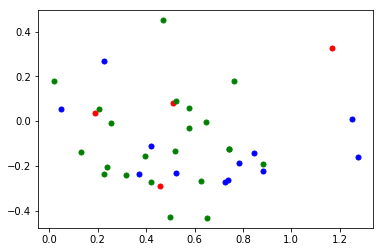

0
少说话 别推送 请不要给我这么多推送 不要再发啦
1
能设定消息免打扰吗? 消息免打扰 没有消息免打扰功能 免打扰 开启消息免打扰 可不可以消息免打扰 可不可以设置免打扰 能不能设置消息免打扰 没能不能设置免打扰 怎样弄消息免打扰 怎样免打扰 有没有来信息免打扰功能
2
能不发消息了吗 为什么不停的发重复信息？ 不要一直发信息吧 你给发过了,请不要重复发 不要随便发信息了,太多信息很麻烦 不要在发了 别吵 勿打扰 有病,取关了 亲。能设置静音的吗 不许给我推送了!!我他妈揍你 不要发无谓的信息给我 别乱发我信息 助理来也 免打扰 那消息能静音么 如何取消新信息提示 不想接收任何信息 或者设置个信息勿扰选项 当年取关,好像就是因为推送太多了。 这个可以设置静音吗 我希望有静默模式 最好弄个免打扰模式，一天消息太多，耽误时间看手机
8.081559489332788


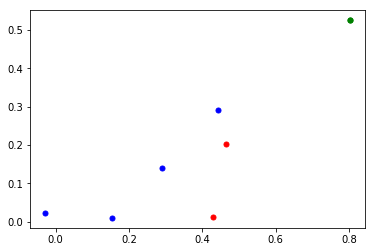

0
我的好友今天没有打卡 好友打卡怎么没有提示呢
1
居然起这么晚，大懒虫 懒虫 你咋起这么迟 你太懒了
2
这么晚 又这么晚
0.826481987436237


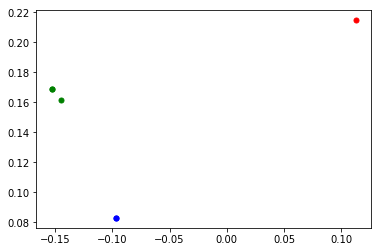

0
怎么关注别人打卡
1
如何关注别人打卡 打卡如何关注别人？
2
怎样关注别人打卡 怎么样关注别人打卡 打卡怎样关注别人？
0.0


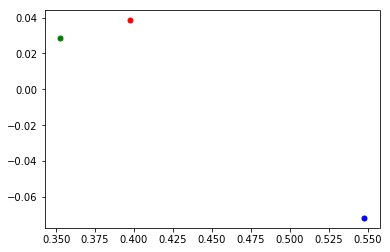

0
不想接收好友的消息？
1
接收好友的消息怎么办？
2
怎么不再接收好友的消息？
4.5520267721544325


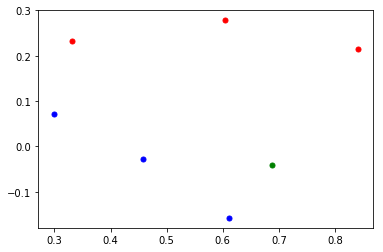

0
怎么查看好友排名？ 怎样查看好友排名 查看好友排名
1
看好友排名 怎么看好友排名 好友排名在哪啊
2
好友排名
241.5925689978157


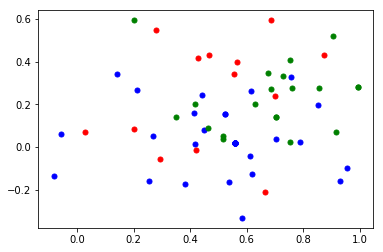

0
怎么取掉关注别人 帮忙把他删一下,谢谢 怎么解除关注 为什么删不掉好友? 解除好友关系在哪里设置 怎么取消互相关注 怎么解除好友关系 如何取消与对方的互相关注 怎么可以把关注的人去掉 不想与他共问早安 我可以不关注香香吗 可以不互道早安吗 如何取消关注对别人的关注
1
怎么删除好友？ 怎么删好友 怎么删除好友 删除朋友 只要扫了我的码就能成为打卡的好友了?不一定是微信好友咯 怎样取消好友关注 好友排名打卡那里怎么取消好友 请问怎么删除打卡好友啊? 怎么删除打卡的好友呢? 怎么删除好友啊 好友怎么删除? 怎么删除好友? 怎么删除好友呢 怎么删除好友呀 怎么可以删除好友 好友怎么删除 打卡好友列表怎么删除好友? 想删除好友,怎么删除? 取消关注好友怎么取消 请问怎么删除好友啊 怎么删除好友呀, 能不能不要好友啊 删好友 如何取消好友关注 怎么解除好友绑定 解除好友绑定 能删除好友嘛 这个打卡里的好友要怎么删除 不能删除么 可以删除不想要的好友吗吗 我删除好友她可以看得到我的打卡记录吗 怎么样取消好友 我如何删除好友 我要删除关注的好友
2
取消共同打卡吗 怎么退出打卡 共同打卡好友怎么删除 怎么删除共同打卡的好友 怎么删除打卡记录 如何删除共同打卡好友 能删除打卡共同好友吗 取消共同打卡 如何取消共同打卡 怎么关闭共同打卡 怎么取消共同打卡的人 怎么取消和某个好友的共同打卡? 要是不跟好友共同打卡了,怎么取消 怎么解除与好友的共同打卡 怎么取消共同打卡? 共同打卡怎么取关好友 不是共同好友会不会可见 取消共同打卡天数提醒 如何取消好友早安绑定 关闭朋友打卡
146.76479758833818


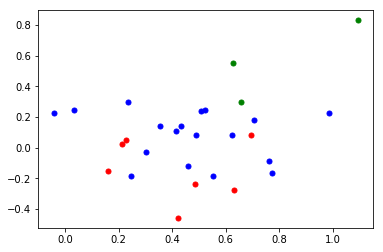

0
怎么样把消息提示音关了? 怎么一天推这么多信息? 怎么取消别人接收信息 我希望你们取消一切给我发信息打电话 不接收对方打卡信息 如何能不收到他们的信息提醒 她起不起关我什么事儿?下次别给我发了
1
别再提醒我打卡了 怎么把打卡消息关了啊 我不想让别人知道我打卡了，该怎么办 别人的打卡信息怎么屏蔽？ 帮我把打卡关了 如何取消好友提示 怎样关闭铃声 怎么能不让好友起床打卡就提示我? 别推送打卡消息 我不想和她互道早安怎么办 我不要知道好友打卡 我睡了之后朋友打卡可不可以不给我发消息 怎么才能知道对方把自己删除了 不给朋友问早安 不想要好友的通知发过来怎么设置 不接收好友早安提醒 如何屏蔽不喜欢的好友打卡提示 我能屏蔽朋友吗
2
消息管理在哪里 在哪里能找到消息管理 消息管理
1.084705960341744


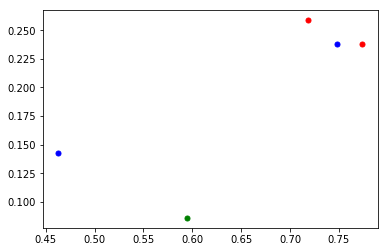

0
早起打卡和共同打卡是两个活动？ 早起打卡和共同打卡是一个活动吗？
1
连续打卡和共同打卡是一回事吗？ 早起打卡跟共同打卡有什么区别？
2
没明白早起打卡和共同打卡有什么不同啊
2608.8590489053813


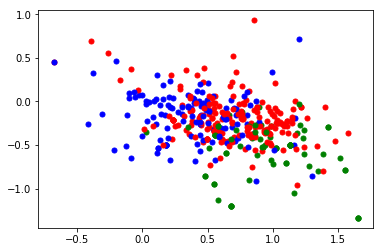

0
重新生成打卡图 重新打卡 怎么生成 没有打卡图片 怎么没有打卡图片 打卡后没有图片 打卡怎么没有图片 打卡图片怎么没有 没有打卡图片了 没有生成打卡图片 没有收到打卡图片 没有早安打卡图片 为啥没有打卡图片 没有打卡图片? 没有发打卡图片 还没有打卡图片 早起打卡没有图片 重新生成打卡 怎么没有早安图片呢 早上打卡了为什么生成没有? 重新生成打卡图,谢谢 怎么又没有打卡图片了 怎样重新打卡? 生成 重新生成图片 没收到打卡图 今天没有生成打卡图 为什么没有打卡图片 生成图片 为什么没有图片 近期打卡为什么都不出现打卡图了 怎么没收到打卡图 码呢 今天怎么没有早起打卡图 总是收不到图片呢 为什么打了卡,没有打卡签到图? 怎么今天收不到打卡图片? 今天打卡又没图片 为什么不能生成早安打卡图 打卡怎么没图了 怎么没打卡图[Facepalm] 再来一张打卡图 怎么没有生成卡了 请给我发张打卡的图片 打卡截图 为什么我打卡没有生成卡呢 还是没有生成卡 你好我收不到打卡图 我打卡了可是卡呢? 为何打了卡图片没有马上显示呢 打卡图总是不出来 我打卡了的 发送什么二维码 签到好慢图片 能否重新生成打卡图 怎么不显示图片呢 为啥我总没有打卡图 今天早上打卡的图片可以发给我吗? 我为什么打卡总不出图片 我想要今天早上打卡的图片 打卡图片不见了 生成卡片 为什么没有显示我打卡 重新打卡可以不 我的图片看不到呢 两次没有生成图片 为啥打卡不了? 怎么不显示打卡图? 怎么收不到图片 生成打卡 老说我忘签到是你们的问题呀?签到打卡页面不出现 今天签到图怎么没有发? 什么意思?没有打卡图? 为什么不能生成打卡二维码名片啦 为什么有时候打卡没有图片反馈 重新设置每日打卡 为什么我生成的早起打卡图没有二维码啊 为什么打卡没有卡片出来 为何我的打卡图没发来 我的早安卡呢 生成二维码 怎么重新生成打卡图 二维码了 打卡几次没图片 为什么打卡没有发图片 为什么打卡没图片 为什么打卡了没有图片 为什么老是收不到打卡的图片 没有收到早安卡 打卡图为什么几次不出来 请问为什么有时候点打卡不会自动回复打卡图呢 一直没有打卡图出来??? 不能生成打卡图 为什么不能生成打卡图 为什么打卡不显示? 为什么打卡不显示了 为什么打卡之后没有图片出来呢? 为什么打卡图出不来 为什么打卡没有出图片呢? 为什么收不到图 为什

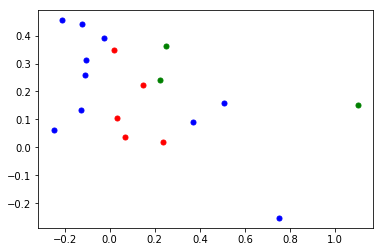

0
repeat_date帮我自动打卡吧? 打卡机 从明天可以,你要帮我签到吗 只要开微信就打卡了吗 你明天七点钟能自动打卡吗
1
自动打卡 会自动打卡吗 怎么自动打卡 能不能自动打卡 怎样自动打卡签到 自动签到 可不可以给我自动打卡? 能给我自动打卡吗? 打卡图咋不自动生成 怎么设置自动签到
2
自动帮我打卡,起床打卡,,睡觉打卡, 每天帮我签到吧 你帮我打卡可以吗
5.182468942286901


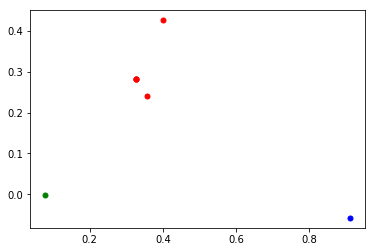

0
午安打卡 午安打卡～ 午安打卡哦 是午安打卡 午休时间耍不要打卡了?
1
午安卡
2
唔唔,,午安打卡
7.787747410870675


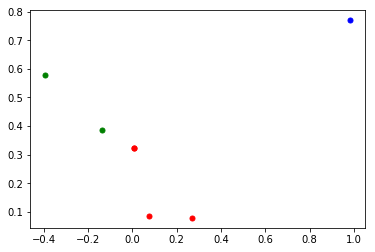

0
怎么消除打卡天数重新开始呀 早起打卡可以重新开始吗 重新从第一天开始打卡 重新开始第一天打卡
1
从新打卡
2
打卡怎么重新开始呢 怎么重新打卡?
68.17052416676752


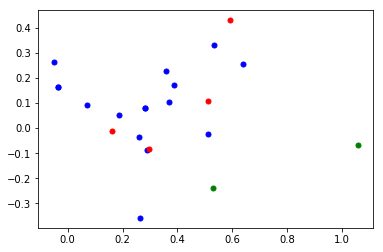

0
思维不打卡了 不补签就不打卡了 我date不打卡啦 扫不进去  我不进了
1
不打卡了 以后不打卡了 不睡觉打卡了 我还不打卡了 不提醒打卡了 你也不打卡了 不打卡 不给我打卡 我说我不打卡了 怎么不可以打卡了 没有我就不打卡了 我现在怎么不打卡了 我不想打卡了我不睡 我怎么不可以打卡了 什么我忘打卡,是打卡了不显示 早睡打卡可以取消吗
2
今天不打了 今天打不出来了
361.3864080765794


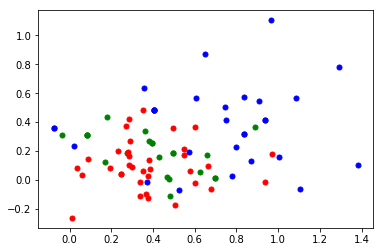

0
什么时候有的抽奖 是怎么抽奖法 怎么符合抽奖条件 我怎样才知道本月有没有中奖呐? 我不能参与了吧 共同打卡 抽奖 哦!还有九天我们可以抽奖对吗 您好 我早上收到和一个好友共同打卡天数的抽奖图 当时没注意 删掉了 请问哪里可以找到呀 谢谢 什么时候我能参与抽奖 我怎么不知道可以抽奖 不知道咋抽奖[Facepalm] 怎么样才有抽奖号码 打卡21天去哪抽奖呢 别人能抽奖我怎么不能 抽奖码什么时候用? 我想知道那抽奖码儿是啊!你们丑还是我们丑 抽奖是平台抽不是我们抽对吧 抽奖码是什么 有个抽奖内容怎么说 自动公布抽奖结果吗? 那个可以抽奖优化手表啊 系统自动抽奖?是吗 抽奖池在那 是系统自动抽奖还是 在哪里出抽填入抽奖码 我想知道啥时候抽奖 怎么知道抽奖码中奖了 抽奖码怎么使用 昵称:大王。 抽奖码:eb3b5a。 联系方式:13917603792 怎么知道中奖没有 抽奖码需要填上吗 怎么知道抽奖结果 打了这么久也没有听说抽奖啊 问你在哪个地方有抽奖塞 都36天了没见抽奖?
1
抽奖 抽奖结果 抽奖是啥 抽奖活动 如何参加抽奖 打卡抽奖 不是可以抽奖吗 怎么抽奖 怎么抽奖啊 iphone抽奖 怎么参与抽奖 怎么才能抽奖 我现在可以抽奖?怎么操作? 参与抽奖 咋去抽奖啊 如何抽奖 天天打卡抽奖多少 活动 怎样抽奖 您好!怎样抽奖呢 我怎么没有抽奖卡 我有抽奖卡吗 抽奖是怎么弄的呀 咋抽奖 抽奖活动链接 什么抽奖 这个抽奖是怎么抽奖的 怎么抽奖呢 请问怎么参加抽奖 抽奖卡
2
在哪里抽 上哪里抽奖 在哪里抽奖 抽奖要去哪里啊 去哪儿抽奖 去哪抽奖? 在哪抽奖 抽奖页面在哪里 在哪里抽奖啊 在那里抽奖 哪里抽奖 哪里抽奖? 去哪抽奖 去哪里抽奖 在哪抽 抽奖在哪抽 在哪儿抽奖 哪里可以抽奖 哪抽奖 活动在哪?如何抽奖? 活动抽奖在哪里找到 请问在哪抽奖/::)
0.49821395012810316


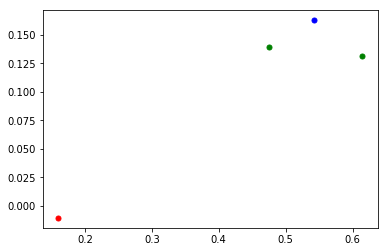

0
中奖人是你们内定的?
1
抽奖作弊
2
严重怀疑抽奖作弊 我怀疑抽奖作弊
137.15136064649718


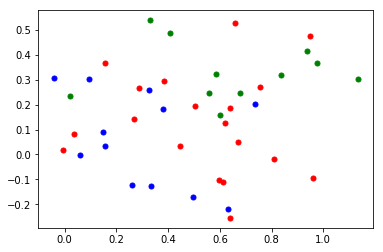

0
抽奖码是啥 怎么获得抽奖码 抽奖码:e9637b 抽奖码 要把抽奖码填到哪里吗? 这个抽奖码干嘛的 不用输入抽奖码吗? 有抽奖码不知道在哪里点抽奖? 什么时候我能参与抽奖 什么时候能抽奖?需要自己操作吗? 怎么样才有抽奖号码 我为什么没有抽奖码 有抽奖码以后我怎么参与? 没有看到抽奖链接 怎么参加去抽奖?我这里现在有那个验证码 呼叫号码不知道怎么抽奖啊 我现在只有抽奖码 每天打卡需要发朋友圈才能参加抽奖吗 我的抽奖码是什么
1
怎么抽 在什么地方抽奖 怎么抽奖?方式?往哪儿进?概率多大? 哪有抽奖池 还有那个兑奖码有什么意义?又如何使用? 抽奖池在哪 抽奖吗在哪用啊 抽奖券 去哪里抽 就没看懂这码抽奖怎么用 哦哦两个人都可以抽吧 抽奖码去哪看中奖了
2
怎么抽奖法 怎么才能抽奖 抽奖码有了怎么抽奖 怎么抽奖啊码?抽奖b4159c 如何抽奖? 抽奖是怎么弄的呀 这个抽奖是你们抽吗 我有抽奖码到哪去抽奖啊? 抽奖吗 抽奖活动还有吗 在那可以抽奖
69.96604391192503


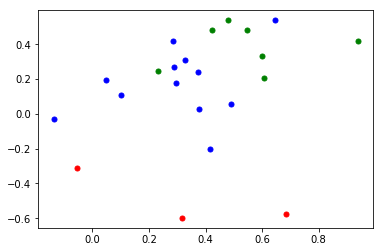

0
中奖名单出了吗 从哪里看中奖名单 中奖
1
什么时候我能参与抽奖 抽奖码什么时候用？ 啥时候抽 抽奖码是什么时候使用 是系统自动抽奖还是 我有抽奖号啊!怎么使用啊 看完抽奖码怎么用?还是没明白 够21天。去哪里抽奖 抽奖码是自动抽取吗?攻略看完也没明白要做什么 啥时候抽奖 抽奖码怎么用在哪抽 请问共同打卡21天后去哪里抽奖
2
那个抽奖码什么时候能抽奖 抽奖码我怎么用?什么时间抽奖?我怎么参与抽奖的 抽奖哪里抽 如何参与抽奖活动 怎样参与抽奖活动 我要参与抽奖 现在能抽奖嘛
37.590140860169136


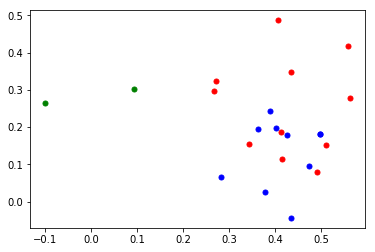

0
抽奖码有什么用？ 打卡抽奖码有什么用？ [AI]打卡抽奖码有什么用? 抽奖码是怎么抽的呢 抽奖码作什么用 抽奖码有什么用?怎么抽奖 抽奖码是干啥的 怎么抽奖 抽奖吗怎么用 抽奖怎么抽 怎么抽奖
1
抽奖码怎么用 抽奖码怎么用啊?投放到那里啊? 没弄明白抽奖码怎么用 抽奖码是干嘛的 抽奖码如何用? 请问如何使用抽奖码 抽奖码在哪里用 什么时候用抽奖码呢 小来抽奖码在哪里用啊 怎么用抽奖码
2
我这月如何抽 怎么抽?
99.53559256333054


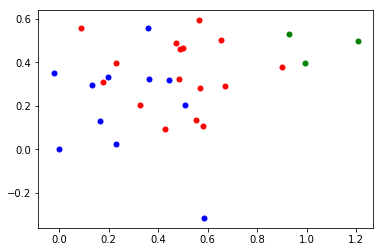

0
召集好友打卡团 可以把打卡团发出去吗 想加入晨起打卡群 我的打卡团 建立打卡团 打卡团并不是群啊 新建早起打卡团 如何创建团队打卡 建打卡团 早起打卡团 建早睡打卡团 那查看我的打卡团 搜索早起团 如何加入打卡团 怎么邀请我的好友进打卡团 怎样创建打卡团
1
打卡团为什么参与不了 组团打卡 多少人成打卡团 打卡團 如何进入北京早起小分队 怎么拉人进打卡团 为什么别人的打卡图有多少多少人正在参与 两广州总督打卡团的群呢 打卡团在哪里打开 请问怎么弄团队 打卡 并看到团队的日程 团卡
2
打卡群 创建打卡群 微信打卡群
0.20475460480470392


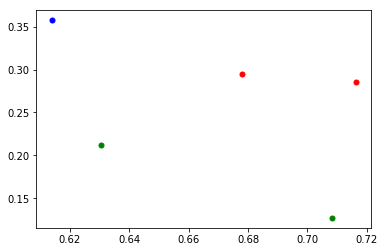

0
为什么加入打卡团显示暂未打卡？ 为啥加入打卡团显示暂未打卡？
1
为什么已经打卡了加入打卡团显示暂未打卡？
2
加入打卡团显示暂未打卡是怎么回事 加入打卡团显示暂未打卡是咋回事？
234.56211595981603


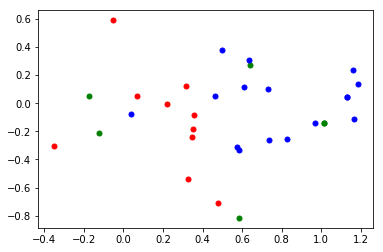

0
菜单在哪？ 我要星巴克 我想外卖星巴克 今天可以吗 我想买星巴克 星巴克在哪里可以下单 怎么没法点咖啡了 没有星巴克了么 星巴克菜单 星巴克菜单有么 怎么下单呀
1
怎么订咖啡？ 怎么订咖啡 辛巴克 送杯咖啡到学校 给我送杯咖啡 有提供咖啡吗 coffee 预定星巴克 送咖啡到欢乐谷 需要订咖啡 如何订星巴克 送杯咖啡到家 想喝星巴克 我要定星巴克 帮我订一杯咖啡吧 怎么订
2
可以点咖啡吗 我要咖啡啊 星巴克 咖啡 要一杯咖啡 定咖啡
22.036995471628625


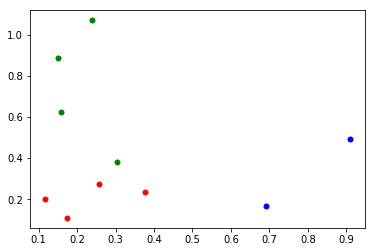

0
可以叫首汽吗？ 可以叫易到吗？ 可以叫神州吗？ 可以叫优步吗？
1
可以叫滴滴吗？ 你们是滴滴打车吗?
2
你们叫车是什么平台 小来可以叫哪些平台的车 你们叫车有什么优势吗 都有什么打车平台？
47.369143413669136


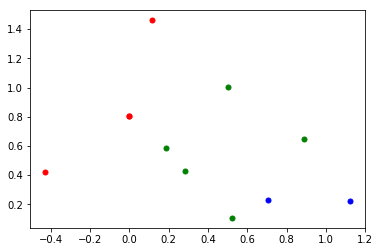

0
如何打车？ 怎么叫车 怎么打车 怎么打车呢
1
可以给我打个车吗 怎么打的
2
在来也打车呢 为什么打车 打不了 打车业务还有没 怎么没有打车服务了 没有叫车服务了吗
13.804108715061364


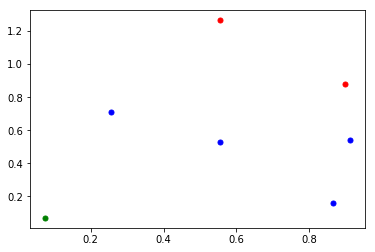

0
滴滴商务车 就要商务车的
1
可以打七座车吗？ 有七座车吗 请帮我订一个七座车 有没有商务车
2
可以叫7座车吗
4.771839230201707


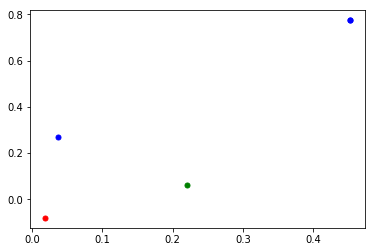

0
拼车行不行
1
可以拼车吗？ 能不能拼车 能拼车吗？
2
是否可以拼车？
19.2184835465494


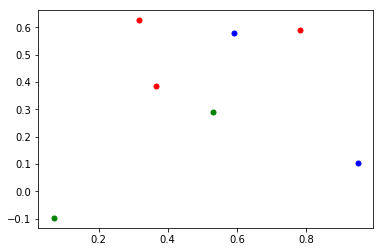

0
还没叫到车 在叫车了吗 有没有车啊
1
有车吗 还没车啊
2
怎么看司机在哪？ 车到哪了
20.309190832572988


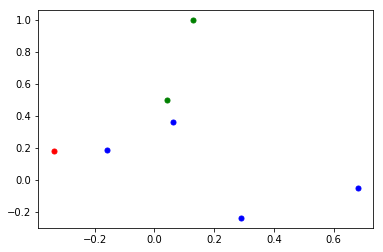

0
可以开发票吗？
1
发票怎么开 发票是什么类型的？ 单次可以开发票吗？ 不论叫什么车都可以开发票吗？
2
叫车可以开发票吗 打车可以开发票吗
6.665106327928198


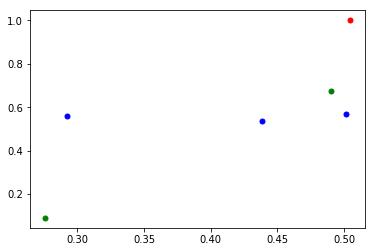

0
没有叫车服务了吗
1
请问没有包月打车服务了吗 还有包月打车服务了吗 有没有包月打车服务了？
2
还可以包月打车嘛？ 是否还可以包月打车吗
6.300808519530284


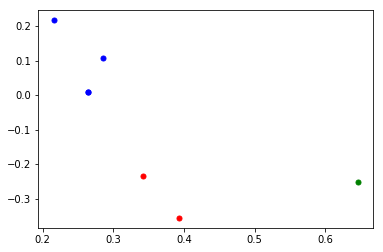

0
我还没回家呢 你敢带我回家吗?
1
我想回家 想回家了 小来我想回家 我想回家怎么办
2
下班回家
16.421001837737812


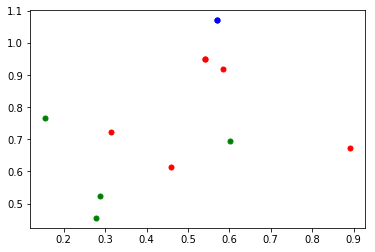

0
可以打顺风车吗 顺风车 顺风车可以? 来也顺风车 需要顺风车 顺风车不可以?
1
可以预约顺风车吗 能预约顺风车吗?
2
看能不能有顺风车之类的 你们可不可以顺风车 帮我查下顺风车吧 现在能否预约顺风车
51.30862118003278


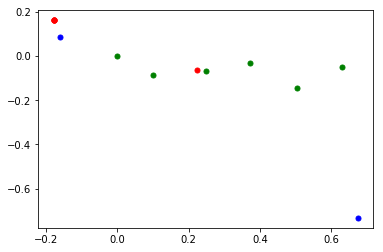

0
这个司机态度不好 司机态度也不好 司机态度很不好 司机态度不好 而且司机态度不是很好
1
司机找不到 师傅找不到路
2
司机拒载 没上车怎么要付钱 不懂 那司机态度极差,差评 无法取消订单,司机点错了 沒上車
2.2507404144097407


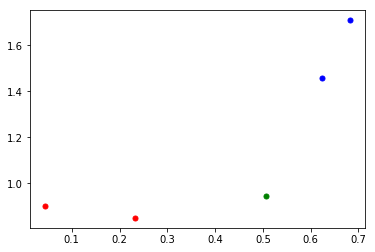

0
能不能帮我预约叫车 能否帮我预约叫车
1
预约叫车 帮我预约叫车
2
预约叫一下车
6.488909493735228


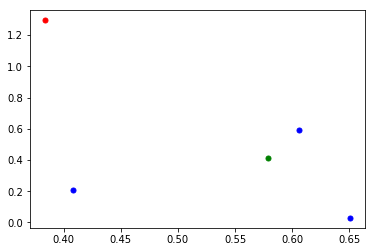

0
接机
1
送机 麻烦定个接机,date_time到airportflightno 送机订好了吗?
2
难道没有预约接机呢
11.083899890276689


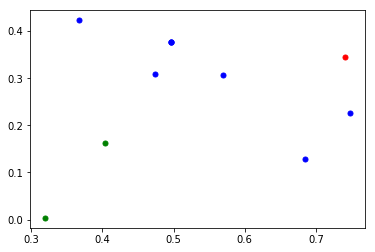

0
打车券
1
打车券怎么用 打车券怎么用啊 那打车券怎么用? 我的打车券怎么用? 送的打车券怎么用 如何使用打车券? 可以用打车券不 滴滴券怎么用
2
20元打车券怎么用 打车券可以转赠吗
2.40784874198321


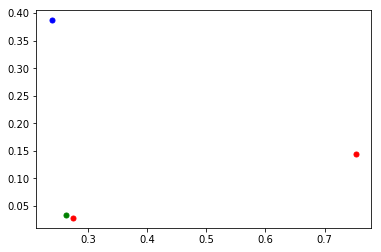

0
不是叫车,是开之前的发票 补开打车发票
1
我需要打车票报销
2
我需要发票报销
22.984158077510216


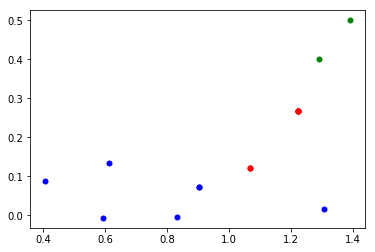

0
我上车了 上车了 上车了。 嗯上车了 我上车了哈 嗯上车了哦 上车啦
1
上车了,谢谢 已经上车了 我已经上车了 上车了, 都已经上车了 已上车了 好了,上车了
2
我坐上车了 坐上车了
6.959902186025796


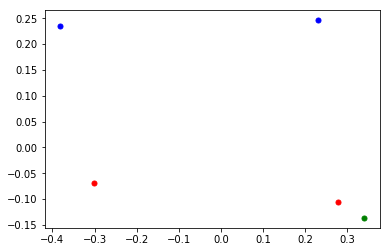

0
再叫 麻烦再叫下
1
继续叫 重新叫
2
司机打我电话来说要30分钟
14.149422104322747


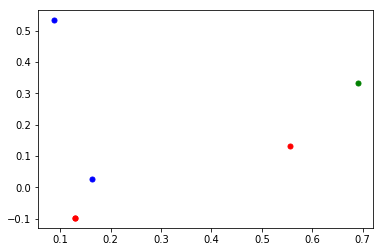

0
我叫到了 我自己叫到了 我自己交到了
1
不要车了 你不要老是发叫车的信息嘛
2
取消用车
4.194439528432029


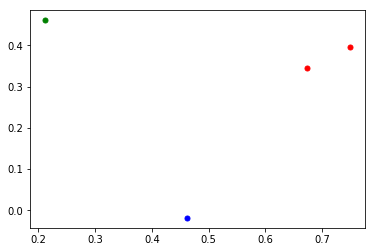

0
换一辆吧 能帮忙换一辆大的么
1
取消换一辆,他刚打电话说去不了
2
在叫一辆?
37.62364599174437


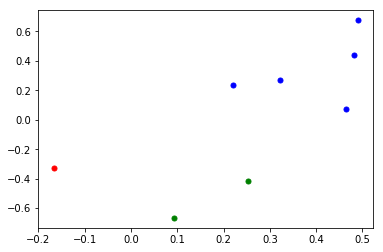

0
包月套餐
1
打车包月 包月计划 包月详情 包月計劃 怎么查包月计划余量
2
剩余里程 如何知道剩余公里数
18.20752870533342


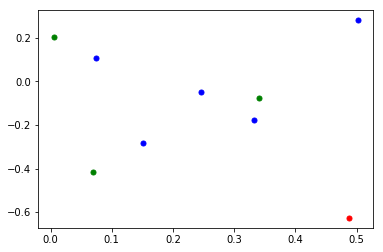

0
可以退没用完的里程吗
1
里程用完要重新包月对吧? 刚才的订单请用包月里程支付 包月打车的钱退给我了吗? 帮我包月里程里扣 请用包月支付上一用车订单
2
麻烦帮我看看是怎么处理,里程续存还是就过期作废了 我买的里程数不用用现金,那我没有再续的必要了 月卡时间当月未用或未用完的,是可以累计到date,还是就作废了呢?
70.93898714581157


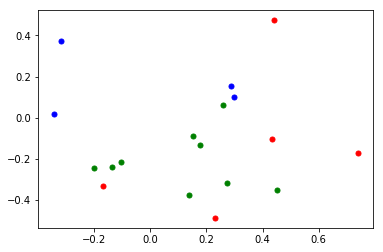

0
购买包月 购买包月套餐 买包月 包月套餐 包月
1
我要包月 包月畅打 包月榴莲 我要包月100公里
2
加油包 我要买加油包 我要冲加油包 充值,加油包 购买加油包 里程加油包 包月加油包 我要买30公里加油包 购买里程加油包
11.737495606425028


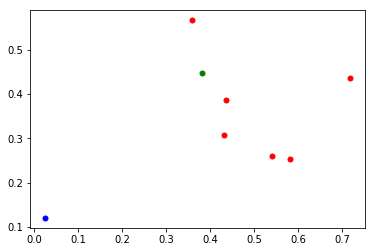

0
包月打车怎么用 包月用车券,怎么使用? 使用包月用车券 请问包月用车券怎么用 包月用车券 有包月打车券
1
我想问下 我的包月里面 可以叫好点的车型吗
2
包月用车
16.135936193191178


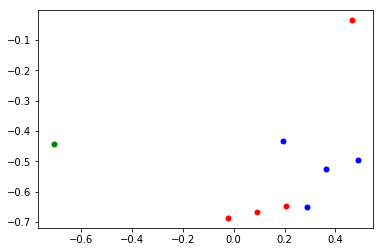

0
那我的包里程卡还剩多少里程 麻烦帮我查一下上次里程包还剩多少里程 剩余里程 月卡里程
1
我还有多少里程数 我现在剩余里程是多少? date的包车里程还剩多少? 这就是说我买的是里程数
2
里程
25.455151580803584


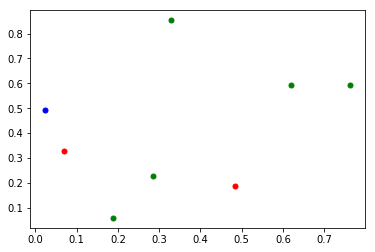

0
系统稳定吗 为什么你的信息是秒回
1
如何使用
2
为啥使用小来呢 为什么使用小来？ 为啥要用小来 为啥要用你们 助理来也好用吗
6.26279620000556


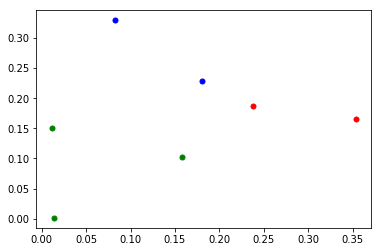

0
都有啥服务品类？ 服务太少了
1
都有什么服务？ 你什么服务啊
2
服务种类都是什么 有什么服务品类？ 有哪些服务种类？
24.118140288150236


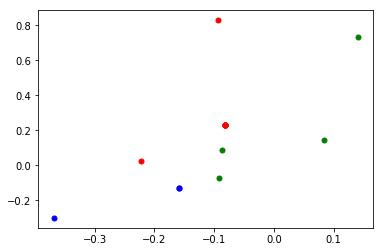

0
这是什么平台 什么软件 这是什么软件 这个什么软件 这是什么软件? 这是什么软件… 这是什么软件啊 这个软件有什么功能
1
这是一款什么软件 这是一个什么软件 这是一个什么软件?
2
您们是什么乱软件 这个公众号的作用是什么？ 这个软件的作用是什么 这个APP的作用是什么
7.968065479693878


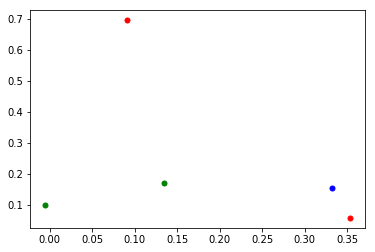

0
一开始想问下咱们的服务区域 服务不到位
1
服务范围
2
你还有什么技能 中西区有什么东西可以服务的吗?
290.3160356590095


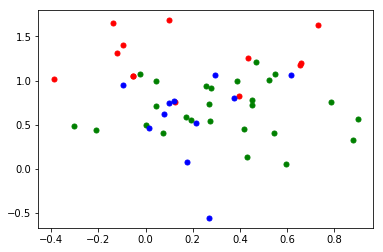

0
都能服务哪些地区？ 覆盖的区域有哪些? 覆盖城市 哪些城市 支持城市 服务城市 覆盖配送哪些地区 服务地区？ 有哪些服务地区？ 服务地区有哪些？ 你们没有覆盖我们城市 提供服务的地区有哪些? 哪些地区可以用来也
1
长沙可以用吗 长沙可以用来也吗 覆盖范围? 沈阳有嘛 什么时候长沙有? 我这边有吗? 你们波及到郑州了么 成都可以用吗 青岛有助理来也吗? 南京有来也么 广州 武汉有么
2
长沙有服务吗 长沙能用你们的服务吗 关键我要知道覆盖了哪些区域? 服务区域 服务区域是哪 覆盖的类型 都能服务到什么地方？ 能服务到哪里 为什么常州地区没有覆盖 杭州小来有哪些服务?? 我们这里没有你们的服务 有没有地域限制的 你们只有北上广服务吗 现在太原提供帮助吗？ 服务的地理位置呢？厦门可以吗 所在区域无法下单 那在哪些地方提供咖啡配送服务呢 福州没有服务? 福州有什么服务 上海有业务吗? 可以服务孝义市么 你们深圳有业务吗? 杭州能服务到吗 你们现在已经开通了哪几个城市 这个地方可以提供服务吗 如果不在覆盖城市内可以使用小来吗?
1.4733364074562354e-32


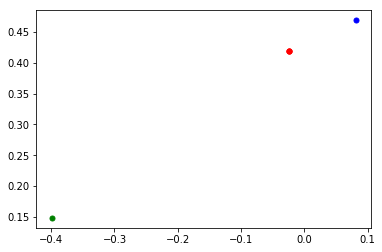

0
你们怎么挣钱 你们这样，怎么挣钱啊 请问你们怎么挣钱啊？
1
来也怎么盈利
2
如何盈利
7.599282307702833


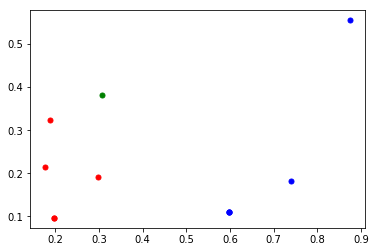

0
有什么新功能吗 就是问问现在现在有啥新功能呀 你们有什么新功能 小来有什么新功能 有哪些新功能?
1
最近有新功能吗 最近有什么新功能嘛 你们最近又开发啥新功能了? 最近有什么新功能? 你们最近有什么新功能呀
2
我就试试你的新功能啊
51.97744377845033


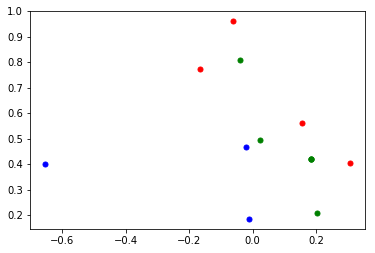

0
怎么操作 我还不知道怎么操作呢。 我不会操作 我自己可以手动操作吗?
1
不会用 我不会 好多功能不会用
2
如何使用 怎么用 怎么用? 这个怎么用呢 这个助理来也要怎样使用呢 这个怎么玩的,是什么意思?
135.2868275164333


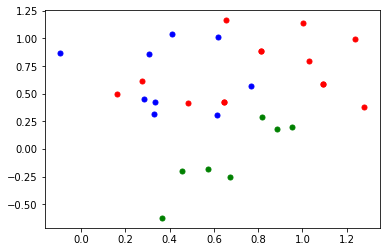

0
你是客服? 我要客服电话 客服电话 客服电话打不通 客服呢 客服在吗 有客服吗 有客服吗? 在线客服 呼叫客服 我要找客服 客服在嘛? 怎么联系客服 客服客服客服
1
需要人工客服对话 我要人工服务 让你们人工客服看下我的内容 人工客服 反馈通道是啥 你們有人工客服嗎? 我要人工沟通 我需要人工客服解救 没有真人客服嘛
2
客服电话是多少？ 你的手机号码多少? 微信客服热线是多少? 你的电话多少，能不能电话联系 你们电话号码多少 客服电话多少 你们公司电话多少
13.035992368426793


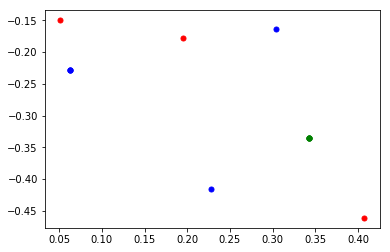

0
新客有没有优惠券 date有优惠券没 我好像有优惠券
1
有没有优惠券吗？ 有没有优惠券 有没有送优惠券 有没有优惠券呢 有没有星巴克的优惠券
2
有优惠券吗？ 优惠券有吗 有优惠券么 有优惠券吗
621.298999057743


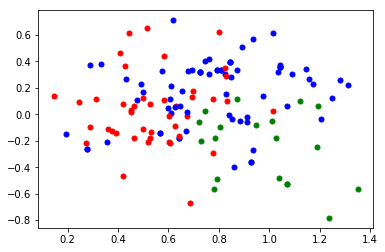

0
改成13527863542 以前手机已经停用了 我要更换手机号儿 更换手机号,telnum 怎么改成别的手机号 怎么改绑手机号 小来,我手机号码换成18916102305,怎么改过来? 我的账号不能登陆了 小来?我原来注册手机不用了,现在登陆不上去 想换另一个微信,咋连接啊 说此微信已经绑定了别的手机号,不能修改 那个号码已经找不到了 我为什么我的账号登不上 可以的话我就拿我自己的微信号绑定我自己的手机 我要绑定自己的微信号 我这个微信绑定了其他手机其他手机不用了怎么办 您发的手机号已经不用了 绑了我以前的手机号 怎么登手机号 我这个微信号 手机号验证时说微信绑定手机号不同 不能登陆 能不能换绑微信号 我换了手机号 所以下不了订单了 说微信号已绑定其他手机号 我之前绑定了手机已经不用了 我之前绑定了手机已经不用了。现在需要验证手机。 我有两个手机号 我的手机好之前绑定过另一个微信号,如何解除呢 小来,可以换个电话号码叫我去床吗 我想换一个手机号码 我之前不知道绑了什么手机号 为什么说我的卡绑定过其他号 为什么说我的号绑定过其他的 什么总是提示手机已经绑定了其他微信帐号 微信号绑定的电话不能改吗 我没绑定过其他微信号 我的手机号换了  之前的不能使用了  现在要我验证手机号才可以使用助理  所以想请问怎样可以更换手机号 我能解绑我这个手机号吗?我换微信了 这个手机号  在我老微信上绑定过来也 你不能解绑吗 解绑手机怎么操作 你好 能帮我解除原来的手机号吗 手机修改有故障，15928697089手机早已注销，微信也已更正手机，此处却无法更新
1
怎么修改手机号？ 更换绑定手机号 更换手机号码 修改手机号 修改手机号码 更改手机号 变更手机号 解绑 修改电话号码 怎样更换手机号 怎么更换手机号 更换手机号 如何更换手机号 我想更换手机号 我要更换手机号 手机号更换了 如何更换手机号? 怎么更换手机号? 手机号绑定错误如何更换新手机号 我想更换手机号怎么办 我想更换手机号码 手机号更换了怎么办我 怎么更改绑定手机 手机号怎么修改 我想修改绑定手机号 怎么修改提醒号码 怎么修改绑定的手机号 怎么更改手机号绑定 怎么更改绑定手机号 怎么更改绑定的手机号 我怎么更改绑定的手机号 我绑定的手机号怎么更改 怎么修改手机号 怎么绑定手机号 我想修改绑定的手机号 怎么修改原来绑定的手

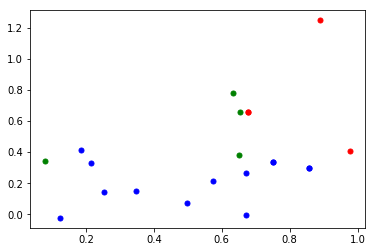

0
怎么投诉？ 投诉助理 怎么投诉 我现在就立马投诉
1
投诉你 我要投诉你 我投诉你 麻烦你投诉 我可以投诉你 我还要投诉你!!! 你说你投诉,我怎么知道你投诉了??? 我投诉你两次了 一个小时还没送到,也是没sei了!可以退订吗?午饭都要送来了/::@ 你不讲我投诉你 信不信我叫全部人投诉你? 关于如何投诉快递 想要被我投诉吗?
2
投诉小哥 我要投诉小哥 投诉跑腿 投诉阿姨
137.16395597321278


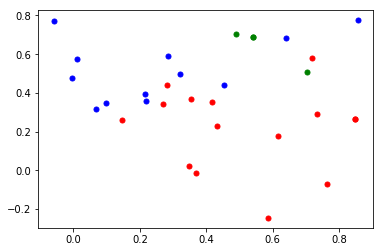

0
可以发语音吗？ 能给你发语音吗 可以发语音吗 听说可以发语音 可以加段语音吗 为什么小来不会发语音 你好我的意思是我可以给你发语音吗? 不是能发语音吗? 发个语音说好吗? 很久没有和我说过语音了 会讲语音吗 哎你能不能发语音啊?气死了 直接说语音吗 请用语音回复吗 可以发语音新建日程吗
1
能跟你说话吗 怎么读? 可以语音和我聊天吗 你可以用语音和我交流吗? 你能读给我听吗 语音给我听 有本事语音聊天 想听听小来的声音 你能听语音吗 什么时候你可以语音聊天呢 你能用语音说话吗 你会不会语音聊天啊
2
能用语音？ 能语音？ 语音说话 还可以语音
0.29107766940785185


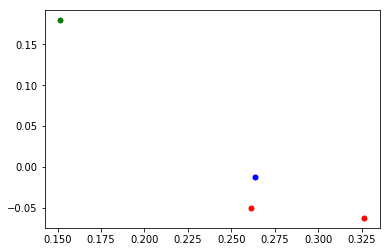

0
下来下来你喜欢什么样的女孩呢, 你喜欢什么样的女孩
1
你喜欢什么样的女生
2
什么样的女生你比较喜欢
93.62162738604991


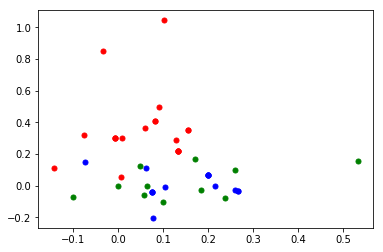

0
小来是男是女？ 你是男的女的? 你是男的女的 你是男是女 你是男的还是女的 你是男助理还是女助理 你男的女的? 你是女的 助理来也 你是男的女的 女的 你是女的吗 你是男的是女的 你是男的？ 那你是男是女 小来你是男是女 那你是男的女的？ 小来是男是女 你是男是女？ 我希望你是女的 我希望小来是个暖男
1
你是女生还是男生? 你是男生还是女生？ 你是男生还是女生 有女生吗 你是女孩还是男孩 小来,你是女生吗 你是男孩子还是女孩子 你是男人还是女人 你是男生吗 所以你是男生咯 你是女生还是男生 你是男生? 你是女生? 你是女生吗? 你是女生吗
2
你是美女吗 你是小妹妹吗？ 那你就是男孩了 你是girl还是boy BaD    Girl       坏女孩 你是不是小美女啊 你是♀的还是♂的 你少来你是男孩女孩 你是好人吗 话说你是个汉子吗 ……我还以为你是真人呢/::)
78.36771850963555


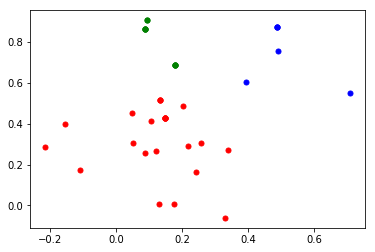

0
你是机器人小来吗 小来你是机器人吗 小来,虽然你是机器人 小来你是不是机器人 你是机器人还是啥 你就是个机器人 你是机器人么 你是机器人吗/:,@P 明明就是机器人 你是机器人吗？ 你不是机器人么？ 小来你是机器人么 你是机器小来吗? 你是系统 你现在是机器吧 你是机器人吗 你是机器人? 你是机器人 小来,你是机器人吗 你是AI對吧 你是不是机器人 你是AI吗 怎么成精了 忘了你是机器人了
1
是机器人还是真人？ 你是机器人还是真人？ 机器人还是真人？ 真人还是机器人？ 真人还是机器人? 不是人工?
2
小来是机器人？ 机器人小来 机器人小来? 小来机器人 机器人小来. 小来是机器人吗 小来是机器人吗? 原来小来是机器人啊 机器人？ 机器人?
928.1897318728542


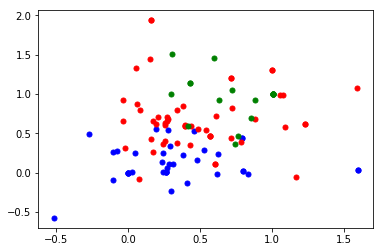

0
小来是真人？ 你是真人还是机器人 小来。你是人工的么 你是人工还是智能? 自动回复? 你是真人吗? 刚才这段对话是机器处理的还是人工处理的 你是真人吗 你现在是人工还是智能回复呢 你是真人 小来真人在吗 呼叫真人助理。 助理呢 助理 呼叫真人助理 助理在吗 助理在吗? 人呢? 转人工 呼叫小来 呼叫 小来小来 人工出来 我要真人 男助理 女助理 要真人电话 我的助理团队不在了？ 怎样能找真人助理 来个真人处理 真人帮个忙吧 就人工吧 呼叫真人小来 我要解决问题的真人 我的助理呢? 真人助理出来应答 真人小来回话 有人工吗? 小来 人工服务 要真人服务 有人工么 有人工在吗 转人工了吗 你们现在没vip但是有其他的人工业务吗 有真人在吗?不要机器 客服在么 人工服务有没有呀 真人长得好看吗 真人什么样 真人都什么样的 真人助理长什么样 真人助理是什么样的？ 我知道你真人
1
你是人吗 你是? 让我猜猜,是人工还是自动回复[Hey] 你是 你是活的吗? 人工还是机器人 好神奇? 你不是机器的吗?你是真的吃还是假的吃啊。 你们自动回复能不跳出来么... 反正你是自动回复 你应该是真的人吧 人为? 你是自动的还是手动的 你現在是真人還是機械人回覆我? 你昰电脑操作的吗 我想问一下 问一下 出来 来个活人 有人吗? 有人在吗 有人在吗? 有人么 小来在吗? 有没有人 小来在么 小来,在吗? 你在吗 强制派发,需要真人助理处理 你什么时候变成真人 小来,需要帮忙 你们金山有咖啡小哥吗 直接呼叫你就可以了? 好的。那帮我下单吧 请问你们是在耍我吗 帮帮忙嘛 211在么 你们电话怎么老打不通 有人? 你是活的吗？
2
人工小来 真人服务 真人 人工助理 真人! 真人助理 真人小来 真人? 真人呢 人工呢 真人吗～ 真人？ 人工? 来也真人 真人有吗? 没有真人了啊 是真人吗 需要真人
75.77795009202448


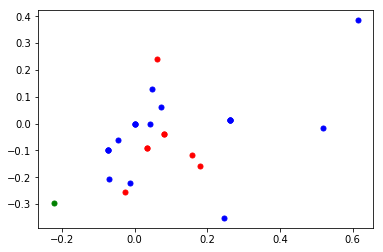

0
你叫什么名字 你叫什么名字? 你有名字吗 助手你叫什么名字 你叫啥子名字哦 你叫啥子名字啊 我应该叫你什么名字 你名字的小名是什么
1
你叫什么？ 你叫什么 你叫什么? 你是谁 你是谁呀? 那我叫你什么 你是谁? 姐姐,你的真名是什么呀? 你好,你叫什么? 请问你贵姓? 我是小去 叫你什么好呢? 你叫啥 你是哪个哦 你叫啥啊 忘了问你叫啥 你叫啥呀 我的昵称改为东我叔叔 你的大名叫什么?
2
这是什么
18.011315890038944


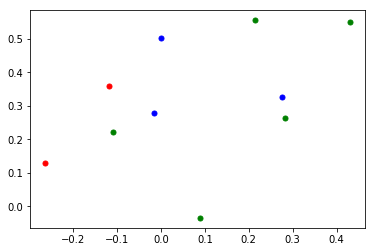

0
你们是如何盈利的呢 你们怎么盈利
1
你们挣钱吗 这模式怎么挣钱？ 你怎么挣钱
2
盈利模式是什么 有没有打算进入其他亚洲市场? 你觉得进入其他亚洲市场是来也能实现的机会吗 来也现在多大规模了 那你们几百万客户怎么服务的了
2.51311451584821


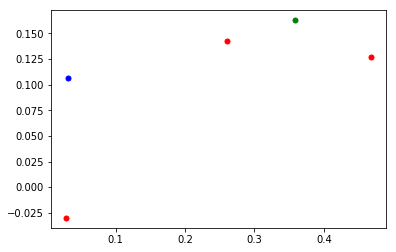

0
认不认识小娜 你跟小娜熟么？ 你跟小娜熟悉吗
1
小娜是谁
2
知道小娜吗
5.570097420360411


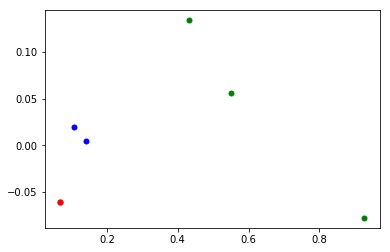

0
如何置顶？ 如何置顶?
1
我要置顶你！ 这么棒,肯定要把你置顶
2
我想置顶 怎么置顶呀？ 置顶置顶
2.999643285206945


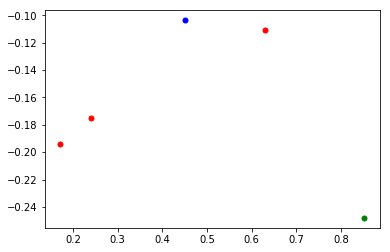

0
置顶有什么用 置顶有啥好处 置顶有什么好处
1
为什么要置顶
2
干啥置顶？
621.9217549956721


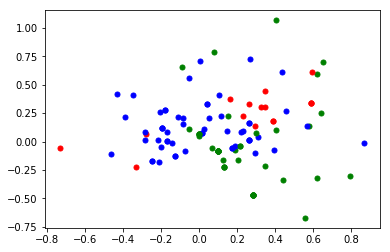

0
所有的功能 你能提供什么服务? 你提供哪些服务 你会提供哪些服务呢 能提供什么服务 那您提供什么服务呢 小来可以提供什么服务 可以提供哪些服务 那哪些服务有提供 能提供服务么 你们能提供服务吗 你们还提供服务么 功能 但是你们又啥服务呢 我需要秘书服务你能提供吗 有什么功能
1
你能干啥 你都有什么功能 你会做什么 你能做什么? 你能做些啥呢 你还有什么功能 你还有什么功能? 你还有什么新的功能呀? 你能做什么 小来可以做什么呢 你会什么 你能做啥 你能做些啥 介绍介绍你还能做什么 小来，你能做啥 亲爱的，这个平台做什么吗 你是谁 这是做什么的 小来可以做什么 你们做什么 你有什么用 你都会什么? 你可以帮助我什么 我要你有何用 你都会干些什么呀? 你会做些什么呢？ 你能为我做什么? 你都会什么技能 你都可以帮着做什么? 现在要做些什么 这有什么用 这个关注号是做什么的 你可以为我做什么呢 你都会啥 小来都可以做哪些事情 我想问一下 在这个系统里 我是否能学到些什么东西呢? 你会吗? 帮我做些什么事情 你能解决什么问题(O_O)? 可以帮助做什么事情 我要你何用!! 我不知道这个都能做什么 你能做些什么 其他做什么? 你有什么能力 助理来也是做什么的? 你都能干啥呀 我去 什么软件 你们现在这个软件做得怎么样了 请问你是谁 请问你有什么功能 你除了会机械的说这些东西之外没有别的功能了吗 你还会什么 你是谁呀 这个玩意还有啥功能 我不知玩什么
2
你是干什么的 你可以干什么 你可以干什么? 你都能干什么 那你能干什么 你到底会干什么 你还能帮我干什么 你都能干什么呀, 我可以用你来干什么 你可以干什么呀? 你都会干什么? 那你还能干什么 你都会干什么呀, 你能够干什么? 你能干什么 你会干嘛 你还能干嘛 你都能干嘛 你可以干嘛 你都会干嘛 那你能干嘛 你能干什么? 你能干嘛 你会干什么 你会干什么? 你会干啥 为啥使用小来呢 你干嘛的。 他这个软件是干嘛用的? 这事干嘛用的 不知道干啥的 你还能帮我干啥 来也公司是干什么的 小来能咋的 干嘛的这是 这公众号都能干什么 你能陪我干什么 机器人可以帮我干什么 这个公众号干嘛用的 你会干嘛呢 小来你会死吗 你会干啥呢 这是干什么的 在这里还能干什么啊
39.95968686775923


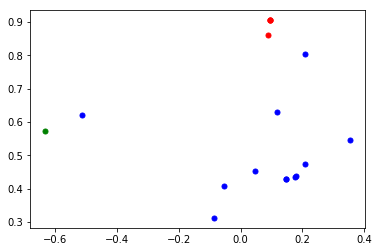

0
机器人 机器人机器人 机器人就是机器人 机器人小来
1
有机器人吗 我要机器人 我是机器人 还是机器人 机器人有没有 我想要机器人 你是男机器人还是女机器人还是变性机器人 你是机器人啊 你是机器人吗 笨笨机器人 怎么变成机器人了 机器人你好
2
机器
2.3534502646018924


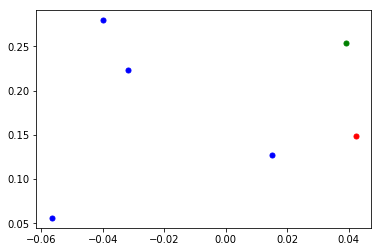

0
小来你有女朋友吗?
1
你有男朋友吗 你有男朋友或者女朋友吗 你有男朋友或者女朋友没有 有女朋友或者男朋友吗?
2
你有没有男朋友呀?或者是女朋友你是男的还是女的呀?
222.87230643398172


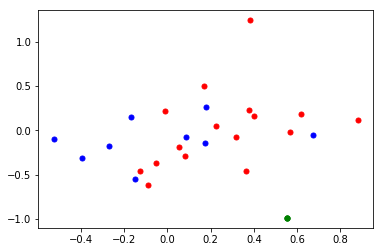

0
要钱吗 花钱吗? 订阅星座收费吗 订阅或服务什么的收费是多少? 请问订阅都是免费的吗 请问订阅付费吗 用这个软件要不要钱 要收服务费吗 你是免费的么 星座运势是免费的吗 选星座测运势免费吗 获取心语签收费吗 小来打电话要不要钱 你的打卡游戏免费吗 关注这个公众号平台收费吗? 小来你好,订阅心语签收费吗?
1
怎么收费 收费吗? 要收费吗 你这个服务收费吗? 有费用吗 你好!你们这收费吗? 成为vip收费吗 需要费用吗 如何收费
2
这是免费的吗 免费吗? 免费的么
69.25932246183736


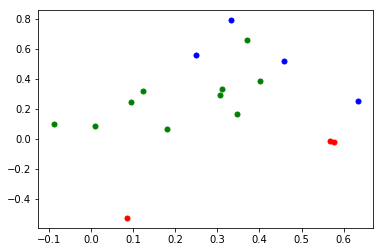

0
这个星座是不是免费的？ 免费订阅吗? 订阅是免费的吗
1
想试试每天打卡，收费吗? 电话提醒收费吗? 助理来也'打卡收费吗 打卡要钱吗
2
订阅要钱的吗 订阅要收费吗 订阅东西收费吗 订阅要不要收费的? 订阅有费用吗 那你能查询到 我有没有订阅收费的项目 订阅花钱吗 订阅掏钱吗 订阅星座收费不 订阅东西不收费吧
46.317320372869816


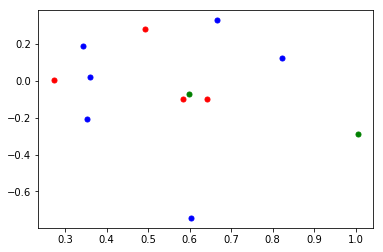

0
签到有什么用？ 签到是什么？ 什么是自动签到？ 关于自动签到
1
我怎么能收到那个一句话的图 怎么才能收到签到图图 怎么能每天收到心语签 精美图 早安语在哪看呢 为什么心语签取消了呢?
2
怎么早起签到 早起签到
202.7657882812997


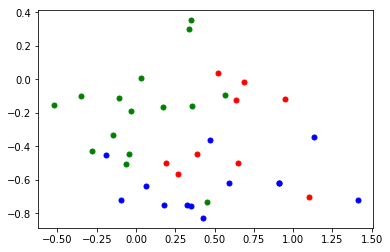

0
早安语 想要个正能量早安语 我需要早安语 图片早安的 我想要每天早安语 我想要那些励志的早安问候语 早安朋友圈正能量句子 有没有早安的照片 我想要早安祝福说
1
签到图 签到图片 签到了怎么没有图片呢? 有什么图片 给一张图 好看的图片 还有一张图呢 带文字图片 好看的图片有木有 签到图片呢? 给我找一张好看图片 每天一张图 励志图
2
我要一张暖心的图片。 美图 不新鲜……原图 图卡 小来,请问一下每天只能一个图片吗 给我一张热爱生活 热爱工作的图片 给我一张早上好的图片 每日一语怎么没有了 我怎么没有每日一语了呢? 给我一张心语便签 我想要这种卡片/:rose 我要看美图 我要美图 从发一张图片过来 每一次正能量句子
812.2206196619618


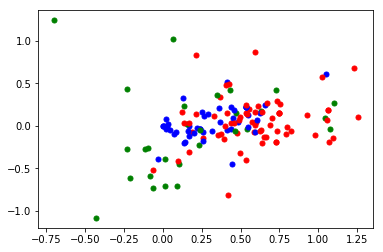

0
每天一张心语签 心情签 心语篇 心语 心语卡 怎样才能拿到心语签? 心语签 请问心语签怎么弄? 还有不一样的心语签吗 早安签 心愿签 心语标签 x心语签 想换一个心语签 能不能直接发心语签的字呢 怎么没有心语标签了 心语签到 心语签获取 换个心语签 心语签获取噢 心语心愿 怎样获得心语签 西。心语签 心语获取 签到的心语卡呢 怎么没发每日心语/::~ 有没有心语卡 这是个神马心语签/::|/::|/:: |我的心语签呢 心语签0 可不可以给我发个心语签 如何订阅来也励志签 芳华心语签 爱情心语签 心语签怎么点出来呀 我我想定每日一张心语签 每日一张心语签怎么弄呀 心语签图片 没收到心语签 一句心语签呢 心语见怎么不见了 心语书签 助理来也我要心语签 我要订阅心语签 回复心语签 要心语卡 心语前 每日心情签 打卡心语签 我要制作一张心语签 心语签太慢了 心语j签 请问我的心语签怎么接收不到 怎么收不到心语签了 送给我一会心语签 走心鸡汤心语签 每日签 节日心语签 心语签怎么没有了这几天 我的心语签怎么没看到 我的心语图片怎么不出来 每日心语图片 心语签"" 请问,怎样获得心语签"?" 心语钱 小来怎么收不到心语签 平安心语签 小来心语怎么没了
1
签语 心语谦 心雨签 心语塞 心 语签 心语签签 来句经典语录 语签 心与签 此刻就想换一个不一样的心语签 星语签 心无签 必语签 心语篮 心  语  签 爱人要离开的心情签 感觉更喜欢旧版心语签 经典语录 心灵语签 心雨 我怎样才能接收到呢 心悟签 心语签 爱 心语签要收费? 心语签多发几张 失眠签  /:strong/:strong/:strong 心语卡鉴收 心语签在哪找不到 如果不订阅  每次回心语签   就可以吗 每天怎么看心语签呀 心语签没看到 心灵签 心唔签 心语签获 初二 心语签 心语筻 我喜欢猫咪的心语签 为什么不给心语签啦 心意签 心雨语签 语心签 心语签在哪 我需要一个花语签 毎日一张心悟鉴 心語签 新年快乐 今天有心语签没有 怎么没有天天心语贴呀 心语浅 星宇签
2
海报 鸡汤 励志 来碗鸡汤 正能量 励志语录 每天爱因贝美签到 什么话最美 心情 晚安正能量 满满的正能量 心情语签 用一句话正能量早安语 语录 早安语正能量 每日图片 更新励志语 心动的句子 有没有正能量语录 一句励志语录 正能量语

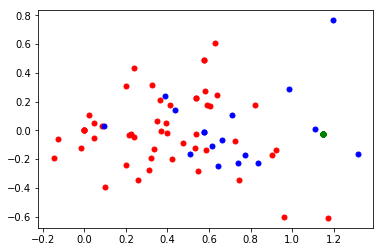

0
日签 早安语录 我开了定位为啥签不了? 每日一语 说得好,早安 鉴到 早语 早安心语 每日一图 今天签不了到 签利 心灵鸡汤 心语 每日一图在哪 标语签 心语宣 没收到签收图/::< 心话签 心语鉴 心语牵 心语欠 心签语 新语签 星语签 早安文字 心宇签 取消心情心语 必语签 怎样可以获得日签 心语篮 我需要一句经典的早安语录。 新语 签 到 又签不了到 牵到 心语筌 心语录 幸运签 心语图 心语答 心语圈 每日一语到哪去了? 【早安馨语 每日一语呢 鉴签到 丨 签到 怎么发早安心语 心语鉴图片 簽到 心语贴 我他妈又签不了到了
1
签到, 怎么签到 签到失败 起早签到? 如何能收到每天签到的图片加文字? 请来帮我签到 l签到 签到早安 怎样累积签到 签到获取不出来呢 心签到 早餐签到 每日签到语 ''签到''完成 自助签到 在哪签到 I签到
2
签到。 签到. 签到! 签到 签到～ 签到^_^ ↙签到 签到- 签到… 签到签到 签到哦 /签到
31.288340977839987


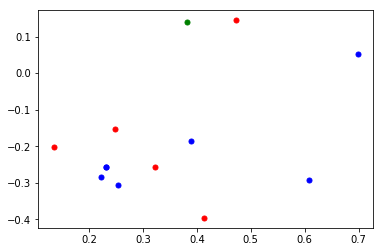

0
点击详情签到推红包 推广了签到没有红包 签到成功没有给红包 为什么我签到了没红包 签到没有红包给吗?
1
签到红包 签到领取红包 签到后红包呢 没签到红包 签到领红包 签到的红包呢? 签到红包有吗?
2
打卡后抢红包
3.149225210983377


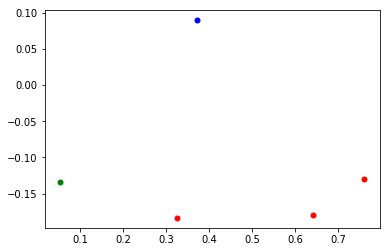

0
为什么又没有显示自动签到二维码了 没有自动签到二维码 自动签到了没有显示
1
自动签到
2
不能自动签到
0.0


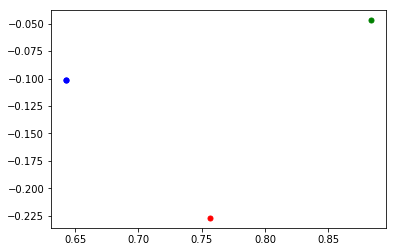

0
干嘛非签到?不签到不代表用不用吧。
1
签到有什么用 签到这个有什么用
2
签到有啥用啊？
76.5710611128558


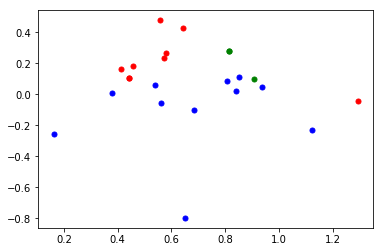

0
签到打卡区别 打卡和签到的区别 签到和打卡什么区别 签到与打卡有什么区别 签到和打卡的区别是 签到和打卡有什么区别呢 打卡和签到有什么区别 签到介绍 没明白签到与打卡的区别?
1
为什么我周五有打卡,但是没显示签到呢? 打卡和签到不是一样的吗？ 我签到了为什么打卡记录没有 打卡和签到是一样的吗 为什么我每天早上只能收到一张图呢,以前是两张,除了打卡的,另外还有一张呀 打卡完了 还得签到啊 不是有两个图片的吗 为什么打卡签到没心语和图片了 为什么我才签到2天 打卡了之后就不用签到了 为什么没有签到卡
2
签到不是打卡吗？ 打卡签到 签到打卡
5.28474763808717


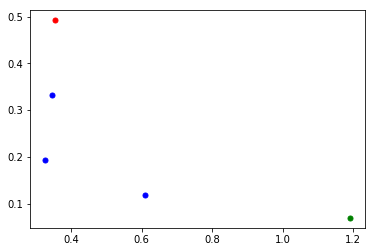

0
怎么取消打卡
1
取消自动签到 自动取消 取消自动打卡
2
取消签到
101.62923361101404


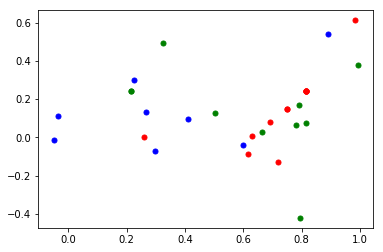

0
投诉司机 帮我投诉司机 投诉这个司机 帮我投诉这个司机 投诉刚才的司机 投诉司机绕路 投诉司机! 投诉司机接 投诉这司机 投诉那个司机 投诉之前那个司机 当时是投诉司机绕路 是司机的问题
1
一定要投诉，我赶火车啊啊啊啊啊 态度恶劣 司机态度那么恶虐 都跑到公交车站了 傻逼司机 投诉 路不认识 乱开 我是来反映问题的 不是来要赔偿的 司机绕路了 麻烦查一下 刚才的师傅态度实在太恶劣了
2
投诉他 投诉上一个司机 请投诉time司机 我要投诉这个司机 投诉上一位司机 我要投诉司机 投诉第一个司机 我要投诉 帮我投诉一下就好 投诉刚才的车
259.3896483589706


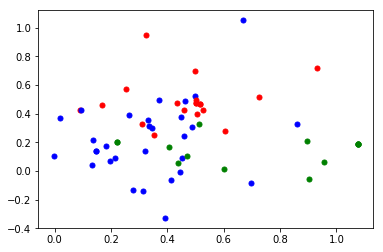

0
那我就取消关注了 不再关注了 可以不要关注吗? 取消关注 我需要取消关注 怎么取消关注 不关注你们了 不再关注 我要取消关注 我不关注你了 我就想知道怎么取消关注 明天再这样我就取消关注 取消让他关注 如何取消关注 反正我要取消关注 看来要取消关注你们了 小心我取消关注了你们这个公众平台了 可以不关注了吧 再见。取消关注。我已经决定了/::)
1
我要取关你 我要准备取关了 我要取关你了 你太烦了,发的东西太多了。再发没用的我就取消关注 这个微信号注销 助力来也 再取消就要卸载你了 那我不关注你了!叫你帮我一个忙都帮不上 再也不会关注你们了 拉黑你 我可不可以把你删了 取消助理来也 不然不再关注你 注销 我现在去取消关注拜!!! 我要把你删掉 你机器人啊!怎么你不关注了 我把你删掉 我想注销了 我说我想注销了 算了不再关注你了 小心我取消关注助理来摇 算了取消關注 没有必要 ,何必这么客气。再见。 你太烦人了,我还是不关注你了 不然我会取关你的 我要卸载 留着你,干啥 你不用再做我的助理了 拜拜,我们再也不做朋友了 你再怎么劝我都没有用,我就是要取消关注
2
我要取关 取关 取关了 取关取关 取关! 果断取关 怎么取关 逼我取关么 要取关了 我要取关了 不玩了。 那我取关了 卸载 是时候取关了/::)
119.03243434351369


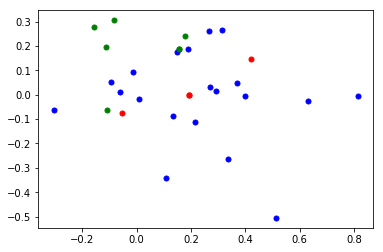

0
什么破软件！ 软件不好用我老公投诉你们了 什么破软件 什么烂软件
1
你们这玩意真的卡,有点难用 太烂了做的 你可真没用啊 什么乱七八糟的软件,,做不好就别拿出来让客户使用 你们这个软件设计得不好 别扯这些没用的 软件实在不给力 这个软件好难用 也会和朋友说不要用 一点都不准 你们这个真是坑爹 V个屁!我要号召大家删除你们软件 坑爹 妳真是牛頭不對馬嘴 你们要是老没人接单那这做什么呢?干脆别弄这业务好不好 你真是无用 你们真没信誉 交互体验有点差 赛程咋不准 狗P,不准/:dig
2
不好用 不好使 做得不好 一点不好用 打卡怎么不好使了 你们系统太不好用了 怎么不好用了
11.857264241219124


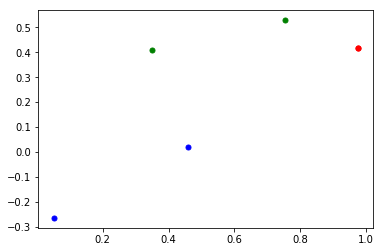

0
太差了 太差了!!!
1
太笨了 什么破玩意
2
体验太差 太影响用户体验了
45.28372723018645


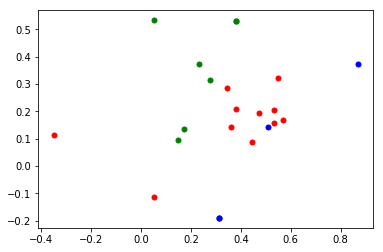

0
要举报 信不信我举报你 举报你 我举报你 那我就举报你 我现在就去举报你 我举报你工作不认真. 太过分了 小来太过分了 我要冒火啦 你特么没玩了是吧
1
过分了 过分了吧？ 生气 我生气你了
2
你这助理平时都是跟客人这个服务态度说话的？ 你这助理平时都是跟客人这个服务态度说话的? 你怎么不说话了,助理 大姐你说话 你别跟我聊了,换会说话的助理 你说话好诡异 和你说话费劲
0.0


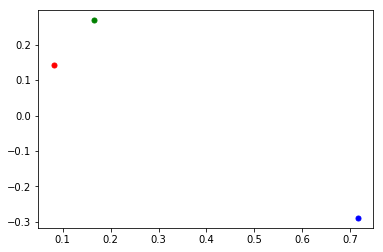

0
系统不稳定
1
页面打不开
2
你们系统有问题
23.740056112832825


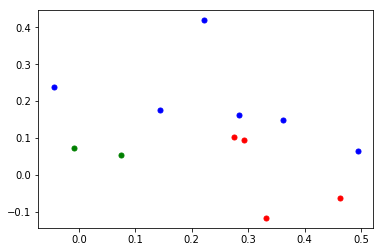

0
打开位置服务有什么用？ 打卡需要开启位置,怎么开启呀 那GPS定位打开有什么作用 位置服务怎么打开
1
什么事打开位置？ 为什么要打开位置？ 如何打开位置？ 怎么打开位置？ 开启什么位置 在哪打开位置
2
位置服务在哪里 位置服务
167.46435861486307


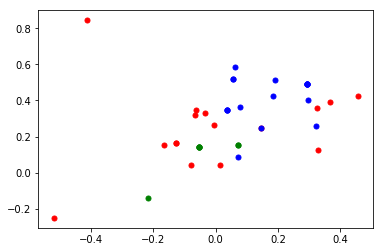

0
唱个歌呗？ 唱个歌 音乐 歌曲 我想听歌 我要听歌 来首歌  再回首 你唱不唱 来一首歌吧 能唱一段英文歌吗 需要手机自动定时播放歌曲 给我唱个歌 我想听刘德华的歌 我唱个歌吧唱歌 那你就唱啊 唱一个
1
能唱歌吗？ 会唱歌么 能唱歌吗 唱歌 你会唱歌吗 小来会唱歌么 唱歌唱歌 给我唱歌 会唱歌吗 来也,唱歌 我想听你唱歌 唱歌给我听 我就问你唱不唱歌 你会唱歌吗? 你唱歌嘛 他们说你会唱歌 唱歌吧 你会唱歌么
2
唱首歌吧给我？ 能不能唱首歌？ 给我唱首歌？ 唱首歌 给我唱首歌 唱首歌吧 能给我唱首歌吗?
2.095491577389616


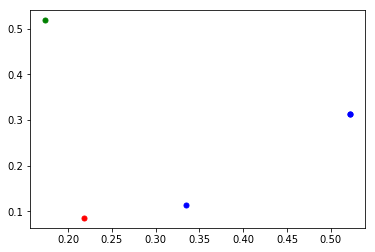

0
你唱一个吧
1
我唱的好不好听啊? 那就听我唱唱好不好 我唱的好不好听?
2
我唱的好听嘛?
9.511339464908977


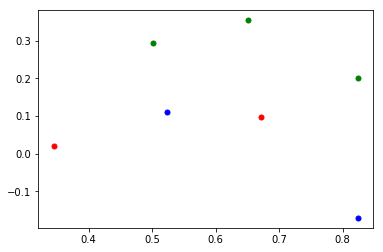

0
脱身是什么 现在要脱身是什么意思?
1
可以打我手机帮我脱身 打电话救我
2
帮我脱身怎么设置 怎么帮我脱身 脱身怎么用
4.990926722055379


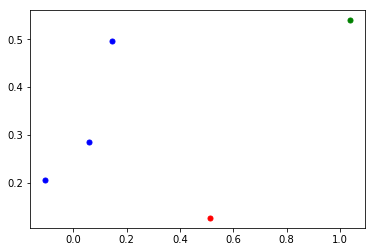

0
有推迟功能吗
1
小来，请问日程有无再次提醒功能丫 提醒可以再次推出吗 日程有没有再次提醒的功能
2
日程提醒可以推迟吗
66.55890023854553


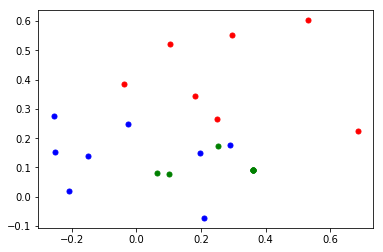

0
可以倒计时每天提醒吗 给我倒计时 倒计时？ 高考倒计时 日历倒计时 考研倒计时 可以设倒计时吗
1
小来可不可以帮我每日倒计时天数提醒功能？ 你们有没有倒计时的功能 倒计时功能 有倒计时功能吗 有没有倒计时 推荐来也增加一个倒计时治拖延症功能 怎么样可以倒计时天数 天数倒计时
2
打个比方，我6.17考六级，如果你们每天帮我倒计时还有多少天，我就会更有动力 32天倒计时 倒计时58天 倒计时27天 倒计时30天 倒计时60天 给我倒计时十天 你能帮计时间吗
3.5995224610033514


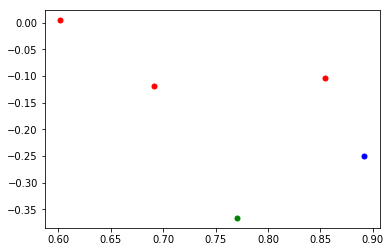

0
日程最多能邀请多少人 日程最多可以邀请多少人 最多允许多少人参与一个日程
1
每个日程可以邀请几个人
2
最多可以邀请几个人
60.98050456540042


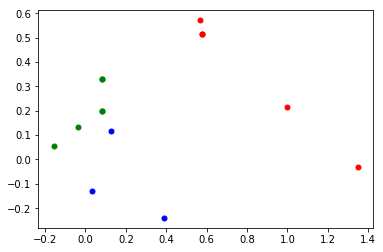

0
小来可以记备忘吗 备忘 打个备忘 备忘一下 备忘要开会
1
帮我记录一些东西不需要提醒 不吃辣的笑第二天 5元地铁费
2
我当一下备忘录。 备忘录 备忘录。 我当一下备忘录. 有备忘录功能吗 有没有备忘录嘛
1.6363461700434845


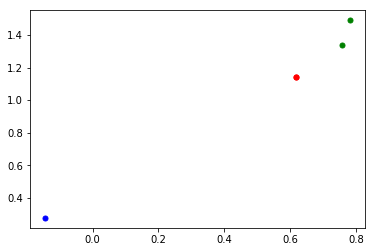

0
学习打卡 打卡学习
1
我要好好学习呢
2
提醒学习 学习
58.759526137082915


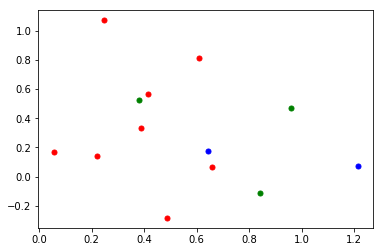

0
有没有那种可以每天提醒的功能 可以督促我早睡吗 可以督促我早起吗 每天监督我哦,小助理 助理请监督我 督促我学习 我怎样才能更早的睡觉 这些天提醒三次吃素
1
可以设置重复提醒吗 我不会设置重复提醒
2
怎么可以每天提醒我 可以每天提醒我吗？ 明天早起哦!
143.94024320393498


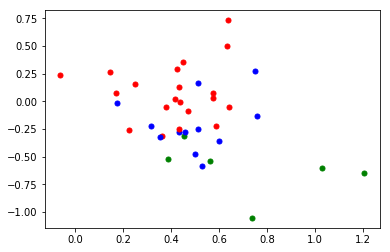

0
今天忘了现在才打卡 今天怎么没叫我打卡 早起床了,但忘记打卡了 今天忘记打卡了,对不起。 早忘了 打卡了 我没有起晚 我是忘了 早起来了,只是忘了打卡! 隔一天忘记打卡,记录就又从第一天开始,有一种想删除来也得感觉 可不可以有打卡提醒 我忘掉打卡了 忘啦打卡 每天记得打卡 睡得太好,都起晚了 搞忘打卡了/::D 我会记得打卡的 昨天早上记得打卡了呢……/::~/::~ 每次都忘了打卡 忘记了[Facepalm][Facepalm] 今天有事。打卡迟了 今天起晚了 忘记咯
1
忘记打卡签到 我又忘记打卡了 最近总忘记打卡 老是忘了打卡 每天都会忘记打卡 忘打卡了 我昨天晚上忘了打卡 昨天忘打卡 我没忘记打卡 明早不要忘记打卡 昨天忘记打卡 我很早就起来了忘记打卡了
2
我今天给忘了 忘了 哪天忘记打 我竟然忘记了[Facepalm] 其实我早起了忘打了 忘打了
79.12619998614667


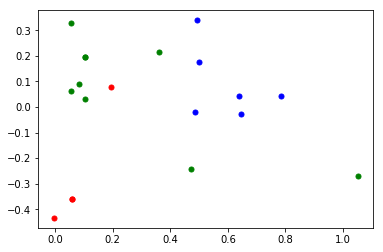

0
能叫别人起床吗 可以叫别人起床吗 可以打电话给其他人叫起床吗 打电话给别人
1
可以给好友设提醒吗？ 我可以提醒微信好友吗？ 电话提醒能设置其他人的手机号吗 可以电话叫好友起床吗 可以帮朋友调闹钟？ 什么是给朋友设置一个电话提醒？
2
那你要打电话叫小草起床。 明天打13880920540这个号码行吗 帮我提醒一下,18817688655,晚上喝酒不能开车 打电话给15025958203 打电话给盆友 你帮我打电话给希希 给鬼鬼打电话 帮我打张蔚电话 每十分钟打一次 如何确定入睡时间
111.01403045274279


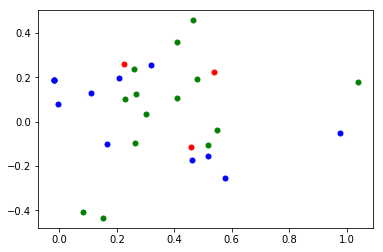

0
今天咋没提醒 到点没提醒吗？ 没有提醒
1
怎么没有按时提醒我？ 为什么没有提醒我 今天怎么没有提醒我？ 为什么不提醒我 怎么没有收到提醒 怎么没有提醒 怎么没有提醒 怎么没有提醒啊 怎么没有提醒我 昨天没有收到提醒 你怎么已经好几天都没有给我打电话了? 为什么收不到手机提醒
2
我的日程你没有提醒我 烧水没提醒啊 下来你今天一件事也没提醒我。 昨天早上没有提醒我打卡 [语音识别]昨天晚上你没有提醒我出车。 没有提醒我7点打卡喔 为什么没有提醒我洗澡， 买书的计划你忘记提醒我了，本来预计昨天完成的 嗯小燕你昨天忘记帮我提醒那个一定要把书省下来购买。 啥玩意?点这么半天醒不过盹来?整整七分钟过去啦 11点怎么没有接到你的电话 下次早点发信息让我打卡 今天怎么没有提示打起床卡 昨天没提示我补打卡啊
115.26892961110809


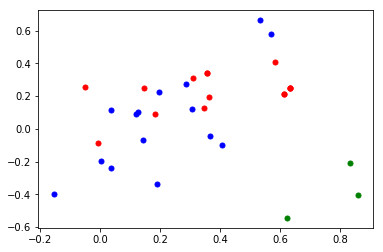

0
电话提醒是收费的吗？ 电话提醒是收费的吗 电话提醒需要收费吗 电话提醒收费吗 小来电话提醒需要收费吗？ 电话提醒收费吗？ 电话提醒会收费嘛 电话提醒收费吗? 电话提醒会收费吗 我问电话提醒需要收费吗? 你给我打电话提醒收费吗 打电话要收费吗 接电话收费吗? 这个软件打电话提醒我要收费吗 小来给打电话收费吗
1
来电提醒需不需要收费？ 电话提醒是否要缴费？免费提醒？ 电话提醒需要vip吗 你用电话提醒我，会扣费吗 电话提醒要钱的吗 我想问一下你给我打电话要还我话费吗？ 想问一下，提醒电话，费用是个扣我本机的话费吗？ 叫我起床需要VIP吗 你们服务费怎么收 接电话要钱么？ 小来给我打电话接听是免费的吗? 打电话给我需要收费的吗?我接听 你们打电话过来 会扣我的话费嘛/::P 助理来也我让你给我打电话是免费的还是要钱的 小来电话提醒是否需要收取电话费
2
打电话是不是免费的 免费电话吗 可以免费电话提醒
18.07148386851051


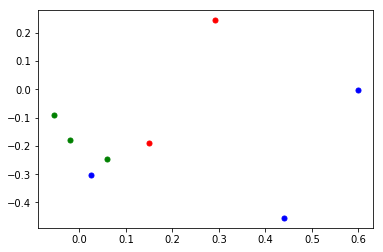

0
一年中所有的节日帮我总结一份 怎么制定特殊日子
1
可以创建节日提醒吗？ 每一个大小节日的当天早晨6点提醒我 节日日历
2
所有的节日都提醒我 能不能在所有的节日都提醒我 10月里有些什么节日
0.6761094100742843


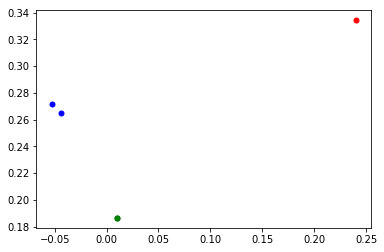

0
怎么退出日历？
1
怎么样退出日历？ 请问怎样退出日历？
2
如何退出日历？ 请问如何退出日历？
0.13722352318693484


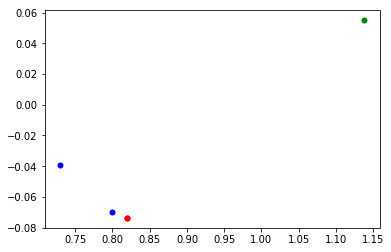

0
不能创建当前时间的提醒？ 能不能创建当前时间的提醒
1
为什么不能创建当前时间的提醒？ 为啥不能创建当前时间的提醒？
2
创建当前时间的提醒可以吗？
23.686281310368884


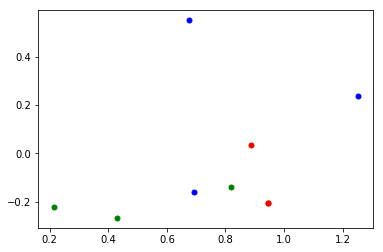

0
农历可以提醒吗? 农历 按农历
1
可以创建农历提醒吗？ 能不能设置农历提醒 农历能处理吗
2
要农历 是农历 农历初七姥姥生日
165.74482473481572


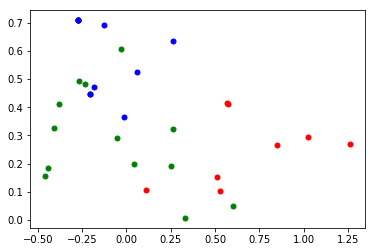

0
有电话提醒吗 可以提醒到手机上吗 可以都微信提醒吗 电话提醒是什么意思？ 你给我打电话吗 可以发短信给我提醒吗 提醒支持短信吗 电话通知是什么意思
1
怎么提醒我 你是怎么提醒的？ 怎么提醒呢 怎么提醒 提醒是怎么提醒的 怎么提醒我? 怎么提醒了 怎么提醒啊? 你怎么提醒? 怎么提醒我起床了？ 想问下小来怎么提醒
2
没有声音提醒吗？ 你会怎么提醒 有哪些提醒方式 能不能搞个电话提醒啊？[捂脸] 对的对的接口儿可以电话提醒是吧！ 提醒了以后你会用什么方式提醒我。 用怎样的方式叫起床呢？ 会怎么提醒我呢？ 你们会如何提醒我?采用什么方式? 你提示我的方式是什么 我要是睡过了你会叫醒我吧。 如何提醒问候我 都有什么提醒方式？
1025.2132447150725


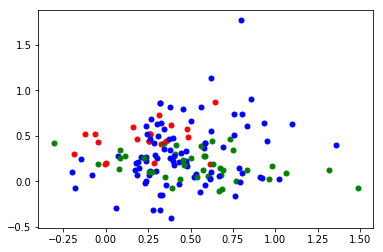

0
取消的行程就不用提醒了 取消所有行程 把我所有行程取消 取消所有的行程 取消所有行程. 帮我取消所有的行程 帮我把所有的行程都取消. 所有的行程全部取消 所有行程取消,除了打卡 我的所有行程 取消掉我的所有行程。 取消所有行程规划, 我想取消所有行程 取消行程 取消所有 麻烦全部取消 今天的行程全取消 全部取消行程 取消今日行程 取消周末行程 怎么取消全部 所有的事件全部取消可以么 取消天气提醒
1
怎么取消提醒 你好，怎么取消小来的叫醒业务？ 怎么每天还在叫醒 怎么取消给我打电话 取消叫早服务 叫早取消 取消我的叫早 ,不用电话叫早. 以后都不会叫早了吧 如何取消电话叫早啊 能不能除了叫早剩下的都取消 提醒太多啦！ 取消今天的闹钟。 张丽已经还款了，提醒我不用再通知她还款 今天的步行任务已完成，不用再提醒我了 明天不用提醒我推拿了 今天的喝水次数已经够了，不用再提醒我 如何撤销提醒呢？ 怎样取消提醒。。取消提醒 取消王者荣耀 我不要电话提醒啊 体校以后所有行程, 不用提醒了 不用提醒我了 不提醒 不要给我打电话 我想取消减肥卡该怎么取消 取消记账 cancel每天记账 不再记帐 今天不去脱毛了 把选修课取消了 取消提醒七点,每天是群里早晚分享加图片取销 不读书不记账 取消每天的锻炼 怎么撤销读书打卡就是问一下 取消所有的7:00吃药 取消闹钟 周二练字行程取消 怎么记帐 怎样取消电话通知 下午会议取消 取消今晚8点打王者 取消叫醒服务 取消起床闹钟 明天早上7点不用给我打电话 给花换水打卡去掉 周一至周五所有的提醒都取消 取消吧[Facepalm] 就是那个打卡不取消其余的提醒都取消周一至周五 以后每天都不要给我打电话 我才120斤还减肥，取消减肥计划 如何取消电话提醒呢 代办事项单里面去掉帮疾驰找工作 可以取消记账吗 我不再运动了。小来 提醒你5点30分提醒起床。取消 一个谢谢你我不用提醒了 小来不要在打电话 请帮我把读书删了。 把明天提醒我早起的关了 我想取消锻炼打卡 你可不可以不要每天那么早叫我 去掉以前定的时间 清空所有安排表 怎么取消每日电话 取消吃避孕药 不要打电话早起 是把所有的闹钟提醒都关掉 把所有的闹钟提醒都关掉 取消喝热水 取消以后的启程 取消舞蹈课 怎么取消电话叫醒 取消6点50的打卡 请帮忙取消闹钟订阅功能?或者告诉我怎么取消 明天不用

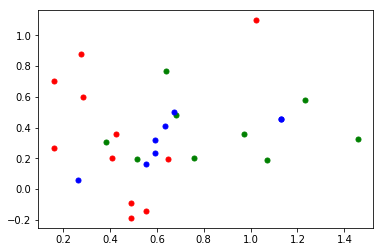

0
日程安排有误 用闹钟提醒 为什么不会打电话提醒我呢 日程安排 用电话提醒好的好的 我最近看我的日程内容不太对 电话通知 修改行程表怎做操作 我的邀请卡微信名请改一下 改掉吃药时间 关掉七点起床
1
如何改日程 怎么修改日程 日程怎么改 怎么改我的日程 这么修改日程 我能修改日程吗？ 修改日程 怎么修改我的日程
2
如何修改提醒？ 怎么修改一下提醒时间 无法在线修改 日程修改以后为什么不能保存 嗯，修改后无法保存修改 修改日程，保存不了 我要修改日程，在哪里改 如果以后早起时间需要修改的话可以修改吗 怎么改地点
105.37657989680672


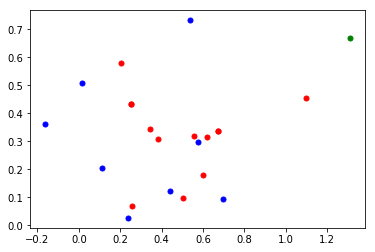

0
如何创建日程？ 提醒怎么设置 怎么设置提醒 日程怎么用 如何添加生日提醒 日程怎么用？ 创建日程在哪里 怎么设置日程 工作时间能否帮忙安排 如何设置让日程不提醒 如何设置日常工作提醒 时间设置在哪里 可以多创建日程吗
1
刚才我想新建一个每日的提醒，为什么无法新建呢？ 那种每周提醒去上吉他课的服务有么 我想减肥能有提示嘛？ 我想要个每天早上6:30的提醒  需要每天设置吗  还是你们可以直接设置的 你好，想问下有每天都提醒的功能吗 我想问一下有没有闹铃提醒了? 江苏卫视跨年演唱会门票开卖提醒我 您是不是可以提醒我某些事情呢
2
等一下提醒我开会
34.913974543273596


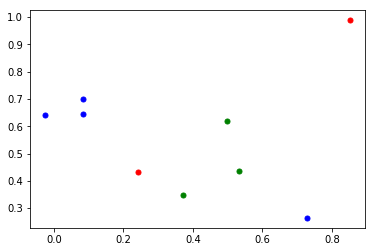

0
电话叫醒能聊天吗？ 叫醒的时候多说点
1
怎么选择叫我起床的声音 电话闹钟声音太不好听了 你打的提醒电话我必须接吗 打电话的声音不好听
2
这个日程发语音的是机器人吧？ 电话提醒，是人工打电话还是软件 给我发条语音提醒!
52.42264517340415


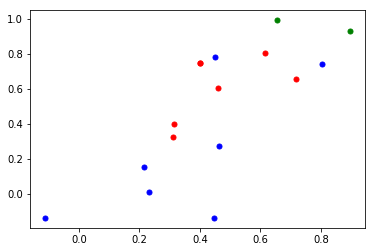

0
有没有叫醒服务 有没有叫醒服务 有叫我起床的服务吗 有叫起床的服务吗 有叫醒服务吗？ 你有叫醒服务吗 能提供叫醒服务吗
1
你可以叫我起床？ 没人叫我起床 怎么每天还在叫醒 能不能叫我起床 今天没提醒我打卡？ 唱歌提醒还是人工提醒 可以叫起床不
2
是人工叫醒吗 是真人叫醒吗
110.03518123389367


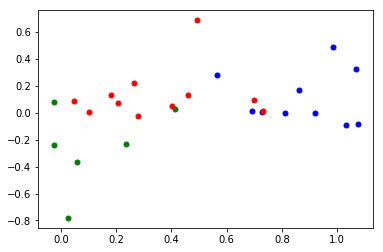

0
刚才我想新建一个每日的提醒，为什么无法新建呢？ 日程怎么建啊 怎么生成邀请卡 邀请卡在哪里啊 怎么共享日程 日程邀请卡 星座可以生成邀请卡吗 邀请卡 在哪里点击邀请卡 怎样才能生成邀请卡 生成邀请卡
1
怎么邀请好友参与日程 邀请别人加入怎么邀请 怎么加入日程邀请？ 邀请了别人加入日程，我删掉日程的话，对方也会被删除吗 怎么日程加入？ 日程邀请 怎么邀请别人加入日程 可以邀请别人加入日程吗 我不会邀请别人加入日程 邀请朋友怎么邀请?
2
可以帮我提醒别人吗 如何把好友拉进日程提醒？ 能不能提醒我的好友什么时候回家 一天不能加入2个时间段的日程吗? 你能替我提醒我的好友吗? 能不能给别人发微信提醒
0.0


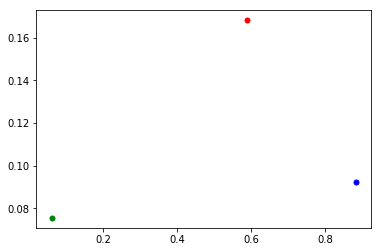

0
怎么给日程添加红宝
1
日程添加红包
2
怎么给日程加上红包让大家抢
0.0


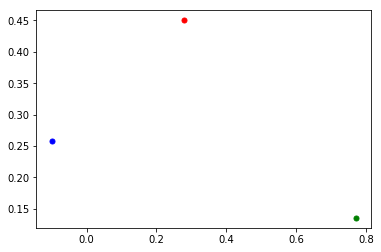

0
如何安排重复日程
1
有哪些循环提醒的方式
2
除了每天，还有什么循环提醒的设置
0.0


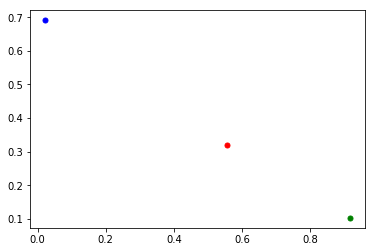

0
日程怎么设置
1
打卡怎么提醒
2
小来可以帮我记日程么
115.50004881969272


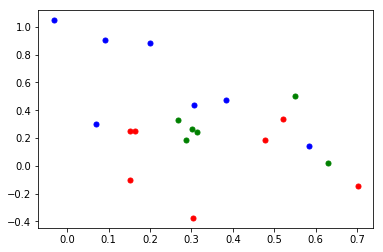

0
我最近有什么事 我最近有哪些日程安排 我近一周日程有什么? 我的日程有哪些 近一周日程有什么? 有一周都这样了 我有哪些提醒
1
明天几点钟我起床啊 今天行程 明天我有什么安排 帮我看一下明天的行程安排 明天行程 我今天有什么行程 我刚才订了闹钟。是几点呀
2
我的日程 日程安排变成图片 看下我今天的日程 今天日程 我明天的日程都是什么 明天的日程是什么
3.5369374145965975


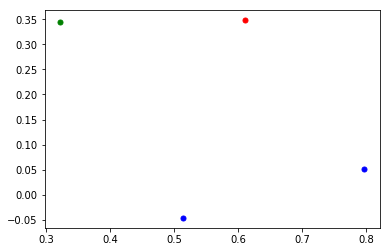

0
我想建立日程表
1
再次生成一次一天的日程表 生成日程表
2
听我做个日程表
6.297082058734578


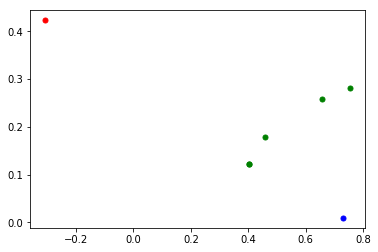

0
怎样退出
1
邀请了别人加入日程，我删掉日程的话，对方也会被删除吗
2
怎么取消启日程邀请 日程邀请如何取消 怎么取消日程邀请 被邀请的日程如何取消 被邀请加入的日程如何退出
30.190372013634114


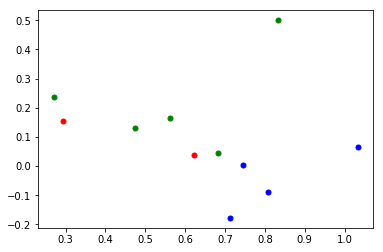

0
为什么没有发送邀请卡 怎么能每次都自动发送邀请卡
1
以后提前半个小时提醒我上课 以后提前半个小时提醒我开会 提前一天并提前一小时告知我 提前五分钟钟提醒
2
每天给我日程的时间能否提前到7点？ 怎么默认电话提醒 能不能每次默认是电话提醒 怎么默认日程都是提前1个小时提醒 为什么智能提前51530分钟，不可以自己选择时间的吗
123.70214440720453


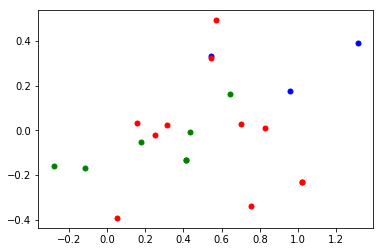

0
不用打了 以后不用叫我起床了 起床时间改为七点 去掉提醒 我说的是不用打 不用叫我起床啦 不用喊起床了 别打给我 别叫我了 都不用打 能不能不要在给我打电话了
1
取消打电话 取消电话 取消来电
2
不用打电话了 不要打电话 不用打电话 明天早上不打电话 不用打电话给我了 别打电话了 不要再打电话了
3.761862540817039


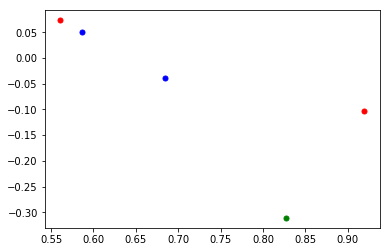

0
提前一天 提前一天的7点
1
推迟2小时 推迟20分钟
2
推迟半小时
0.695953261978745


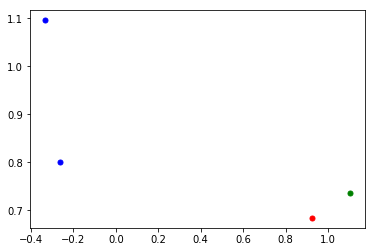

0
跑步行程可以添加吗
1
行程 我的行程
2
加入行程
46.25654284120417


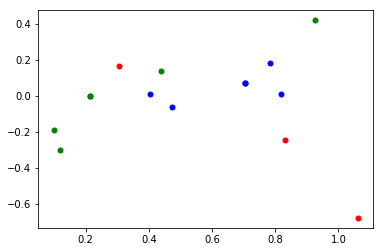

0
每个小时提醒我喝水 每半小时提醒我喝水 每隔一小时提醒我做讲课大赛PPT
1
多叫几次 多打几次给我 多提醒几次 多提醒我几次 多叫我几次 多提醒我几次。
2
再叫一次 叫到起床为止 几点也行,多提醒几次 几点也行,多提醒几次. time再叫一次 没接就多次拨打
11.8769619993048


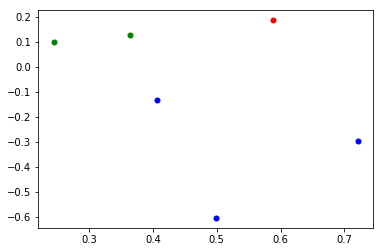

0
为什么会重复提醒
1
这个事情已经提醒过我了 刚刚已经提醒过一次了，为什么又来？ 已经提醒过啦，搞毛又发一条？
2
为什么我会同时收到多个提醒 为什么你会提醒我么次？
51.47820512530875


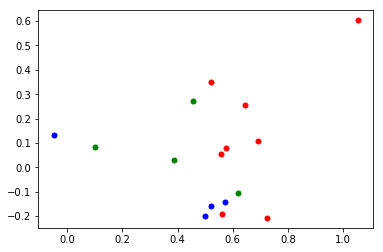

0
今天没有电话提醒撒 我选择了电话提醒，可是你并没有，然后我错过了 每天都没有接到起床电话 怎么没打我电话 好几次都没有打电话 没打通接着打啊 时间都到了为什么没有电话提醒我呀 抱歉未能接到你的电话
1
怎么没给我打电话 为什么没有打电话 为什么不打电话 没什么没有打电话
2
为什么没有准时打电话给我 为什么没有给好友发晚安啊 今天早上为什么没给我打电话 早上七点为什么没有给我打电话
10.23415490095162


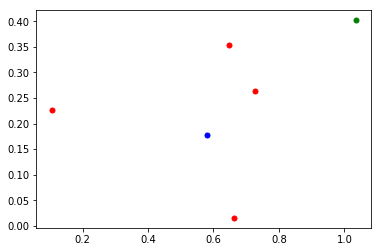

0
你怎么给我建日程了 没让你创建提醒 没有让你建提醒啊 不是让你提醒
1
提醒疯了么?
2
怎么添加了日程
9.968724046819911


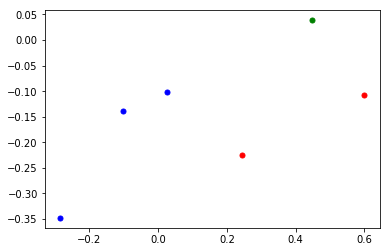

0
1分钟后提醒不支持吗？ 为什么我说两分钟后提醒我不好使
1
不能马上提醒我吗 不能现在就提醒我吗 不能打电话提醒了?
2
现在提醒我为什么不行
5.188456861908075


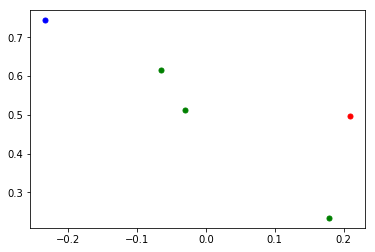

0
来也可以开发大姨妈计算提醒功能吗？/D
1
能提醒大姨妈来了么?
2
我对日程有建议 我想给日程提个建议 能提个建议吗？
97.22882310721262


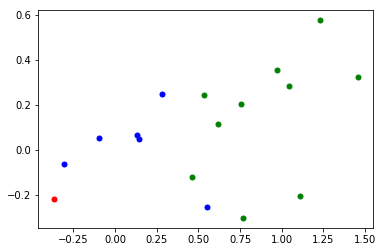

0
儿子生日
1
你的那个日程上红包是有bug了？ 小来，帮我看看是什么原因选不了19日 天气提醒出bug了  给我连发了10几条提醒  还在发 怎么提醒上面的时间不准 我儿子生日还没到的是是旧历的不是阳历的 不准的
2
电话提醒打不开 我没有绑定，但是我点电话提醒也没有提醒我，和引导我绑定 修改日程，保存不了 无法在线修改 日程修改以后为什么不能保存 嗯，修改后无法保存修改 怎么修改日程后无法保持修改？ 不能记录日历 日程打不开 日程不能建立
4.464396135425847


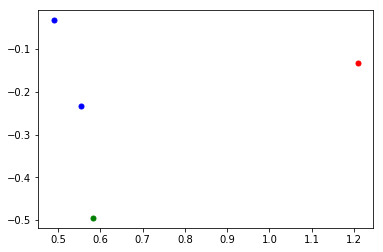

0
二分钟喝水
1
提醒我6分钟后喝水 我一个小时后休息
2
我五分钟喝水
0.9960704963637972


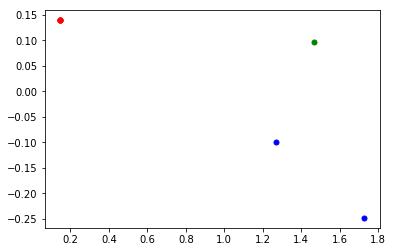

0
现在打电话给我 打电话给我 现在给我打电话 马上打电话给我
1
给我打个电话 打个电话我
2
打我电话
115.15130848158407


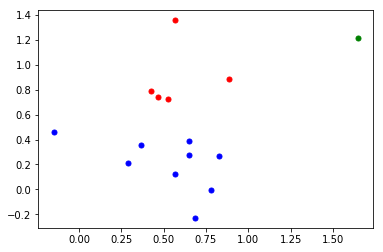

0
跑步 运动 健身 起床跑步 锻炼
1
晨跑 坚持快走6公里以上 站桩 晨读 叫我起床 叫早 电话叫早吧 怎么能设置喊我起床 喊我早起
2
开会
30.485923783429413


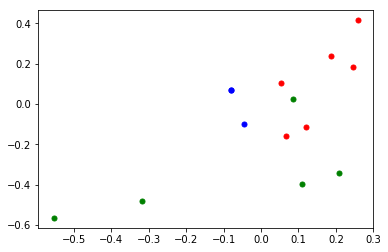

0
老公生日是5月8号 老爸生日是7月1号 我的生日是4月8号 主人生日是4月8号 查询老爸生日 请问我闺女的生日是那天
1
生日 老婆生日 我的生日呢
2
爸爸生日 我老公生日 老爸生日 母亲生日 明天闺蜜生日
17.705115314110845


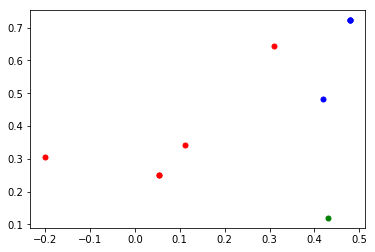

0
提醒睡眠打卡 早点提醒我打卡 怎么不提醒我打卡 怎么不提醒我打卡了 怎么现在没有提醒打卡了?
1
提醒打卡 打卡提醒 打卡提醒吗? 提醒我打卡。
2
明天下午给高工发信息
0.0


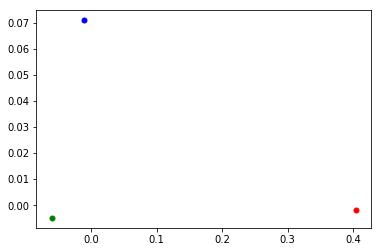

0
日历
1
立秋
2
白露
15.494175937752068


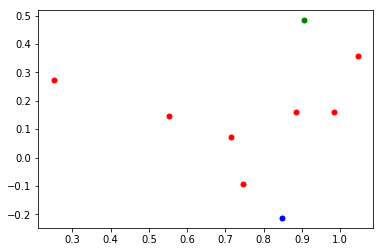

0
帮我脱身 我要脱身 脱身,现在 我帮我脱身 电话提醒我脱身 来个电话帮我脱身 打电话帮我脱身
1
十分钟脱身
2
一键帮我脱身
32.194702392319584


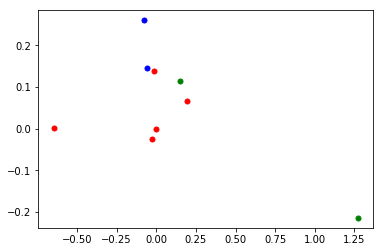

0
这样提醒没作用 還沒到點! 幸运饼干怎么没呢 你没按时叫我起床啊 小来并不准时
1
怎么没提醒我 怎么没提醒啊
2
还没到时间就提醒 时间不对
69.96373632335181


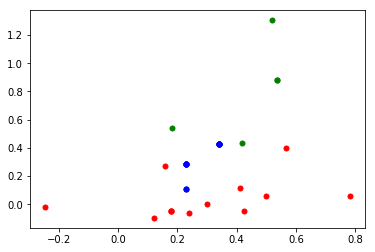

0
已经锻炼了感谢您的提醒 好的,谢谢提醒 好,谢谢提醒 好谢谢提醒. 谢谢提醒呦 好的,谢谢提醒。 小来谢谢你的按时提醒 谢谢已经在做了 设提醒你 好的你已经完成任务谢谢 看到了,今天就买。谢谢! 谢谢宝贝 謝謝你們的支持，讓我現在每天早睡早起
1
谢谢提醒 谢谢你的提醒. 谢谢提醒! 谢谢,提醒我 谢谢你的提醒 谢谢提醒, 谢谢你提醒我 谢谢提醒. 谢谢你提醒 谢谢提醒～ 谢谢亲提醒 谢谢你的提醒哦 谢谢提醒。
2
感谢小来提醒 感谢助理的提醒 感谢小来的提醒 谢谢小来提醒 2017最感谢亲爱的小来
59.50197809631382


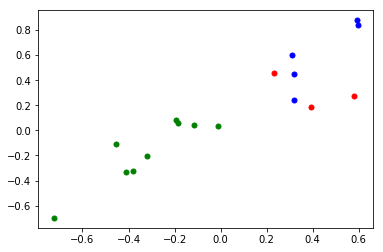

0
非VIP用户,输入订阅会有机器回复吗? 您能否介绍下关于订阅的 想看一下今天订阅的文章
1
订阅 有什么订阅 去订阅 我还想订阅 可以订阅什么
2
外婆的灶台 外婆的私房菜 什么外婆的灶台 红烧肉怎么做 私房菜 来也 有菜谱吗 外婆的 鸡爪怎么做 菜谱
36.37086876898313


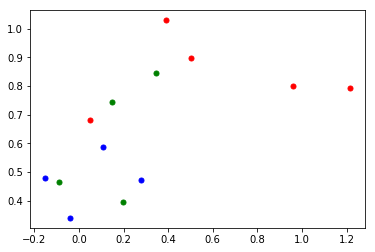

0
教英语 英语不会读怎么办? 学英语的怎么订 每天坚持学英语 轻松学英语
1
汪老师教英语在哪里订购. 怎么样可以学好英语 汪老师教英语在哪里?我想听 小来有没有英语教程
2
汪老师教英语 汪老师学英语呢? 汪老师英文 汪老师您好
590.1876722116131


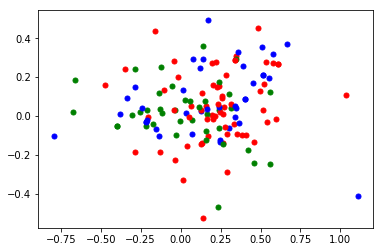

0
运程 双鱼座 处女座 巨蟹座 白羊座 天蝎座 射手座 水瓶座 双子座 金牛座 狮子座 摩羯座 天秤座 双鱼 巨蟹 白羊 摩羯 水瓶 金牛 双子 处女 天蝎 我是天蝎座 今天的运程 有近一月的双鱼座运程吗? 今天星运 今天天蝎运气 射手 巨蟹座的人有什么特点? 天蝎座男生性格 今天运程 我今天运气怎么样 我今天运气好吗? 我的财运怎么样 爱情 今天的处女座笨不笨? 你帮我看一下今天天蝎座的运程 你帮我看一下天蝎座的今天星座运程天蝎座的 狮子 二零一七十二月份的水瓶座运程 我是不知算天秤还是天蝎 财运 明天会有好运吗 魔蝎座 双子座和哪个星座最配 小来你说我今天运气怎么样 水瓶座的最佳契合星座 双子座的幸运怎么样 天秤 |双子座今天的运程 射手摩羯星座 天平座的幸运物品是什么 小主我是处女座 小助理 今天白羊的運程呢 天甁座 双鱼座和射手座 天平座 我今天运气好吗 怎么才能看到我天秤座呢 我是双子座的 天瓶座 能帮我发一点关于巨蟹座的东西吗
1
天蝎座今日运势 双子座运势 天蝎运势 双鱼座今日运势 星座运势 星座 运势 星座日程 金牛座的星座运势 运势生成图 小来,我今天星座运势 那么运势如何 处女座爱情运势 今日星座 和狮子座的今日运势 射手座的今日运势 天蝎座运势 明天还可以再查星座运势吗? 狮子座今天运势 今天运势 射手运势 金牛座今日运势 我今天星座运势怎么样 十二星座运势 处女座今天运势 今日我的爱情运势 今天射手星座运势 今天的运势 狮子座今天的运势 能不能每天给我发两个星座的星座运势 金牛座运势 双鱼座运势 一键一星座运势 射手座运势 怎么才能看我的星座运势 星座运势呢 有没有巨蟹座的星座运势 怎么查看星座运势 每天都有星座运势吗
2
订阅金牛座 星座每天运程 小来我今天的,嗯星座运势是什么? 不打卡,星座运势图就不发了对吗? 我今天的星座 今天的星座到底是什么呀? 巨蟹座和白羊座今天的运势 看一下星座 金牛座运势如何? 巨蟹星座 我要看星座 水瓶座运势如何 我想知道昨天的星座运势 亲我想问一下我的爱情和运势如何 将水瓶座的运势发给我 天蝎座什么运势 我订阅的星座今天没更新 星座今天怎样 今天摩羯座女生和处女座的星座运势 近日巨蟹座运势 什么星座运程好 什么让十二星座开心 换一个星座 天蝎座跟哪个星座最搭配 能不能给我每天发一个星座的今日运势 巨蟹座星

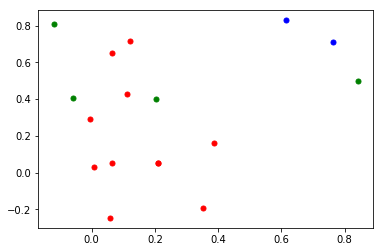

0
最近有什么好看的电影? 找个电影 近期电影 最新上映电影 最热电影 这个月的电影有哪些? 辛特勒的名单 最近有什么好看的电影 有什么好看电影推荐吗 有什么好电影 这两天放什么电影
1
新电影 电影上新
2
电影 看电影 最近最火的电影是什么电影 最近电影
98.42762076951571


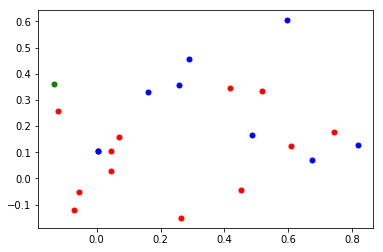

0
资讯 早日新闻 早间新闻 新闻资讯 新闻早班车 八卦 来点新资讯 24小时新闻 24小时简报 过去24小时新闻简报 最近有什么娱乐新闻 最近有什么新鲜事
1
新闻 来也新闻 新闻呢 订阅新闻 金融新闻 腾讯新闻 早新闻 最近的新闻 每天推送最新新闻
2
国际新闻
0.0


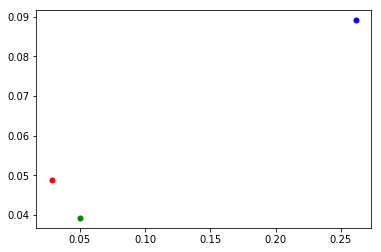

0
影讯
1
最新电影
2
战狼2
31.857460953553822


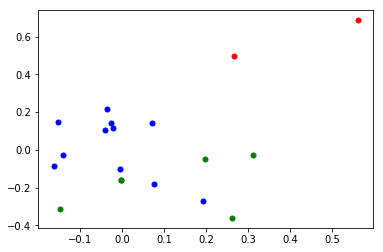

0
可以画画吗 给我画画
1
我特别喜欢手绘,不知道有没有手绘 生成一副手绘画 怎么买绘本 手绘画油画吗? 我的手绘呢 手绘 给我画个手绘 给我画幅手绘 给我花花 给我一幅手绘 来一副手绘
2
给我画一幅手绘 给我画一张铅笔画 你在画手绘吗 画手绘 给我画一幅画 给画我一幅手绘
142.51592593722808


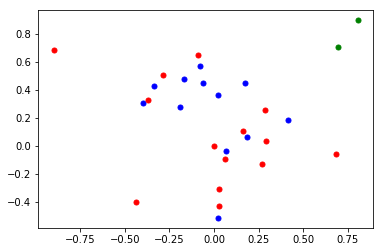

0
备忘50 你说的记账,在哪里记,我不太清楚,请指教 经期是今天开始 大姨妈 例假 体重126.4 两天20 我花了五十块 14号来大姨妈 每天记账 看看一个月钱用在什么地方 咋记呀 l记录专用 我什么时候来的大姨妈 身高一米七八体重一百八
1
如何记账 记账功能 可以记账在他那里吗 小来,你会记账吗? 最好还有记账功能就更好了 希望小来以后增加理财方面的功能 密码d1314001 怎么记账 那我该怎么记账呢? 我不会记账 我要记账 明天叮咚收款建行到账18600
2
一键备忘 一键
0.0


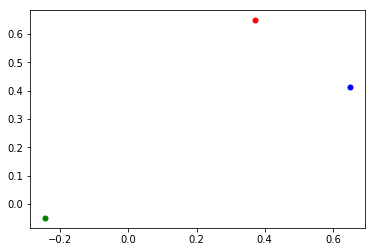

0
怎么查看记账
1
一键备完怎么查记录啊
2
我想记点事怎么没看见
0.0


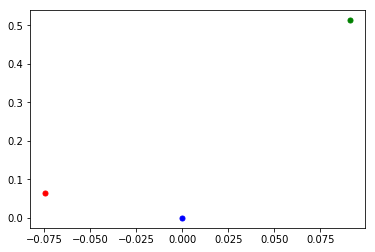

0
什么日子好
1
老黄历
2
怎么订阅老黄历
250.31580876735956


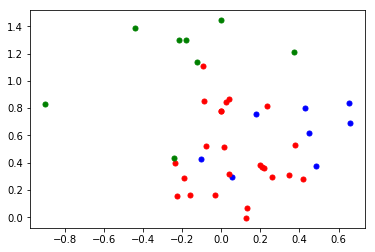

0
天气有明显变化之前请提醒我 提醒我安庆下不下雨就好了 取消马鞍山的天气提醒吧 天气提醒出bug了  给我连发了10几条提醒  还在发 提醒我每天早上9点钟当日天气预报 每天早上9点告诉我当日天气情况 电话提醒我每天7点10分点邯郸广平天气 明天冷吗 明天什么时候开始下雨 宿迁天气提醒 今天会冷吗? 北京那边现在冷不冷冷 10月28温州天气 10月29温州天气 10月30杭州天气 荆门天气 什么时候才有太阳 西安有没有雾霾 益阳天气温度多少 今天益阳天气怎么样 玉溪研和区天气 冷不冷 雾霾有吗 明天天晴吗 现在在下雨你报多云要你何用
1
以后每天早上提醒我天气情况。 以后每天提醒我空气质量、天气预报和星座运势。 可以每天提醒我天气跟星座运程吗？ 每天都要提醒我天气哦。 每天提醒我天气预报 以后每天提醒我天气预报 每天给我发天气预报 每日天气推送
2
上海后天天气 上海大后天天气 上海明天天气 天气 上海天气 天气预报 深圳今日天气 有天气提醒吗
355.7713651752965


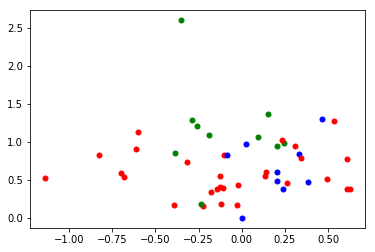

0
明天山西太原天气预报 今天温度 今日气温 天气，连云港市灌云 今天的天气怎么样？ 有雨吗 北京的温度 关于天气的来一段。 永济一周天气 玉溪研和区天气 周口天气小来 茌平天气预报 今天天气怎么样 北京一周内天气 明天南京天气怎么样 上海未来七天天气 顺德天气 帮我查询下明天五台山天气预报 今天北京天气如何 瑞金近十天的天气 查一下明天早上的天气 赤水的天气 天气怎么样 上海今天天气怎么样 明天的天气会怎么样 以后发西安的天气不要再发北京了,我在西安呢 三天天气怎么 今天空气质量好不好? 西宁一周天气
1
今天多少度 今天冷吗 小来，明天几度 沈阳今天冷还是昨天冷 今天冷不冷 今天外面冷不冷呢 天氣 蚌埠今天有风吗 上海今天下雨吗
2
明天的天气 空气质量 宁波天气 长沙天气预报 重庆天气 一周天气 今日天气 大连天气 今天北京天气 今天天气预报
88.91994273001899


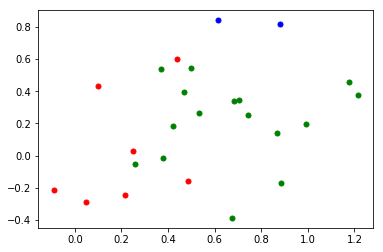

0
汪老师教你学英语今天没有推送 我就是看发了外婆的灶台,却什么内容也没有。不知道咋回事 富爸爸财富商学院用不了? 那个星座今儿的在哪能查到? 那你我的星座搞错啦!你能不能空调过来啊? 很长时间没有推送了,去干嘛了 你他妈  为什么早上不给我发
1
订阅提醒 查看订阅
2
订阅提醒今天怎么没给我发 订阅收不到推送 订阅类目里为什么没有内容 没有找到你们推送的内容 点击订阅汇总就收到一个网址 打不开 为什么订阅的没有准时发来???? 怎么我的订阅都没有看到发给我过嘞 为什么没有给我发订阅 我定的这个咋不给我推送了? 为什么很多订阅都没有推送呢? 怎么订阅了也不推送 今天没有推送啊 我收不到我的英语推送呢 订阅的几乎都没有发过来 我的订阅怎么收到 为什么收不到每日订阅
271.1876555961146


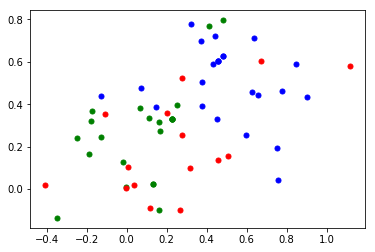

0
退订 订阅的,怎么退订? 订阅的内容,怎么退订? 取消星座,谢谢 取消星座定阅 取消新闻 不要每天早上给我发天气了 把这个刮风不刮风取消吧 怎么取消这些东西啊有些用不着 退订新闻简报 选错星座怎么艹 如何退订 怎么去除星座这一块 取消报天气预报 怎样把算命的那个塔罗 删掉
1
取消订阅 怎么取消订阅 如何取消订阅 订阅的东西,怎么取消订阅 怎么取消订阅? 怎么取消某些订阅 请问怎么取消订阅呢 订阅提醒怎么取消 怎么取消订阅提醒 怎么退订订阅啊 怎么退订已订阅的 怎么样取消订阅 怎么取消订阅的消息 怎么取消订阅信息? 订阅的服务怎么取消 我想问下订阅怎么取消 退订订阅 怎么删除订阅 不接受推荐订阅信息 我取消订阅 我的英语订阅怎么取消不了呢 不想订阅英语了 取消日历推送消息 取消的订阅为什么每天都收到呢
2
怎么取消星座订阅 还有怎么取消星座订阅 取消星座订阅 如何取消星座订阅 星座订阅取消 星座取消订阅 取消订阅星座 我想取消星座订阅 怎样取消星座订阅 怎么取消星座 怎么取消星座运势 取消星座 如何取消星座服务 取消星座服务 取消星座消息 取消星座关注 取消星座运势 星座运势取消 怎样取消星座关注 取消天气预报 取消天气预报订阅 星座运势不要
375.3460869510294


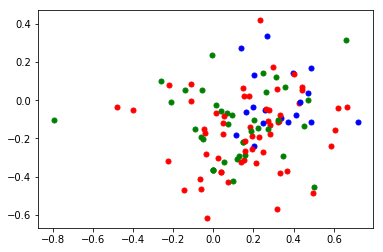

0
星座运势里面没有内容 date怎么没有星座运势啊 没有推送星座消息 为什么星座突然不推送了 为什么没给我星座运势的卡呀? 星座没来 为什么星座不出来? 您好!怎么没收到今天的运势 为什么星座的出不来 没报今天运势 星座远错了 运势没有文字 星座运势为啥会出现空白 星座运势一片空白怎么回事 星座怎么没有呢 星座为什么没有内容呢 星座为什么没有内容 你好!怎么今天的星座运势是空的 今天的运势怎么没有字 今天的运势怎么什么都没有 今天的星座运势怎么是空的 今天星座怎么没有 为什么星座运势上面没有字 为什么我的星座运势里什么都没有 为什么今天的星座运势没有内容 我的星座就这样空白吗 空白。今日无语吗运势 今日星座是空白 今日星座偷懒了 今天的星座运势怎么是空白 今天的星座没文字 今天星座推送是空的是什么意思 今天星座为什么是空白的 为什么有的时候星座运势是空的?/::)/::) 为什么今天的星座运势是空白的呢 运势内容空白 星座预测没有文字 星座运势空白没有显示 星座没有内容 星座没有信息 今日星座运势怎么是空的呢 今天运势为什么是空的没有字呢 为啥没星座内容 为什么今天没有双子座的运势 上面这个星座运势图没有显示内容 运势今天怎么什么都没写 星座图片上啥都没 为什么只有星座图片没有文字 运势是空的 我说的星座没有一个字 星座运势是空白的是什么意思 星座是空白的 星座怎么是空的 我怎么什么也看不到星座 为什么星座是空的 星座运势怎么是空白的呢?[Facepalm] 今天的星座没有推送
1
订阅类目里为什么没有内容 date没发订阅内容 经常不来订阅的内容 date订阅内容还没收到, 订阅菜单看不到内容? 今天没推星座给我为什么? 怎么还没发 为何订阅推送这么不及时 已经定阅为何没有发 今天星势是不是睡懒觉了 噗 你给我发个空白的星座运势 是让我自己填嘛/::- 今天打卡星座上没有字 看一下 我的星运怎么是空白的 今日运气怎么什么都没有你就怕没牌怎么是空的 为什么没有幸运色 为什么今天双子座什么都没有 运气今天为什么空白 今天的塔罗占卜怎么没有了呢
2
星座运势怎么没有了 怎么没有星座运势提醒了? 怎么不发星座运势了 今天星座运势没有发送 老子今天的星座运势呢! 为什么不给我发星座运势了 今天什么星座运势没发? 又不来了星座运势 星座运势速度 怎么没发星座运势 星座运势

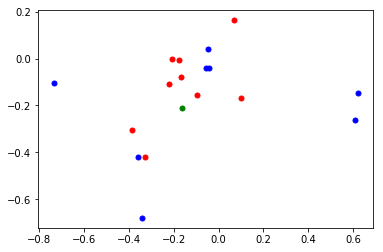

0
帮我买张电影票 帮我买张电影票, 定张电影票 给我找个电影票, 帮我买一本《力量》的书 我要买个榨汁机 能约华为mate10吗 瑞士1000左右的表什么表好 买电影票《至爱梵高》
1
买电影票 定电影票 帮我订电影票 订电影票 买两张电影票 可以帮订电影票吗? 我查查电影票 帮我订一张张学友演唱会门票
2
怎么买东西啊
160.4236701899306


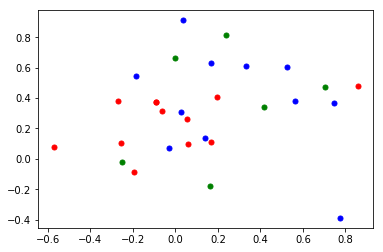

0
怎么订阅星座运势 订阅星座运势 订阅星座 星座订阅 我不会订阅星座 星座推送 星座运势速度 我要全部星座运势 每日运势 怎么设置星座 我的星座运势 订阅星座查询
1
怎么订阅天气预报 怎么找订阅 怎么看订阅了的内容 订阅在哪里找？ 可是找不到刚刚订阅的那个了 在哪里可以查询到订阅的项目 星座只能订阅一个吗 我的订阅 哪里订阅呀 定时接收订阅 取消之后如何重新订阅
2
发当日天气预报 西安有没有雾霾 预报天气 我好像是订阅两个 一个星座运势 还有一个是什么每天一句晨语  现在找不到在哪里了 星座定阅 每日訂閱
11.486260461273055


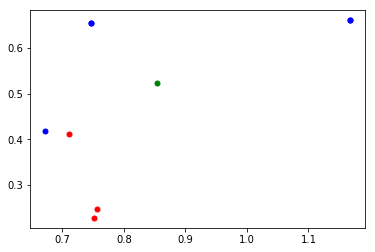

0
修改订阅时间无效 怎么设置订阅推送时间 订阅更新频率
1
怎么修改订阅 订阅怎么修改 修改订阅 订阅修改 怎么改订阅
2
怎么修改
16.417828547668044


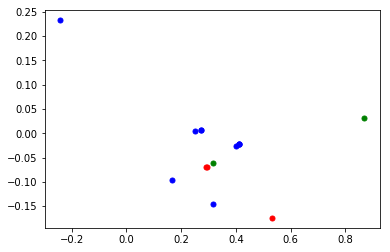

0
请问,星座安阴历阳历? 阴历  阳历 我分不清 公历是农历吗?
1
星座按阳历还是阴历 星座是按阴历还是阳历 星座是阴历还是阳历 星座是按阳历还是阴历? 星座按农历还是阳历 星座是按农历还是按阳历啊 这个星座按照农历还是阳历 星座是按阳历的还是按农历的? 星座怎么分?阳历? 星座看阳历农历
2
按阳历算还是农历算时间 星座是按阳历算吗
47.788323004441125


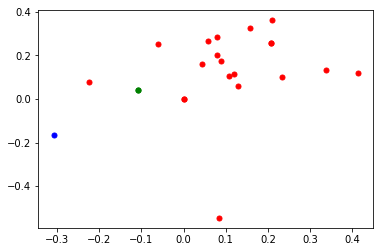

0
占卜 你会占卜吗 塔罗占卜 想占卜 塔罗牌没人理啊 占卜不要钱吗? 占仆 如何占卜 如何助事业 怎么占卜呢? 想占卜怎么弄? 怎么成为塔罗占卜师 看看我今年的婚姻 塔罗牌怎么玩 助理来也 射手座说 我的 句句真 我不知道怎么包装自己 请明师指点 塔罗占卜怎么聊天 怎样才能塔罗占卜 助理来也 怎么没有测运势和财运的呢 解签 我想问一下  @助理来也   你能帮我测一下
1
我啥时候可以结婚啊
2
占卜星座 星座占卜
143.82077985721463


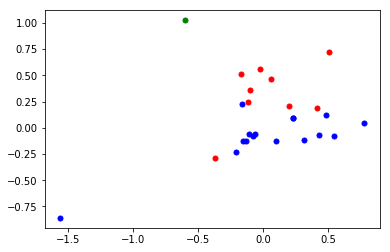

0
我不知道怎么穿衣服 怎么穿衣服 穿衣 出行会议应该穿什么?_? 穿衣服 黑色毛呢外套怎么搭配 你怎么知道我在孝感 今天天气怎么样  适合穿什么 穿衣服搭配
1
今天的天气适合穿大衣吗? 适合穿什么衣服 citydate适合穿什么 date适合穿什么衣服 date适合穿啥衣服 雨天适合穿什么鞋 datecity适合穿什么? 穿啥 穿什么 建议穿多少衣服 今天应该穿什么 穿什么衣服比较合适昵 白羊座今天适合穿什么颜色衣服 适合穿多少 衣服 明天穿什么
2
天气冷 怎么办
2.006421805412182


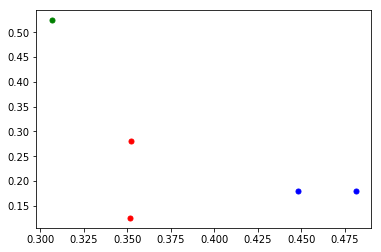

0
故宫日历没有了 故宫日历
1
故宫日历没有按时推送 之前的故宫日历订阅为什么没有了
2
故宫
106.2473000638135


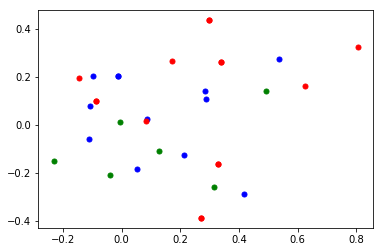

0
怎么修改星座？ 如何修改星座？ 怎么样修改星座？ 怎么修改星座订阅 怎么修改订阅的星座 更换星座 星座更换 怎么可以更改星座 星座怎么更改 更改星座 修改星座怎样修改 如何修改星座 星座能改吗 改星座 怎么改星座
1
可不可以切换星座? 星座不对哦，怎么更正 我想把星座打卡改成双鱼座 怎么选星座 我要改星座 星座怎么选啊 想改星座的发送时间 换星座 我想换做关系射手座 怎么办 |可以重新选星座吗 叫你发白羊座的 我选不了星座
2
星座运势中的星座我输入错了 星座错了怎么办 选错星座了/::- 更改星座运势时间 可以把星座取消吗 是我要换星座运势的星座
7.774034460886731


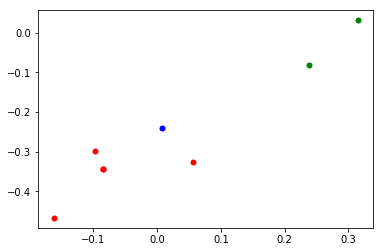

0
外婆的灶台咋没有内容呢 为啥外婆的灶台没有文字 外婆的灶台怎么打不开了 外婆的灶台怎么打不开? 好几天没有看到外婆的灶台了
1
外婆的灶台咋没推荐呢
2
外婆的灶台停止推送？ 怎么不发送婆婆家的灶台
0.8965767335313415


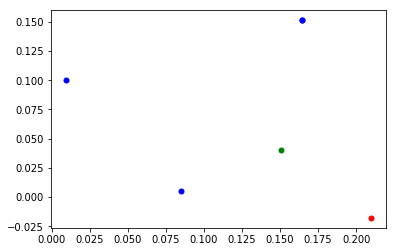

0
昨天世界杯谁赢了
1
世界杯买哪个队 世界杯该买哪个队 世界杯要买哪个队 世界杯应该买哪个队
2
世界杯买哪个队能赢
116.46657508076912


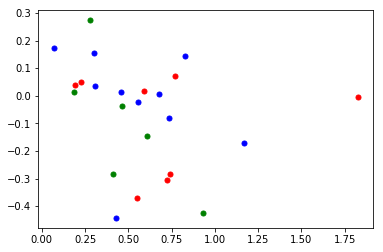

0
怎么收不到你消息呢？ 为什么有时消息不发了? 收不到 为何收不到打卡消息 什么消息都不发了 你怎么不回复我的消息啊? 呃怎么不回复我的消息? 为什么收不到别人早起打卡的消息
1
为什么不发消息给我 怎么不发消息了 为什么这几天你不出现 没有收到是否需要补签提示 小来你去哪了? 为什么经常会出现打不上卡的状态 你好为什么好几天都没有图片呀 为什么最近不发了呢 你好几天都没跟我说话了 为什么没有心语签
2
好久没收到你的消息啦？ 好像小来你已经发了19条消息了 啥啊 有延迟 今天早上打卡,很慢 那个是每天20条吗 我发信息你能收到嘛?
72.85100927252955


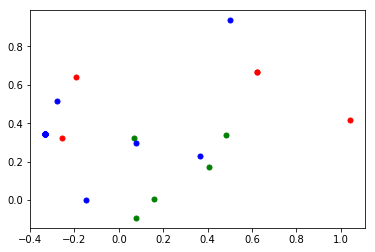

0
怎么这么慢 反应这么慢 这个效率有点慢啊 反应慢 最近你们反应好慢
1
速度速度速度 速度速度 速度 速度哇 速度. 速度啊 速度。 速度找 速度哦 速度哈 速度呀 速度回 速度出票 速度点 速度退款 速度...
2
你这回复速度 为什么回复会慢? 你反应好慢 反应迟钝 这破玩意反应迟钝
12.261670031933319


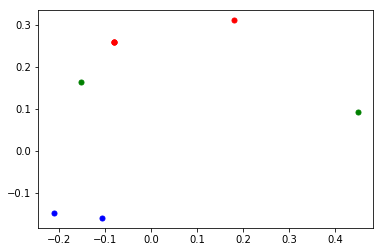

0
红包怎么玩 请问红包怎么玩 想知道红包怎么玩 问一下红包怎么玩
1
请问怎么发红包 问下怎样发红包呢？
2
和朋友一起抢红包 怎么抢红包
25.88350873239127


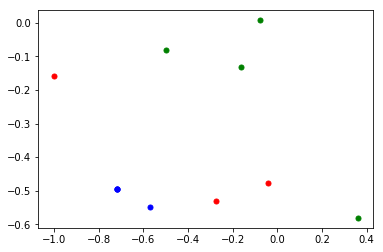

0
我要红包 没有红包 有没没有红包
1
红包呢 红包呢? 我的红包呢 红包了
2
我的红包有进展吗 为毛红包打不开的 我要红包/::Q/::Q 红包那去了
0.9854852213563985


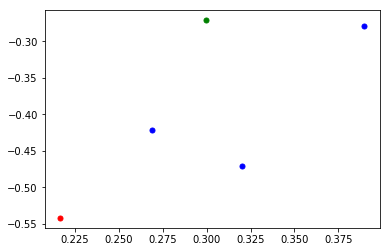

0
抢答红包一分钟只能领一个
1
答对了为什么不给发我红包？ 答对了为啥不给发我红包？ 想知道答对了为什么不给发我红包？
2
为什么红包一分钟只能领取一个
48.543670978351685


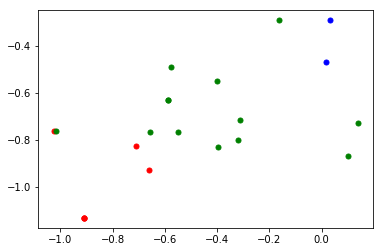

0
现金红包 我需要现金红包 我要现金红包 现金红包? 现金红包呢? 那个现金红包是?
1
怎么收获红包 不是有3元红包给我嘛
2
现金红包在哪里 现金红包哪里拿 现金红包在哪? 给的现金红包在哪里 现金红包在哪里啊 3元现金红包在哪儿呢 哪有现金红包 如何兑换现金红包 现金红包在哪里查看 可是没有给我现金红包 我没收到现金红包 3元现金红包又是啥啊 不是有三元现金吗?
155.35607602208472


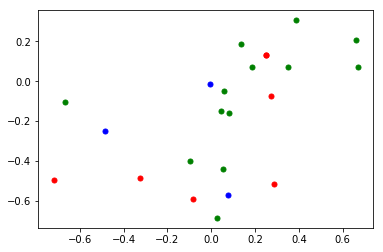

0
给我发个红包 抢答红包 有红包吗 红包 给我发红包 猜问题拿红包 发抢答红包
1
我要发红包 怎么提问发红包 发红包
2
我要你的红包 我还是想再抢一个红包，能吗？ 可以发给我红包点好吗? 红包怎么抢?在哪里? 爱我就给我发个红包 来也答题红包 怎么抢 你发一个红包呗。 答题 那你给我发个红包我就不生气了 红包在那。快出来 发个钱包吧 你微信有没有红包啊
47.20282436836831


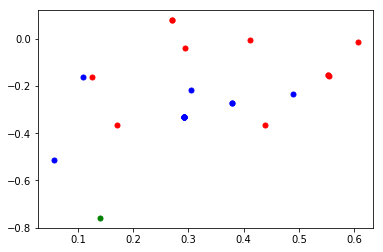

0
红包总是请求不成功啊 答对题目提示红包无法领取 为什么我答对题目提示红包无法领取 想知道答对题目提示红包却无法领取是什么原因 答对题目提示红包无法领取怎么办 为什么红包无法领取 红包无法领取是什么原因 请问红包无法领取，是什么原因 为什么别人不能领取红包 为什么不能领布丁 公主 的红包 为什么苹果手机不能领取
1
为什么红包领不了? 红包领不了 怎么领不了红包 可是红包领不了 微信红包领不了 红包领不了啊 我红包不能领 红包领不了呢 领不了红包 红包又领不了 为啥又领不了红包 为什么红包领不了 这个红包领不了啊
2
答对了没有红包
148.23782173012177


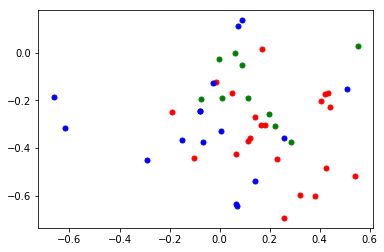

0
我的红包什么时候退回来 我发的红包什么时候能退回来 红包没有领取完怎么办 未领取的红包多久退款 我的红包没有领取完怎么办 没有领取的红包要多久退款 之前的红包会退回来吗？ 之前发的红包多的钱你们没有退回来 如果红包没领完会退还吗 没领完的红包怎么不退款？ 红包为什么十天还没有退回来 为什么我的红包还没有退回来 我想问一下。这里的红包。为什么不退还 红包钱怎么还不给退回来 我的红包没被领取的为什么不退 红包余额为何不退 红包金额发错没抢完退回吗 红包没领完的什么时候退还 我发的红包别人没抢会退回吗 没领的红包退不退 红包里面没领完的钱怎么办
1
红包退款 退还我的红包钱 退还红包钱 我的红包还没退回来 快点退红包 红包如何退款 红包怎样退款 红包退款什么时候退 红包怎么退 怎么退红包 红包未退回 退红包 红包退还 返回我的红包 剩余的红包怎么退回 那红包什么时候退回账户
2
可是说明上说6～10个工作日可以啊 答题没答完的红包去哪了 红包领不完 能退回来不能 红包为什么十天还没有退回来 你好 我的没有领完的抢到红包里并没有退给我哟 我的没有领完的 抢到红包里 并没有退给我哟 红包答题  没人答题红包什么时候能退 没答完的红包退不退 抢答红包   没人抢  红包能不能退回来 24小时没领的红包怎么处理
20.147223086659004


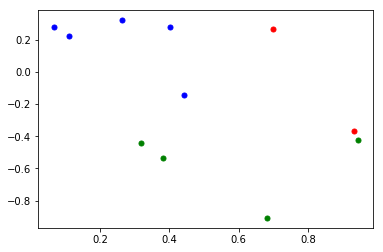

0
查看我的红包被谁领取 我发的红包被都谁领取了
1
如何查看我发出的红包记录 怎样查看我发出的红包记录 怎么查看我发出的红包记录 查看我发出的红包记录 红包记录
2
我发了多少红包 我发的红包被多少人领取 怎样知道我发了多少红包 如何才能知道我发了多少红包
15.984239295664167


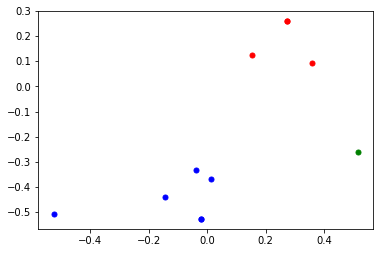

0
红包发出可以修改么 红包发出可不可以修改？ 红包发出是不是可以修改？ 红包发出还能修改吗？
1
红包答案是否可以修改 红包答案能修改吗 请问红包答案是否可以修改 红包答案可不可以修改 红包答案能不能修改 紅包答案
2
可以把红包删除嘛
28.31712888246735


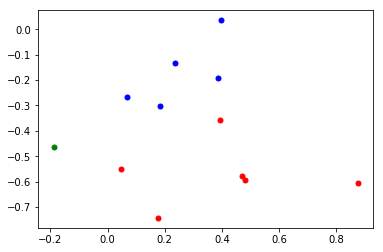

0
抢答红包图片怎么没有了 抢答红包没有图片 抢答红包没有生成图片 我的红包问题图呢 红包二维码没有生成 生成红包图
1
刚弄了一个红包，抢答 还没有发过来二维码 答题红包已扣款但是二维码没发出来 春节红包已经付款了，怎么没有生成图片 抢红包的二维码没给我发出来 我刚才第二个红包二维码没发出来
2
红包二维码
18.52274376840716


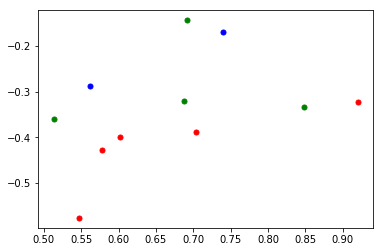

0
发红包到朋友圈，但是别人朋友圈显示不了 为什么我的红包二维码发朋友圈，别人看不到 红包二维码在朋友圈不显示 红包在朋友圈不显示 发微信朋友圈不显示
1
二维码无法发送朋友圈 朋友圈好友无法看到二维码
2
红包无法在朋友圈发送 朋友圈看不到发送的红包 发不了朋友圈 红包无法发朋友圈
5.297963574767243


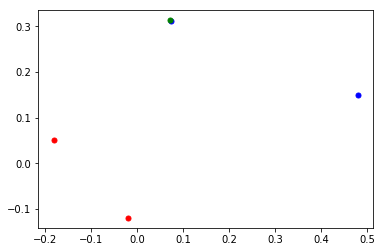

0
红包怎么提现 红包提现
1
提现 怎么提现
2
怎么查看红包
2.6312061898391272


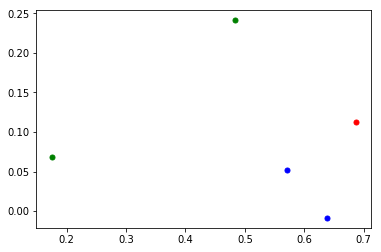

0
为啥验证手机？
1
为什么要验证手机才能用？ 验证手机有什么用？
2
如何验证手机？ 怎么验证手机？
5.298000286639445


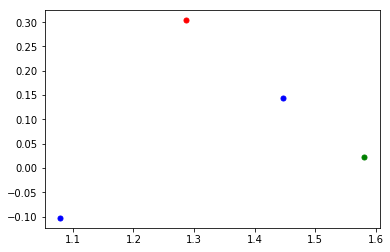

0
完成验证
1
已验证 已经验证过啦。
2
我已更改
67.54315484353714


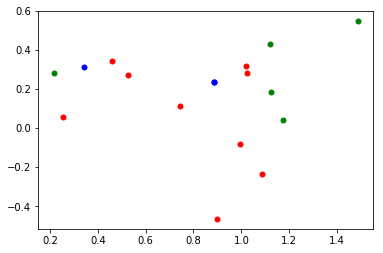

0
验证手机收不到验证码 为什么我验证不到号码 验证手机号 收不到验证码 还是要验证手机号。 为什么手机号验证不了 手机号为何不能绑定 验证手机号码 重新验证手机号
1
验证不了 重新验证不了 验证不了呀
2
如何验证 验证错误 助理来也老是要验证验证还是验证验证完了还不行 无法验证 验证
51.98807050356944


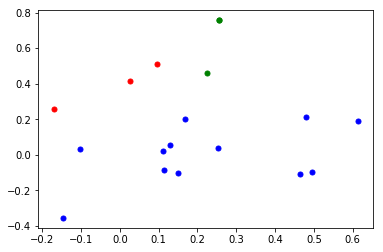

0
翻译 求翻译 我想翻译
1
这个签语饼下面带中文翻译就好了,方便学习 一个幸运签语饼怎么没中文 能翻译成中文不 每天推送的那句英文可以带上翻译吗 这英文是啥意思呀 亲,上面那个英语有翻译吗 我想知道一句英文 求译文 我的订阅英文字母看不懂啊 英文看不懂 可以翻译成中文吗? 蝴蝶用英文怎么说
2
英语能翻译一下么 翻译英语 可以翻译英语句子吗
266.23406132093385


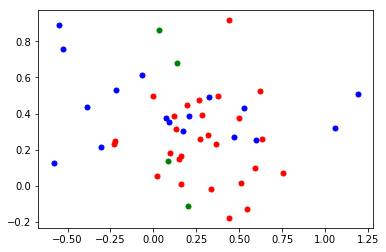

0
意见反馈 想夸夸你 谢谢,未支付的订单是不是也可以有自己修改或者删除的功能呢 我能不能给你的公众号提点意见。 如何向小来提建议？ 测试了一下性能,感觉不过关。怎么办? 太复杂了 可以自己制作吗 给你们一些意见ha 你变了 这个APP还得改进 最近邀请卡很不顺畅 我反馈了 你们加强管理吧 语录太少 词汇可以换换个吗?反复的 还是喜欢最初的打卡签到图 有老外读的音频吗 汪老师教英语如果带上语音就更完美了 汪老师教英语有语音就更完美了 如果汪老师教英语,可以语音就好了。我们可以学到发音 建议汪老师教英语如果带上语音就更完美了 小建议,那个汪老师教英语如果配上语音读出来的我觉得更棒哦! 能语音教英语吗? 如果英语可以发音就更好了 英语有语音就更好了。 汪老师的英语要是有语音就好了!可以跟着学 汪老师语音不是很清 有外音
1
我有建议在哪里反馈 有建议要反馈 你可以反馈一下 建议 反馈 我也给你反馈一下 给个建议 提个建议 发建议 我想反馈情况 我要提建议 我要投诉 怎么提建议 有意见 没事就反馈下 我需要年青人的一些建议 我想给你一个建议
2
提个订阅建议 怎么把星座运势变成图片 订阅建议 星座运势订阅能多选就好了
27.898418301051485


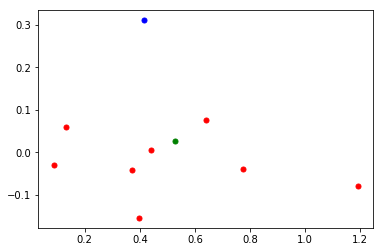

0
每个月的这个鸡汤能不能不要重复 搞笑点的,尽量不要重复。 你给发过了,请不要重复发 图片排重复了 这个心语能不要经常重复吗 这句已经重复很多遍了 早安寄语很多重复的 打卡上面的话开开回回就那么几句,能换换吗
1
话都重复了
2
新闻重复了
37.78095439961872


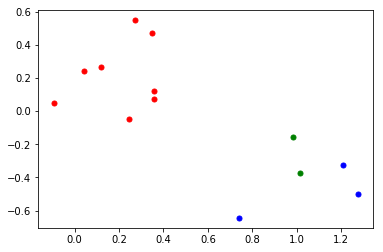

0
什么时间关注的 我关注你多久了 我什么时候关注你的 我是什么时候关注的 我是哪天关注助理来也的 我是哪一天关注你的? 我第一次用来也是什么时候 我是想问咱俩什么时候认识的
1
我们认识有多少天了 请帮我找一下我一共签到了多少天了 打了多少天
2
我们认识多久了 我们认识多长时间了
7.944456312900589


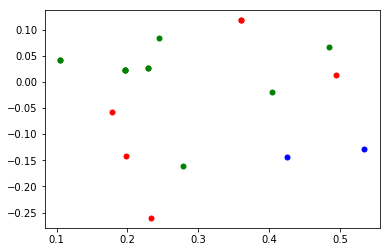

0
来两种富含维b,维c的水果 两种富含维c的水果 两种富含维b的水果 买两种富含维b的水果 富含维b水果 富含维b的水果
1
维c的水果 富含维c的水果
2
来两种富含维b的水果 来两种富含维c的水果 来两种富含维b,c的水果 来两种维b的水果 来两种富含维b水果 来两种富含维b 来两种富含维b的水果, 来两种富含维b的水果,。 来两种富含维b的水果,. 来两种含维b水果 来两种含维b的水果
8.267825779712318


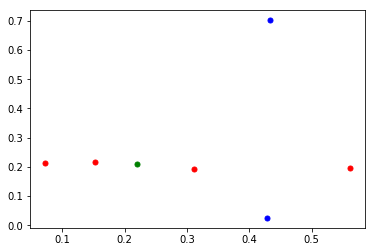

0
你会王者荣耀吗 最近沉迷王者荣耀 你有玩王者荣耀吗? 你有玩王者哦
1
有打王者吗 打王者吗助理来也
2
王者荣耀
56.19569113724245


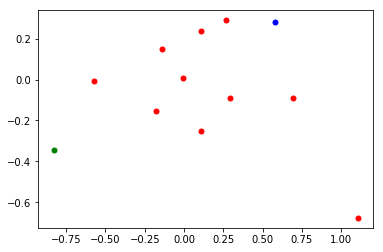

0
怎样生成一张个人名片 名片如何定制 怎么制作名片 名片如何了 名片图看不到啊 咋不有名片出现 名片不行呀 帮我创建一张名片 名片发给我 我的二维码名片
1
我的新名片呢
2
明信片
6.053630274209192


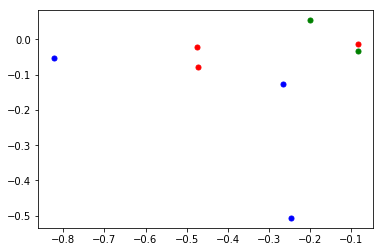

0
幸运饼干什么意思 小来,幸运签语什么意思啊 给的幸运饼干什么意思啊
1
幸运饼干 幸运饼 幸运签语
2
幸运语签 幸运签饼也没有了/::(
992.9352594250352


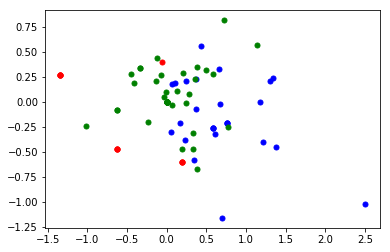

0
怎么样了？ 好了嘛 定好了吗 好了吗 怎么样了 好了吗? 好了么 好了? 怎么样啦 怎么样? 安排好了吗
1
还没查到？ 下单了吗 到底有没有人接单啊 怎么回事 查到了吗? 查到了吗 还没查到? 还没到 没有收到 还没有吗 怎么还没到 还没来 这么久 还没有小哥接单吗 查到没？ 能不能查到 啊？在查吗？ 能查到吗 还没送到啊 知道了吗 什么时候送过来呀这么久了 不是接单了嘛 超时很久了 还没送到?已经一个小时了 怎么回事8点下的单还没送来 说要送到了 到现在都没送到
2
麻烦快点 还没好？ 怎么办 快点 快 有吗 速度 尽快 越快越好 麻烦尽快 赶紧 可以了吗 叫了吗 尽快吧 来了吗 有没有 快一点 快快快 要快 请你快一点 ok了吗 催一下 这么慢,什么时候送到 可以再早点吗 已经很久了 怎么办啊 快一点哈 太晚了 迟了 你怎么不早说 太迟了 快些 我的外买怎么还沒到 请问什么时候到?三点前要到 催单 滚  没有来 这速度 越快越好奥 有点赶时间 破系统快点 尽快 急
38.17242055032024


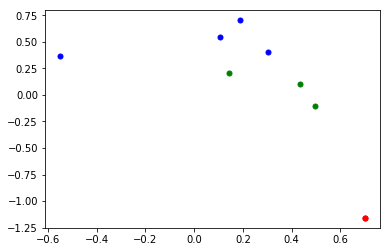

0
怎么回事啊 你们怎么回事啊
1
我需要帮助 我需要客服 我需要个人工 我需要人工服务
2
怎么搞得 我需要解释 可以靠谱点吗？
1154.8014423234176


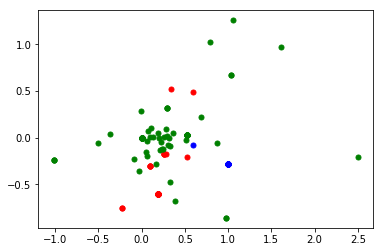

0
行 好的 行吧 好的，多谢！ 好吧！ 好的, 好哒 好滴 好的! 好的。 好的好的 好的呢 好啊 好呢 好。 好的. 嗯好 哦好的 好的哦 好! 嗯,好的 嗯嗯好的 好的～ 好的,定吧 好哒! 好的哟 好～ 好好好 好咧 好的呀 好的没问题 哈哈好的 好哒好哒 好哒～ 恩,好 哦哦好 哈哈 好呐
1
对的呢 对啊 对呀 对哒 对的. 对对 对对对 对. 对的。 对。 对的对的 对! 对的 对 马上
2
是的 谢谢 好的 谢谢 可以 是的 我看行 好的谢谢你 OK谢谢 嗯谢谢 没错。 确定 可以的 是啊 没问题 是的。 都可以 好呀 随便 可以啊 都行 嗯呐 是哒 是的是的 要的 是的, 对的,谢谢 嗯嗯嗯 没错 是的呢 是的是的. 嗯。 是呀 嗯, 是这个 约 嗯啊 有的 就这个 需要的 是滴 可以呀 订吧 可以可以 对滴 是的呀 也可以 好的,没问题 哦了 差不多 确定。 那就这个吧 就这个吧 嗯那 ok的 嗯啦 好勒 对头 嗯是 都要 那就行 对小哥没有影响就行 好的,我确认好了给你 那对了 yes 确认 好好 接单了就行 嗯 你做我的时候要好好 行吧 这个倒可以理解 嗯 乖儿子 恩。恩好的 谢谢你的理解 是的你没有听错 那就发吧 今天中午不用订餐了 要得
884.9471757951684


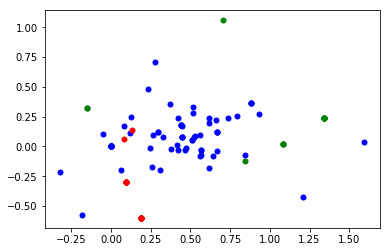

0
好嘞 好, 嗯好的 好的哈 嗯嗯,好的 好哦 哦哦好的 哦,好的 嗯,好 哦,好吧 哦好 好嘞! 哦哦,好 好 好的小来 好的再来
1
知道了谢谢 恩 谢谢 嗯嗯～ 嗯嗯 嗯 哦哦 恩 嗯呢 收到了 恩恩 好,谢谢 哦哦哦 嗯哪 收到,谢谢 知道了,谢谢 收到了,谢谢 明白了,谢谢 看到了 收到, 那就好 噢噢 嗯嗯, 嗯嗯。 收到啦 好的,知道了 嗯哼 收到了, 送到了 哦。 在的 知道了, 酱紫 妥 螃蟹到了 谢谢你啊!知道了 哦 我知道我已经打过卡啦 耶 好的哥 听到吗? OK 恩啊 不客气/:heart 我要准备看书了 哇塞。真的有回复。不过其实没什么事。 没有啦!是你太客气了 我时刻给你准备着呢 别吵醒我啊 知道了谢谢!我已经充好电了 好的 已收到 看到了!谢谢 哦/::O 是的 知道了 好的 稍等 谢谢知道了 不客气哦~ 和司机已联系好 收到/:ok 知道了/::P/::D 你收到了吗 你还真不客气 那就不客气咯~ 收到就好 客气了 客氣客氣 收到。谢谢小来。/:@) 啰嗦知道啦 不客气 不客气了/::P 阿琳知道啦 谢谢呦 不客气小来/::)/:@)/:@)/:@) 知道啦傻妹 那就不客气了 收到啦 今早反射弧有点长/: 收到了哈 刚收到 谢谢你/: 收到领导
2
知道了 明白了 明白 我知道 知道 我知道了 知道啦 好的知道了 我知道啊 嗯嗯!知道啦 知道了 助理来也知道了 嗯:知道了
105.15095819095677


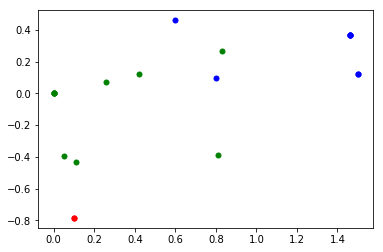

0
我问问 我问下
1
稍等 等下 等一下 等会 等 稍等下 等我查一下 等我看一下哈
2
等等 稍等一下 看看 我想想 好的,我看看 我看一下 我查一下 我查一下哈 我想想,晚点答复你 我稍等一下对吧
216.9724364314963


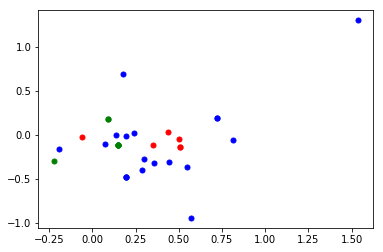

0
不懂 不明白 没懂 不懂了 不懂是什么意思 这样我还是不懂
1
啥意思 看不懂 啥意思? 这是啥意思 不太懂 小来的意思是一个级别的3本书要380? 这是干嘛的 请回电话 是不是过分了 额? 怎麽知道 额 什么意思?同一个人放弃又接单 助理是什么情况 你问问他们这次是不是可以当场修好 我不懂待办什么 这个订单是什么个状况? 看不懂[Facepalm][Facepalm][Facepalm] 我看不懂你在说什么
2
什么意思 什么意思? 什么意思啊 什么意思呢 这是什么意思 这是什么情况 什么情况 什么嘛
47.57532317005453


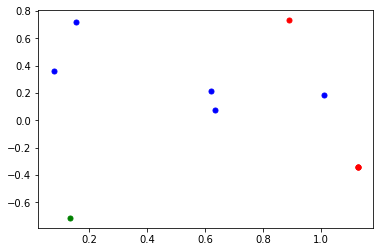

0
不是这个 不是的 不是不是 不是北京的
1
不是这个地址 地址改一下 地址要换 地址不对 地址
2
不不不
13.529164545500045


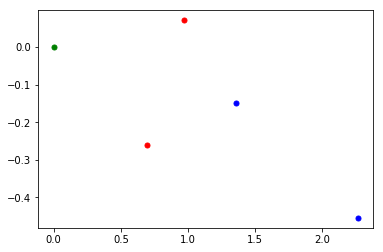

0
帮我订位子 帮我订一台
1
给我订吧 帮我订
2
定吧
491.8750407092536


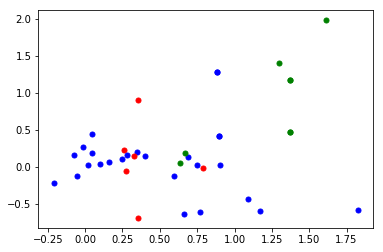

0
吃完了 吃了 我朋友都吃完早点了 买完了 吃过了呢 做完了∼
1
找到了 我我找到了找到了. 已找到 找到啦 懂了 了解 原来如此 明白了, 晓得了 我已打卡 我打完卡了 打过卡了 好的,明白了,半自动的 我身体棒棒的 吃饱了喝足了 小来我今天读了书了 我早上打过了 早起床了 没办法 自然醒 男朋友好帅 还好我聪明 只给了0.01 了解了 我有答案了 要遵从本心 我终于登上了 没事 我经常生气。身体还是棒棒的 早起床
2
联系了 联系过 联系过了 联系我了 联系上了 联系过快递员 联系上了吗 也已经联系过小哥了
113.22296318386586


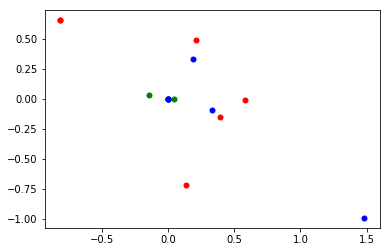

0
不可能 怎么可能 不会吧 不会啊 不可以 这是完全不可能的!!!
1
还是不行 没用 不行啊 不行 不行  不行 发了两次跑腿订单了 太不靠谱了 不行?
2
太不靠谱 不靠谱
81.99485527993085


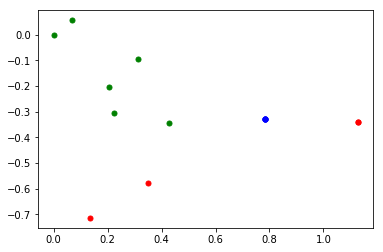

0
不是 没有啊 不可以 不是啊
1
错啦 错了 错 错了啊
2
不对 否 刚才一个跑腿的单下错了 我问你错了没有 太扯了啊 文章参数错误
95.33750582861825


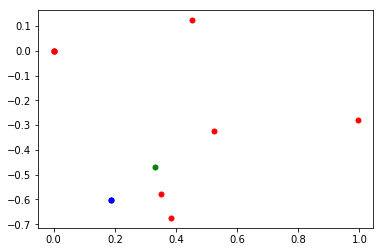

0
可以么？ 可以吗? ok? 好不好 还没有吗 可以嘛 对吧 小来早上好!你的大纲发我看看好不好啊?
1
好吗 好嘛
2
有了吗
512.3769111939785


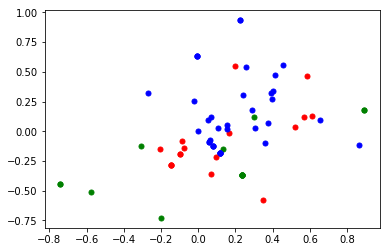

0
今天不需要 不需要了谢谢 不需要 不需要了 不需要了,谢谢 暂时不需要 不叫了 没有就算了 我自己来吧 不需要了, 不好意思我不需要 我不需要跑腿哥啦 不需要 不满意 嗯。暂时没有需要帮忙的 我不需要叫车 我的问题还不解决 先不需要吧
1
不了，谢谢 算了 那算了 不用了,谢谢 不用了谢谢 谢谢,不用了 不用谢谢 算了吧 不用了, 不用,谢谢 那算了吧 算了算了 算了,不用了 不用, 明天再说吧 那就算了吧 算了 不用了 不要核实了 我自己订了中午饭 你删除吧,我自己来 这样哦,那好吧 今天已经喝过 退下吧/::> 明天见/:,@-D 好麻烦还是算了吧 哈哈，那算了 我说算了 算了 我都喝了 谢谢!送机不用安排了 我不叫车 有的话我会找你的 别说了 麻痹的   没叫你 不用了 谢谢 不用了 谢谢哈 不用了。谢谢 不要机器人 我等一下再来找你。
2
那就不要了 现在不用 不用了 不用 不要 不要了 不用啦 不了 暂时不用 先不用了 不用不用 我不要了 暂时不用了 我不要这些 还是不用了
11.407915423959274


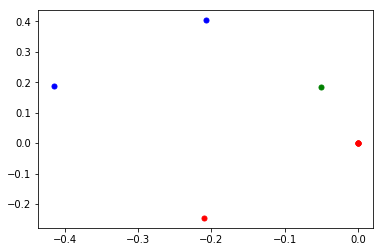

0
现在 现在现在 马上 现在。 不行，必须现在
1
急 着急
2
不行，我想现在
159.2067194848927


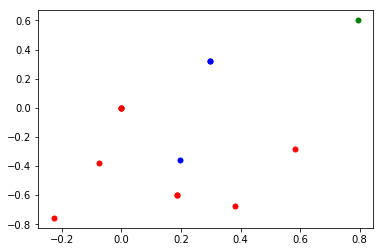

0
好了 可以了 好啦 行吧 ok了 搞定了 现在可以了 就酱 可以了。
1
没了 就这样吧 就这样
2
绑定了
17.743432755329245


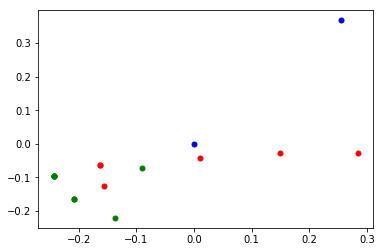

0
我不急你 嗯不急谢谢 再有个不急的事 没问题,也不急 嗯,这个也不急 没事,你查,我不急
1
先不忙 不急不急
2
不急 我不急 好的不急 都不急的 都不急 哇不急 我不急的哈哈 都是不急的东西
156.91088931379983


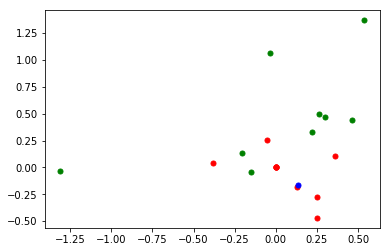

0
那怎么办 怎么弄 怎么办? 咋办 怎么弄? 我要处理结果 肿么办 你是不是要帮我处理下 那什么办啊?你说啊 跑腿办港澳签注
1
这个怎么弄里
2
怎么说 如何 怎么解决 我怎么联系他 怎么解决我投诉的事情 然后怎么做 怎么联系 请帮我处理退款 请尽快看看怎么处理
64.95375164311572


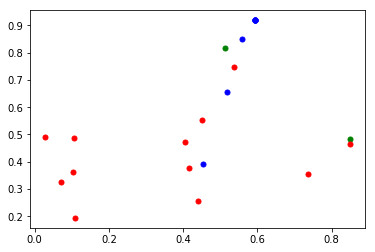

0
我先试试 我去试试 我就试试 再试试 我再试试 你再试试 我来试试 我在试试 慢慢来 我尝试下 谢谢 尝试一下 想来试试呢
1
试试吧 我试试 试试就试试 都试试 好试试 试试的 我们先试试 试试
2
签到试试 打卡试试
146.37834711011573


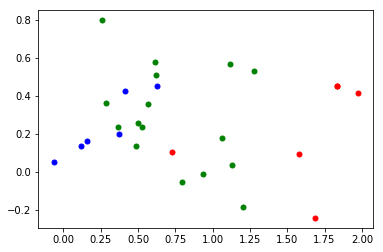

0
修改 改一下 更改 怎么改 电话改一下 修改一下
1
修改一下公司地址,增加西门 小助理 帮我送到南楼喔 你好,我的送货地址错了,应该是延静东里3号楼5单元302 我要改送地址發給送單大哥嗎 能否改个地址到双榆树南里 我叫马奇朵送到这个地址
2
怎么修改订单地址 地址要修改 换个地址,把地址发你这里可以么 换时间 地址修改 我添加不了地址 怎么删除我的地址呀 帮我地址换下可以吗 我改个地址 定义一下我女朋友的地址 地址弄错了 换地址 如何修改地址 地址识别的不对啊 更改一下地址 我要更改一下配送地址
21.201117316762566


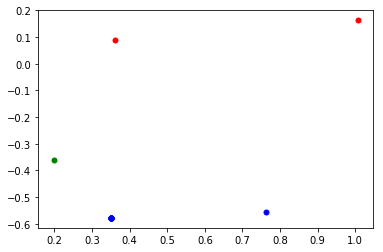

0
暂时没有 还是没有
1
木有 没有呢 没有哦 没有呀 并没有 没有的 没有。 都没有
2
没呢
18.855039207048154


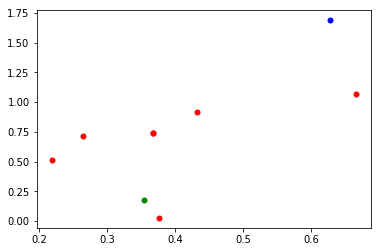

0
APP和公众号用哪个？ 公众号和APP哪个好用 怎么有App也有公众号？ 公众号和APP有区别吗 公众号和APP有啥区别？ app好用还是person公众号 在公证号怎么搜索不到你
1
关注公众号
2
微信跟app的区别
52.88169267093927


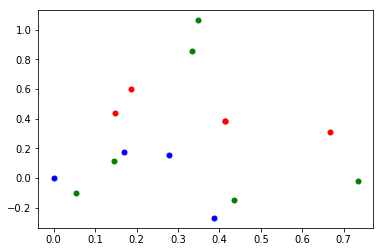

0
下载app 或者app app下载 app怎么下载 app在那下载
1
APP下载 APP App是不是下架了 小来什么时候出app呢 超期待?
2
没找到你们app 没找到在app上 你有移动app么?app里面有 助理来也app 这样我就不需要单独app啦 助理来也软件下载
4.542116747189058


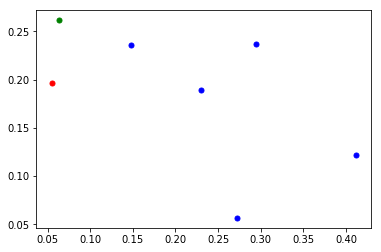

0
希望能保护我的隐私
1
泄露隐私咋整 泄露隐私了就不好了 泄露我隐私怎么办？ 不想被泄露隐私 你们不会泄露我隐私吧
2
把手机号给你不会有什么影响吧
19.40389041852761


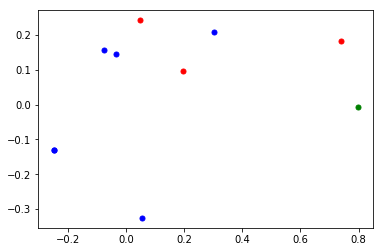

0
有什么好玩的新功能？ 有什么新功能 最近有新功能吗？
1
有啥最新功能呀？ 有意思的功能有嘛 有啥功能現在 正在熟悉服务功能 你都有啥功能 我想试一试你的功能
2
还有啥用?
113.55638122417929


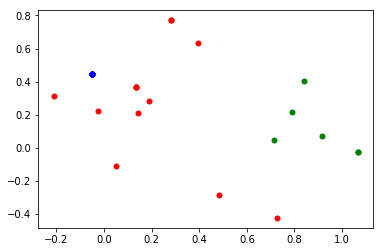

0
今天几号 现在几点了, 乌鲁木齐现在几点 你好今天几号 今天日期 下来还能下来现在几点钟啦? 不会看时间啊 现在几点钟 现在几点了告诉我一下 几点钟了 北京时间现在几点 北京时间几点 你能告诉我几点了吗
1
几点了 现在几点 现在现在几点了 现在几点了 现在几点了?
2
请问今天农历? 年阴历多少号 今天努力多少号 今天阴历多少号 请问今天阳历多少号 请问今天阴历多少号
43.97017164147844


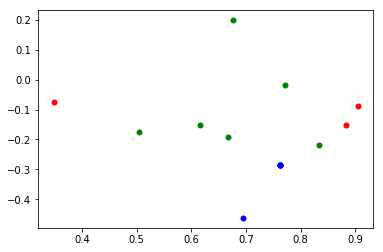

0
好友介绍的 朋友介绍的 我们是朋友吗
1
朋友圈看到的 朋友圈 朋友圈看到 朋友圈看到的! 朋友圈看到的哦
2
群里发现的 我是在朋友圈看到的 朋友圈看到,然后朋友推荐 我在朋友圈看到的,有问题吗? 朋友圈看到滴 在朋友圈看到小来
11.164501995640578


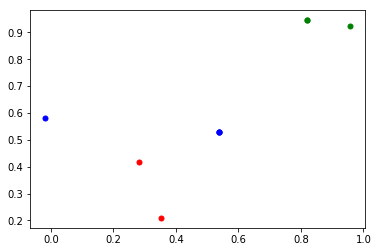

0
我再多次退出再登录试试 好的好的那我退出重新登录
1
退出 退出了 退出吧 不会退出
2
退出登录 点退出登录? 点了退出登录
21.090736291445594


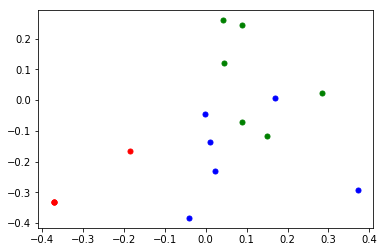

0
纸条呢 能塞个纸条么 传纸条 纸条
1
匿名小纸条 能帮我写个小纸条吗 可以附带小纸条么 小来,现还有小纸条吗 小纸条 或者 小纸条
2
七夕匿名传话 匿名 匿名传情 小来    匿名小纸条的链接发我一下 怎么匿名传话 小来 匿名小纸条的链接发我一下
0.9280229019300263


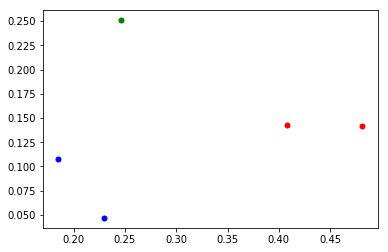

0
怎么取消一键里的内容? 想取消一键里的内容
1
如何取消一键里的内容? 怎么样取消一键里的内容?
2
取消一键里的内容，如何操作
1.799095186698714


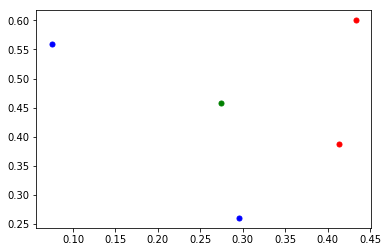

0
基础服务 基础服务都有啥呢
1
基础服务都有什么？ 基础服务都有什么项目
2
基础服务都有哪些？
0.9250138775677303


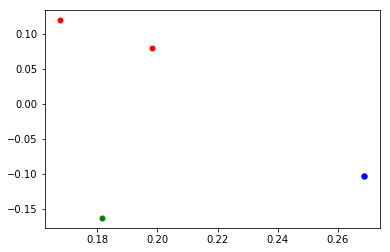

0
身在国外，有没有人能帮我 身在国外，有人能帮我吗？
1
我在印尼你可以帮我吗？ 我在印尼你能帮我吗？
2
我在国外你能不能帮我？
6.552285636805977


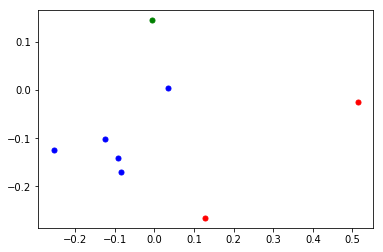

0
有什么书推荐吗 还有其他书推荐吗
1
推荐几本30来岁女性喜欢看的书 要来推荐几本好看的书给我, 给我推荐几本好书 帮我推荐几本好书 推荐几本好书
2
随便推荐一篇文章给我
13.586990343347697


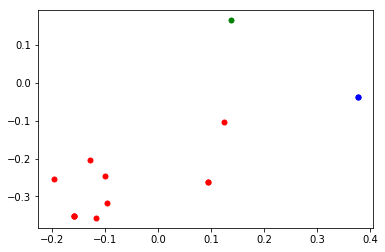

0
扎克伯格推荐的书单 扎克伯格推荐书单. 扎克伯格推荐的书单有哪些那帮我发一下我看看 扎克伯格书单 扎克伯格的书单 帮我查一下扎克伯格书单 扎克伯格的书单是啥 小来帮我查一下扎克伯格书单。 扎克伯格有哪些书啊 扎克伯格的书单都有什么 能给我来一个扎克伯格的书单吗?
1
推荐书单看看 推荐个书单
2
我的读书计划是读什么书?
111.77598804114515


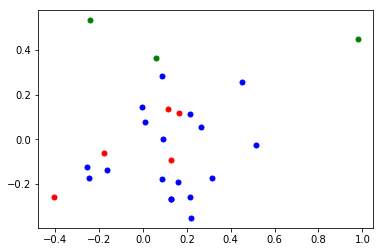

0
没书,读啥? 怎么开始阅读啊 读什么书 看那些书? 不知道读什么书
1
书单 推荐一本书看看 有什么书推荐吗 还有其他书推荐吗 有推荐的书吗 有推荐的书看吗 有什么书可以推荐的 看什么书么推荐下 要来推荐几本好看的书给我, 求推荐本商业方面比较好的书 小来,请帮我推荐person的书 有什么书可以看,推荐一下呗 有没有比较好的逻辑课推荐或者书推荐下 只是想知道会推荐什么书呢?有点好奇 随便推荐一篇文章给我 有没有推荐的书或电影 推荐一本适合我的书 这里有什么好书推荐么?
2
我要看书 看书 我要读书
1.9820723027414473


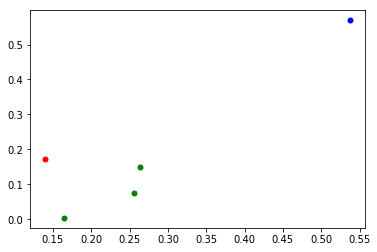

0
小来你的小程序是什么
1
开发小程序了吗？
2
来也有什么小程序？ 你们都有什么小程序 有小程序吗？
36.238084489779254


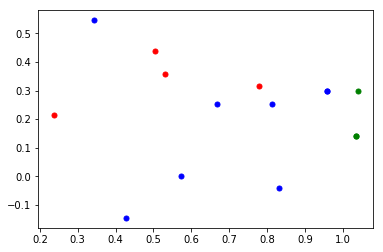

0
小程序 怎么创建小程序 群通讯录的小程序使用 有企业通讯录的小程序吗
1
群通讯录怎么创建啊? 怎么创建群通讯录 怎样创建群通讯录啊 群通讯录使用方法 怎么加通讯录 记得有个通讯录吧? 群通讯录在哪 群通讯录在哪里建立
2
群通讯录 怎么弄群通讯录 查询群通讯录电话
25.88082581184132


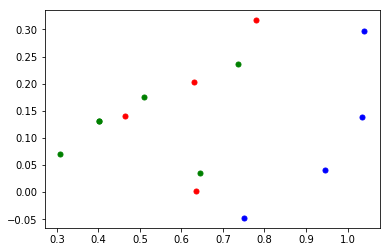

0
群通讯录好友进不去,说设置权限了 群通讯录的小程序使用 怎么小来通讯录中的好友? 群通讯录里为什么不能直接拨打电话呢?
1
怎么弄群通讯录 群通讯录怎么放到通讯录里 查询群通讯录电话 群通讯录好友进不去
2
请问怎样导出群通讯录? 怎样导出群通讯录? 群通讯录怎么用。 如何分享群通讯录? 群通讯录如何倒出 你那个群通讯录安全吗
7.081729852448557


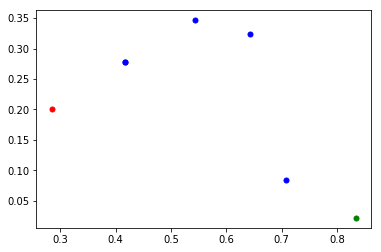

0
我想退出怎么退啊
1
怎么退出通讯录呀 怎么退出通讯录 怎么退出群通讯录 无法退出通讯录 不会退出群通讯录
2
通讯录怎么删除人
0.6423204073469411


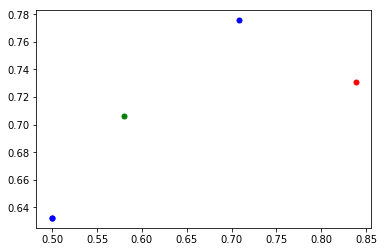

0
聚会约定
1
聚会约定怎么使用 如何使用聚会约定 聚会约定如何使用
2
我不会使用聚会约定
1.522644012410809


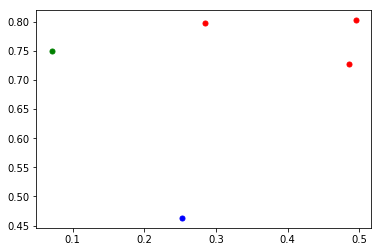

0
来也应聘 怎么去来也应聘 我可以去来也应聘吗？
1
如何到来也应聘
2
怎么应聘
67.22808573012945


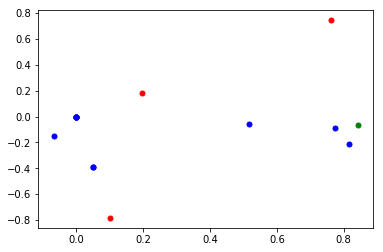

0
拜托 帮我看看 帮我个忙
1
你看看 帮我看一下 你问问 这样的 你看一下 帮我看下 你帮我看看 你给我问问好吗 你看呗 看下 麻烦你看下
2
看到了吗
79.69710973973943


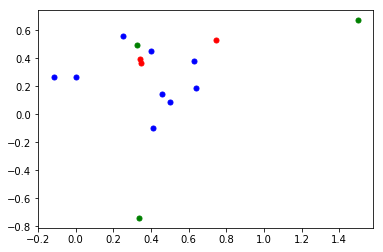

0
太慢了 反应太慢了 好慢啊
1
我对助理来也非常失望 算错了吧? 这软件不行呀 我投诉你,你会不知道吗? 你们怎么变得这么现实 为啥你们服务这么差 你们现在效率这么低下么! 你们以前服务挺好的啊 你最近好慢哦
2
差评 投诉 我要投诉
17.855687818245347


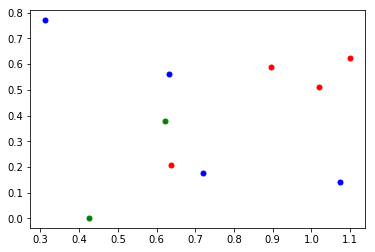

0
无法退出登录 无法退出 无法登录 我现在无法登录
1
点击,退出登录时,要我先登录 退出登录不了,那个号码换了 换了手机无法登录 我没办法退出登录呀
2
手机号已经不用了,无法退出 客户端成这样了,无法退出和使用
7.002992224182147


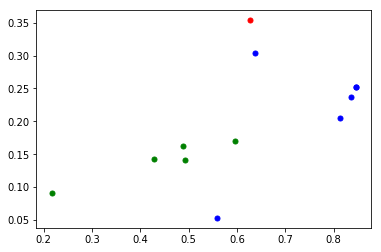

0
反馈通道
1
反馈通道进不去 反馈通道这个进不去 反馈通道我进不去了 反馈通道我进不去了，我是vip 但是反馈通道进不去啊 反馈通道怎么进不去
2
取消不了,反馈通道也进不去,什么情况 反馈通道进都进不去 反馈通道人超多,进不去 反馈通道垃圾,根本进不去 怎么点击反馈通道 就没有这个按钮
0.10926391626145492


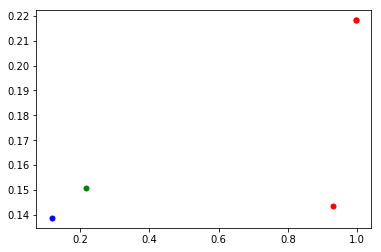

0
报bug 报一下bug 帮我报一下bug
1
日程有bug
2
日程的这些case你报一下
25.025892644731062


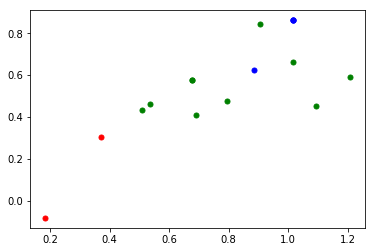

0
test 测粉,勿回!
1
测试 测试哈 我测试 测试一下
2
我是测试的 测试测试, 测试,测试 我在测试 在测试 测试来着 没事测试 测试别理 测试勿理 我在测试测试你听不懂吧,
2.345462257498649


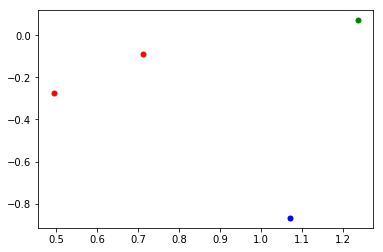

0
点不开 成为VIP点不开
1
打不开
2
进不去
62.76715592954419


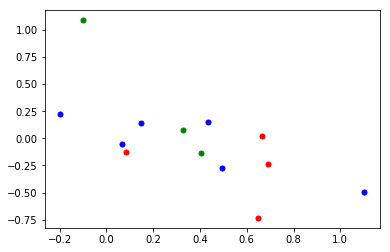

0
网页打不开 链接打不开 链接点不了 无法点开链接
1
点不开 现在就是点不动啊 还是点不动呀。 可是备注点不上没办法输入 怎么也点不掉 点了没用
2
点不进去吖 小来点不进去 点哪个啊
142.03305542472484


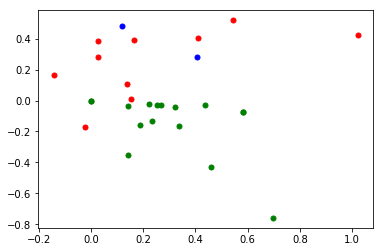

0
你这上面有什么bug 这个还有bug bug 你们的页面有bug 你好…打卡页面总出现bug 你们的bug请尽快修复 系统傻吧 系统出错 系统乱了吧 出错了
1
系统又出问题啦…… 出问题了
2
群通讯录字体突然扩大,字重叠,似乱码.怎么解决? 怎么搞的?字体扩大字重叠,似乱码. 乱码 都是乱码 打开都乱码 打开乱码了 乱码是咋回事呢 链接暴露 链接暴露是什么情况 链接暴露是怎么回事 Bug 咋回事 感觉是链接的link有问题啊 发的链接都过期了 出毛病了吧 这是BUG?
12.047431355065525


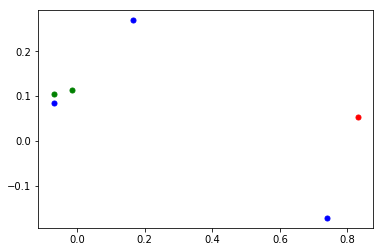

0
我这里出现了链接
1
你们系统有问题 系统有毛病啊 存在bug
2
你们的代码乱了 你们的代码出问题了
111.04119191118345


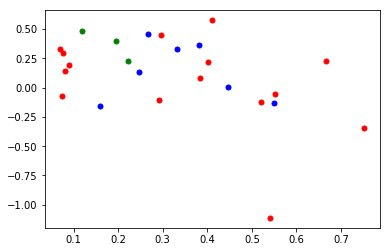

0
系统稳定吗 你们这系统不稳定 最近系统很不稳定的感觉 之前没收到消息是因为系统不太稳定? 太不稳定了 试过,信号不太稳定 最近系统非常不稳定,要么没有生成打卡图要么就是图片错乱 你们公众号是不是不稳定 你们服务器崩溃了吗 感觉这样的页面乱乱的 不是不是不是要我说几遍。 匿名小纸条 也有问题 系统崩了吗? 系统崩溃了? 这系统也是够够的了
1
你们平台是不是有问题 起初我也以为是网络问题 我说什么都让我预约保洁?为什么 好像出bug了 是不是出问题了 这个预约经常会有问题哦 你们后台是怎么回事,我打卡了。
2
是你们系统的问题 是系统有问题吗? 系统问题吗


In [17]:
if __name__=="__main__":
    data = pd.read_csv('../data/text.csv')
    for kno in data['knowledge'].unique():
        texts = list(data[data['knowledge'] == kno]['text'])
        if len(texts) < 3:
            continue
        word_util = word()
        word_util.get_word2vec()
        word_vecs = word_util.get_vectors_of_data_cut(texts)
        fold_result = fold(classCount = 3, texts = texts)
        result = fold_result.wordsCluster(word_vecs)
        for key in result:
            print key
            print result[key]